# 环境导入


In [1]:
# 导入库
import sys
import os

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

cotta_root = os.path.join(project_root, "baseline_code/cotta-main/cifar")
sys.path.append(cotta_root)

plf_root = os.path.join(project_root, "baseline_code/PLF-main/cifar")
sys.path.append(plf_root)


import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm, trange
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import math

from core_model.custom_model import ClassifierWrapper, load_custom_model
from core_model.dataset import get_dataset_loader
from core_model.train_test import model_test
from core_model.lip_teacher import SimpleLipNet

from configs import settings


import pandas as pd


import cotta
import plf

import torch.optim as optim

from cfgs.conf_cotta import cfg as cfg_cotta
from cfgs.conf_plf import cfg as cfg_plf


from args_paser import parse_args


# sys.argv = ['', '--dataset','cifar-10', '--model', 'cifar-resnet18']
# custom_args = parse_args()
# custom_args

In [19]:
os.environ["CUDA_VISIBLE_DEVICES"] = "6"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 通用函数


### setup components for testing TTA methods

cotta and plf

In [3]:
def setup_cotta(model, args):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """

    def setup_optimizer(params):
        """Set up optimizer for tent adaptation.

        Tent needs an optimizer for test-time entropy minimization.
        In principle, tent could make use of any gradient optimizer.
        In practice, we advise choosing Adam or SGD+momentum.
        For optimization settings, we advise to use the settings from the end of
        trainig, if known, or start with a low learning rate (like 0.001) if not.

        For best results, try tuning the learning rate and batch size.
        """
        if cfg_cotta.OPTIM.METHOD == "Adam":
            return optim.Adam(
                params,
                lr=cfg_cotta.OPTIM.LR,
                betas=(cfg_cotta.OPTIM.BETA, 0.999),
                weight_decay=cfg_cotta.OPTIM.WD,
            )
        elif cfg_cotta.OPTIM.METHOD == "SGD":
            return optim.SGD(
                params,
                lr=cfg_cotta.OPTIM.LR,
                momentum=cfg_cotta.OPTIM.MOMENTUM,
                dampening=cfg_cotta.OPTIM.DAMPENING,
                weight_decay=cfg_cotta.OPTIM.WD,
                nesterov=cfg_cotta.OPTIM.NESTEROV,
            )
        else:
            raise NotImplementedError

    model = cotta.configure_model(model)
    params, param_names = cotta.collect_params(model)
    optimizer = setup_optimizer(params)
    cotta_model = cotta.CoTTA(
        model,
        optimizer,
        args,
        steps=cfg_cotta.OPTIM.STEPS,
        episodic=cfg_cotta.MODEL.EPISODIC,
        mt_alpha=cfg_cotta.OPTIM.MT,
        rst_m=cfg_cotta.OPTIM.RST,
        ap=cfg_cotta.OPTIM.AP,
    )
    return cotta_model


def setup_plf(model, custom_args, num_classes):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """

    def setup_optimizer(params):
        """Set up optimizer for tent adaptation.

        Tent needs an optimizer for test-time entropy minimization.
        In principle, tent could make use of any gradient optimizer.
        In practice, we advise choosing Adam or SGD+momentum.
        For optimization settings, we advise to use the settings from the end of
        trainig, if known, or start with a low learning rate (like 0.001) if not.

        For best results, try tuning the learning rate and batch size.
        """
        if cfg_plf.OPTIM.METHOD == "Adam":
            return optim.Adam(
                params,
                lr=cfg_plf.OPTIM.LR,
                betas=(cfg_plf.OPTIM.BETA, 0.999),
                weight_decay=cfg_plf.OPTIM.WD,
            )
        elif cfg_plf.OPTIM.METHOD == "SGD":
            return optim.SGD(
                params,
                lr=cfg_plf.OPTIM.LR,
                momentum=cfg_plf.OPTIM.MOMENTUM,
                dampening=cfg_plf.OPTIM.DAMPENING,
                weight_decay=cfg_plf.OPTIM.WD,
                nesterov=cfg_plf.OPTIM.NESTEROV,
            )
        else:
            raise NotImplementedError

    model = plf.configure_model(model)
    params, param_names = plf.collect_params(model)
    optimizer = setup_optimizer(params)
    plf_model = plf.PLF(
        model,
        optimizer,
        custom_args,
        steps=cfg_plf.OPTIM.STEPS,
        episodic=cfg_plf.MODEL.EPISODIC,
        mt_alpha=cfg_plf.OPTIM.MT,
        rst_m=cfg_plf.OPTIM.RST,
        ap=cfg_plf.OPTIM.AP,
        num_classes=num_classes,
    )
    return plf_model


def clean_accuracy(
    model: nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
    batch_size: int = 100,
    device: torch.device = None,
):
    if device is None:
        device = x.device
    acc = 0.0
    n_batches = math.ceil(x.shape[0] / batch_size)
    with torch.no_grad():
        for counter in trange(n_batches):
            x_curr = x[counter * batch_size : (counter + 1) * batch_size].to(device)
            y_curr = y[counter * batch_size : (counter + 1) * batch_size].to(device)

            # print(f'Batch with sample num: {len(x_curr)}')
            output = model(x_curr)
            corrected_num = (output.max(1)[1] == y_curr).float().sum()
            acc += corrected_num

            # [2024-10-10 sunzekun] 屏蔽了结果输出，保持界面整洁
            # print('batch %d, corrected_num: %d' % (counter, corrected_num.item()))
        # save step model_tta
    return acc.item() / x.shape[0]

### func: get_test_acc

In [4]:
def get_test_acc(test_loader, model, device):

    # Run-Experiment代码里的评估代码。
    # 只能测试总体的test_acc
    # 放在这里只是为了检查一下错误是不是发生在eva中。实际上可能不用。
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc=f"Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(
                    device
                )
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # 更新进度条
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


class BaseTensorDataset(Dataset):

    # Run-Experiment代码里的自定义数据集。
    # 放在这里只是为了检查一下错误是不是发生在数据集中。实际上可能不用。

    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]

### func: get_suffix

In [5]:
def get_suffix(method, step):
    # 不同的method有不同的后缀
    # 例如，contra有restore和tta的，我们在综合测评中应该只考虑tta
    # 并且根据step还有所不同。step0的情况下，所有的suffix都为worker_restore.
    # 因此，需要一个函数专门处理各种情况
    # # Step-0

    if step == 0:
        # [24-10-11 sunzekun] 只是为了检测一下contra-teacher的性能临时加的代码
        # if method == 'contra':
        #     return 'teacher_restore'
        # else:
        #     return "worker_restore"
        return "worker_restore"

    # Step-1,2,3
    if method in ["cotta", "plf", "contra"]:
        return "worker_tta"
    else:
        return "worker_restore"

    # ================================================================= #
    # [24-10-14 sunzekun] 单独为ablation-study写的get_suffix
    # 因为区别只是在后缀上精细控制，所以不改eva_系列的函数
    # 仅在该函数中进行手动切换，使用的时候需要特别注意

    # if step == 0:
    #     return "worker_restore"

    # # Step-1,2,3
    # if method == 'contra_tta_only':
    #     # return "worker_restore"
    #     return "worker_tta"
    # else: # method = 'contra'
    #     return "worker_tta"
    #     # return "worker_restore"

### func: eva_test_acc

In [6]:
def eva_test_acc(
    dataset_name,
    model_name,
    noise_type="symmetric",
    noise_ratio=0.5,
    methods=None,
    steps=None,
    results_dir=None,
):
    """
    核心代码，用来评估指定dataset任务下的所有方法的step0~4的测试准确率
    """

    # case = settings.get_case(
    #     noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    # )

    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type,
    )
    mean, std = None, None
    num_classes = settings.num_classes_dict[dataset_name]
    print(f"目前测试的数据集：{dataset_name}, case模式：{case}")

    # 读入测试数据集
    # core.py中使用的数据集读入代码

    # batch_size = 128

    batch_size = 64

    # PET-37的cotta方法,batch_size要设置的特别小
    # batch_size = 1
    test_data, test_labels, test_dataloader = get_dataset_loader(
        dataset_name,
        "test",
        case,
        None,
        mean,
        std,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,
    )

    # run_experiment.py中的代码, 用于对比验证效果。
    # print(f'Targeted dataset: {settings.get_dataset_path(dataset_name, case, "test_data")}')

    # D_test_data = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_data")
    # )
    # D_test_labels = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_label")
    # )
    # test_dataset = BaseTensorDataset(D_test_data, D_test_labels, device=device)
    # test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # [Debug用]-检查一下数据
    # x, y = next(iter(test_dataloader))
    # print(x[0])

    #
    # steps = [f'step_{i}' for i in range(4)]
    assert methods is not None, "请指定要评估的方法"
    assert steps is not None, "请指定要评估的step(实验组)"
    assert methods is not None, "请指定评估结果保存的目录"
    os.makedirs(results_dir, exist_ok=True)

    df = pd.DataFrame(index=methods, columns=steps)

    # for method in tqdm(methods):

    for method in methods:
        for step in steps:
            # 先确定一下模型的suffix
            model_suffix = get_suffix(method, step)
            # 读入模型架构
            # 放到循环里边，每次都要重新新建一个模型。
            # 牺牲了一些速度，但是好处是防止cotta和plf把模型架构更改了，导致repair类的模型出问题
            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)

            # 按照模型名和step数读入模型参数
            model_repair_save_path = settings.get_ckpt_path(
                dataset_name,
                case,
                model_name,
                model_suffix=model_suffix,
                step=step,
                unique_name=method,
            )
            """
            专为测试lipNet性能的代码
            """
            # model = load_custom_model(model_name, num_classes, load_pretrained=True)
            # features = model.fc.in_features
            # model = nn.Sequential(*list(model.children())[:-1], nn.Flatten())
            # model = SimpleLipNet(model, features, num_classes)
            # model_repair_save_path = '/nvme/sunzekun/Projects/tta-mr/ckpt/cifar-10/pretrain/step_0/cifar-resnet18_teacher_restore.pth'
            # model_repair_save_path = '/nvme/szh/code/tta-mr/ckpt/cifar-10/pretrain/step_0/cifar-resnet18_teacher_restore.pth'
            # model_repair_save_path = '/nvme/szh/code/tta-mr/ckpt/cifar-10/pretrain/step_0/cifar-resnet18_worker_restore.pth'
            # model_repair_save_path = '/nvme/sunzekun/Projects/tta-mr/ckpt/cifar-100/pretrain/step_0/cifar-wideresnet40_teacher_restore.pth'
            # model_repair_save_path = '/nvme/sunzekun/Projects/tta-mr/ckpt/cifar-100/pretrain/step_0/cifar-wideresnet40_worker_restore.pth'
            # model_repair_save_path = '/nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/pretrain/step_0/wideresnet50_teacher_restore.pth'
            # model_repair_save_path = '/nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/pretrain/step_0/wideresnet50_worker_restore.pth'

            print(f"Evaluating {model_repair_save_path}")

            # checkpoint = torch.load(model_repair_save_path)
            try:
                checkpoint = torch.load(model_repair_save_path)
            except:
                print(
                    f"Cannot find the weight file at {model_repair_save_path}. Just SKIP."
                )
                continue
            model.load_state_dict(checkpoint, strict=False)

            # [24-10-10 sunzekun] 有两个特殊的tta模型：cotta和plf，不仅改了参数，而且使用了特定的模型架构来进行推断。
            # (即，不仅有test-time Adaptation，还有Augmentation)
            # 所以对这两种需要另外写代码实现。
            # 注意，contra没有这个特殊过程。
            if method == "cotta" or method == "plf":
                # if (method == 'cotta' or method == 'plf') and dataset_name != 'pet-37':
                # if (method == 'cotta' or method == 'plf') and dataset_name == 'cifar-10':
                # 由于测试代码的jupyternotebook 构建命令行参数很麻烦
                # 这里暂时去掉了dataset，model这两个必选参数的required = True
                # 而是直接在使用的时候复制。
                sys.argv = [
                    "",
                    "--dataset",
                    dataset_name,
                    "--model",
                    model_name,
                    "--uni_name",
                    method,
                    "--noise_type",
                    noise_type,
                    "--balanced",
                ]
                custom_args = parse_args()
                model.eval().to(device)
                if method == "cotta":
                    model_aug = setup_cotta(model, custom_args)
                else:
                    model_aug = setup_plf(model, custom_args, num_classes)

                try:
                    model_aug.reset()
                except:
                    print(f"Failed to reset")

                x_test = torch.from_numpy(test_data)
                y_test = torch.from_numpy(test_labels)
                x_test, y_test = x_test.to(device), y_test.to(device)

                test_acc = clean_accuracy(
                    model_aug, x_test, y_test, batch_size=batch_size, device=device
                )
                # print(test_acc)
            else:
                test_acc = model_test(test_dataloader, model, device=device)
                # print(test_acc)
                test_acc = test_acc["global"]

            print(f"测试集Acc：{test_acc}")
            df.loc[method, step] = test_acc
            # test_acc = get_test_acc(test_dataloader, model, device=device)
            # df.loc[method, step] = test_acc

    # 保留参考代码，万一想用excel保存结果的时候用下面的
    # results_file_name = f'{dataset_name}.xlsx'
    # results_file_dir = os.path.join(results_dir, results_file_name)
    # with pd.ExcelWriter(results_file_dir, engine='openpyxl') as writer:
    #     df.to_excel(writer)
    # for tab, df in dfs.items():

    # cls: 分类任务
    # rtv: 检索任务
    mission_type = "cls" if noise_type == "symmetric" else "rtv"
    results_file_name = f"{dataset_name}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)

### icde_func: eva_map

In [7]:
def eva_map(
    dataset_name,
    model_name,
    noise_type="asymmetric",
    noise_ratio=0.5,
    top_k=10,
    methods=None,
    steps=None,
    results_dir=None,
):
    """
    核心代码，用来评估指定dataset任务下的所有方法的step0~4的map，检索任务专用
    """

    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    )
    mean, std = None, None
    num_classes = settings.num_classes_dict[dataset_name]
    print(f"目前测试的数据集：{dataset_name}, case模式：{case}")

    # ------------------------------------------------------------------------------------ #
    # 读入测试数据集
    # core.py中使用的数据集读入代码
    # train_data, train_labels, train_dataloader = get_dataset_loader(
    #     dataset_name, "train", case, None, mean, std, batch_size=128, shuffle=False, num_workers=8
    # )

    # test_data, test_labels, test_dataloader = get_dataset_loader(
    #     dataset_name, "test", case, None, mean, std, batch_size=128, shuffle=False, num_workers=8
    # )

    # [24-10-14 数据集存放位置有变化，现在train和test的data已经独立于case了，所以去掉]
    train_data, train_labels, train_dataloader = get_dataset_loader(
        dataset_name,
        "train",
        None,
        None,
        mean,
        std,
        batch_size=128,
        shuffle=False,
        num_workers=8,
    )

    test_data, test_labels, test_dataloader = get_dataset_loader(
        dataset_name,
        "test",
        None,
        None,
        mean,
        std,
        batch_size=128,
        shuffle=False,
        num_workers=8,
    )

    # ------------------------------------------------------------------------------------ #

    # run_experiment.py中的代码, 用于对比验证效果。
    # print(f'Targeted dataset: {settings.get_dataset_path(dataset_name, case, "test_data")}')

    # D_test_data = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_data")
    # )
    # D_test_labels = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_label")
    # )
    # test_dataset = BaseTensorDataset(D_test_data, D_test_labels, device=device)
    # test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # [Debug用]-检查一下数据
    # x, y = next(iter(test_dataloader))
    # print(x[0])

    assert methods is not None, "请指定要评估的方法"
    assert steps is not None, "请指定要评估的step(实验组)"
    assert methods is not None, "请指定评估结果保存的目录"
    os.makedirs(results_dir, exist_ok=True)

    df = pd.DataFrame(index=methods, columns=steps)

    # for method in tqdm(methods):

    for method in methods:
        for step in steps:
            # 先确定一下模型的suffix
            model_suffix = get_suffix(method, step)
            # 读入模型架构
            # 放到循环里边，每次都要重新新建一个模型。
            # 牺牲了一些速度，但是好处是防止cotta和plf把模型架构更改了，导致repair类的模型出问题
            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)

            # 按照模型名和step数读入模型参数
            model_repair_save_path = settings.get_ckpt_path(
                dataset_name,
                case,
                model_name,
                model_suffix=model_suffix,
                step=step,
                unique_name=method,
            )
            print(f"Evaluating {model_repair_save_path}")

            # checkpoint = torch.load(model_repair_save_path)
            try:
                checkpoint = torch.load(model_repair_save_path)
            except:
                print(
                    f"Cannot find the weight file at {model_repair_save_path}. Just SKIP."
                )
                continue
            model.load_state_dict(checkpoint, strict=False)

            # [24-10-10 sunzekun] 有两个特殊的tta模型：cotta和plf，不仅改了参数，而且使用了特定的模型架构来进行推断。
            # (即，不仅有test-time Adaptation，还有Augmentation)
            # 所以对这两种需要另外写代码实现。
            # 注意，contra没有这个特殊过程。

            # [24-10-11 sunzekun] 对于两个带tta的模型，这里不再做单独的增强了，因为增强和检索比较难适配。
            # 直接

            mAP = get_map(model, train_dataloader, test_dataloader, top_k)
            print(f"测试mAP：{mAP}")

            df.loc[method, step] = mAP
            # test_acc = get_test_acc(test_dataloader, model, device=device)
            # df.loc[method, step] = test_acc

    # 保留参考代码，万一想用excel保存结果的时候用下面的
    # results_file_name = f'{dataset_name}.xlsx'
    # results_file_dir = os.path.join(results_dir, results_file_name)
    # with pd.ExcelWriter(results_file_dir, engine='openpyxl') as writer:
    #     df.to_excel(writer)
    # for tab, df in dfs.items():

    # cls: 分类任务
    # rtv: 检索任务
    mission_type = "cls" if noise_type == "symmetric" else "rtv"
    results_file_name = f"{dataset_name}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)


# 特征提取函数
def extract_features(feature_extractor, data_loader):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            images = images.to(device)
            outputs = feature_extractor(images)
            outputs = outputs.view(outputs.size(0), -1)
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels


def retrieve(gallery_feats, query_feats, top_k=10):
    sims = cosine_similarity(query_feats, gallery_feats)
    indices = np.argsort(-sims, axis=1)[:, :top_k]
    sim_scores = np.take_along_axis(sims, indices, axis=1)
    return indices, sim_scores


def calculate_map(indices, gallery_labels, query_labels):
    num_queries = query_labels.shape[0]
    ap_list = []
    for i in range(num_queries):
        query_label = query_labels[i]
        retrieved_labels = gallery_labels[indices[i]]
        relevant = (retrieved_labels == query_label).astype(int)
        num_relevant = relevant.sum()
        if num_relevant == 0:
            ap_list.append(0)
            continue
        cumulative_precision = np.cumsum(relevant) / (np.arange(len(relevant)) + 1)
        ap = (cumulative_precision * relevant).sum() / num_relevant
        ap_list.append(ap)
    mAP = np.mean(ap_list)
    return mAP


def get_map(model, train_loader, test_loader, top_k):
    model.to(device)
    model.eval()
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()

    # 提取特征
    g_features, g_labels = extract_features(feature_extractor, train_loader)
    q_features, q_labels = extract_features(feature_extractor, test_loader)
    indices, _ = retrieve(g_features, q_features, top_k=top_k)
    mAP = calculate_map(indices, g_labels, q_labels)

    return mAP

### icde_func: eva_retrieval

In [8]:
def eva_retrieval(
    dataset_name,
    model_name,
    noise_type="asymmetric",
    noise_ratio=0.5,
    methods=None,
    steps=None,
    top_k=5,
    query_indices=[0],
    use_cache=False,
):
    """
    核心代码，用来展示任意模型的检索结果，检索任务专用
    重要参数：top_k, 用于确定一次输出多少张图片
    """

    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    )
    mean, std = None, None
    num_classes = settings.num_classes_dict[dataset_name]
    print(f"目前测试的数据集：{dataset_name}, case模式：{case}")

    # 读入测试数据集
    # core.py中使用的数据集读入代码
    # train_data, train_labels, train_dataloader = get_dataset_loader(
    #     dataset_name, "train", case, None, mean, std, batch_size=128, shuffle=False
    # )

    # # TODO-仅用来测试一下数据集的归一化和恢复，以及展示情况
    # # print(train_data[0].shape)
    # # print(train_data[0])
    # # return
    # # img = recover_img(train_data[0], dataset_name)
    # # print(img.max(), img.min())
    # # plt.figure()
    # # plt.imshow(np.transpose(img, (1, 2, 0)))
    # # plt.show()
    # # return

    # test_data, test_labels, test_dataloader = get_dataset_loader(
    #     dataset_name, "test", case, None, mean, std, batch_size=128, shuffle=False
    # )

    train_data, train_labels, train_dataloader = get_dataset_loader(
        dataset_name, "train", None, None, mean, std, batch_size=128, shuffle=False
    )

    test_data, test_labels, test_dataloader = get_dataset_loader(
        dataset_name, "test", None, None, mean, std, batch_size=128, shuffle=False
    )

    # run_experiment.py中的代码, 用于对比验证效果。
    # print(f'Targeted dataset: {settings.get_dataset_path(dataset_name, case, "test_data")}')

    # D_test_data = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_data")
    # )
    # D_test_labels = np.load(
    #     settings.get_dataset_path(dataset_name, case, "test_label")
    # )
    # test_dataset = BaseTensorDataset(D_test_data, D_test_labels, device=device)
    # test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # [Debug用]-检查一下数据
    # x, y = next(iter(test_dataloader))
    # print(x[0])

    assert methods is not None, "请指定要评估的方法"
    assert steps is not None, "请指定要评估的step(实验组)"

    # for method in tqdm(methods):

    for method in methods:
        for step in steps:
            # 先确定一下模型的suffix
            model_suffix = get_suffix(method, step)
            # 读入模型架构
            # 放到循环里边，每次都要重新新建一个模型。
            # 牺牲了一些速度，但是好处是防止cotta和plf把模型架构更改了，导致repair类的模型出问题
            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)

            # 按照模型名和step数读入模型参数
            model_repair_save_path = settings.get_ckpt_path(
                dataset_name,
                case,
                model_name,
                model_suffix=model_suffix,
                step=step,
                unique_name=method,
            )
            print(f"Evaluating {model_repair_save_path}")

            # checkpoint = torch.load(model_repair_save_path)
            try:
                checkpoint = torch.load(model_repair_save_path)
            except:
                print(
                    f"Cannot find the weight file at {model_repair_save_path}. Just SKIP."
                )
                continue
            model.load_state_dict(checkpoint, strict=False)

            # [24-10-10 sunzekun] 有两个特殊的tta模型：cotta和plf，不仅改了参数，而且使用了特定的模型架构来进行推断。
            # (即，不仅有test-time Adaptation，还有Augmentation)
            # 所以对这两种需要另外写代码实现。
            # 注意，contra没有这个特殊过程。

            # [24-10-11 sunzekun] 对于两个带tta的模型，这里不再做单独的增强了，因为增强和检索比较难适配。
            # 直接

            cache_path = get_cache_path(
                dataset_name=dataset_name,
                case=case,
                step=step,
                unique_name=method,
                top_k=top_k,
            )
            # print(cache_path)
            # return
            if use_cache:
                try:
                    data = np.load(cache_path)
                except:
                    print(
                        "未读取到对应的相似分数缓存。首次评估某个模型时，请先使用use_cache=False"
                    )
                    continue

                print(f"读取缓存的相似度分数记录：{cache_path}")
                indices = data["indices"]
                sim_scores = data["sim_scores"]
            else:
                indices, sim_scores = get_sim_scores(
                    model, train_dataloader, test_dataloader, top_k
                )
                np.savez(cache_path, indices=indices, sim_scores=sim_scores)
            # print(indices, sim_scores)
            # print(f'Length of retrived indices: {len(indices)}')
            # return
            for query_idx in query_indices:
                print(f"展示Query图片-idx-{query_idx}的搜索结果")
                display_image_grid(
                    test_data,
                    test_labels,
                    train_data,
                    train_labels,
                    query_idx,
                    indices[query_idx],
                    sim_scores[query_idx],
                    save_path=None,  # 如果需要保存图像，设置保存路径
                    dataset_name=dataset_name,  # 用于读取图片的归一化参数，执行‘反归一化’
                )


def get_sim_scores(model, train_loader, test_loader, top_k):
    model.to(device)
    model.eval()
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()

    # 提取特征
    g_features, g_labels = extract_features(feature_extractor, train_loader)
    q_features, q_labels = extract_features(feature_extractor, test_loader)
    indices, sim_scores = retrieve(g_features, q_features, top_k=top_k)

    return indices, sim_scores


def draw_box(ax, img, color="red"):

    # TODO- Pet37的参数
    # border_width = 6  # 边框的宽度
    # # adjust = border_width /2 + 1
    # adjust = 2

    # TODO- Cifar100的参数
    border_width = 6  # 边框的宽度
    # adjust = border_width /2 + 1
    adjust = 0

    _, height, width = img.shape
    # rect = Rectangle((-adjust + 1 + border_width, -adjust + 1 + border_width), width - 2 * border_width + adjust + 1 , height - 2 * border_width + adjust  + 1 ,
    #                 fill=False, edgecolor=color, linewidth=border_width)
    # rect = Rectangle((-adjust + border_width, -adjust + border_width), width - 2 * border_width + adjust, height - 2 * border_width + adjust,
    #             fill=False, edgecolor=color, linewidth=border_width)

    rect = Rectangle(
        (0, 0),
        width - 1,
        height - 1,
        fill=False,
        edgecolor=color,
        linewidth=border_width,
    )
    ax.add_patch(rect)


box_color = {
    # 'query' : '#FA9248',
    "query": "purple",
    "correct": "#4DA764",
    "wrong": "#E05757",
}


# box_color = {
#     'query' : 'purple',
#     'correct': 'green',
#     'wrong': 'red'
# }


def display_image_grid(
    query_data,
    query_labels,
    gallery_data,
    gallery_labels,
    query_index,
    retrieved_indices,
    sim_scores,
    save_path=None,
    dataset_name=None,
):
    assert dataset_name is not None, "请指明数据集名称，用于恢复对应的归一化后的图片"

    # 读入class_names，用于展示在图片上
    if dataset_name == "cifar-100":
        class_names = load_classes_from_file("../configs/classes/cifar_100_classes.txt")
    elif dataset_name == "pet-37":
        class_names = load_classes_from_file("../configs/classes/pet_37_classes.txt")
    else:
        raise NotImplementedError

    title_fs = 15  # 标题的字号大小

    K = len(retrieved_indices)
    plt.style.use("default")
    fig, axs = plt.subplots(1, K + 1, figsize=(15, 3))
    # 显示查询图像
    query_img = query_data[query_index]
    query_img = recover_img(query_img, dataset_name)

    axs[0].imshow(np.transpose(query_img, (1, 2, 0)))

    query_label = query_labels[query_index]
    query_class_name = class_names[query_label]
    axs[0].set_title(
        query_class_name,
        fontsize=title_fs,
        fontfamily="serif",
        weight="bold",
        color=box_color["query"],
    )
    axs[0].axis("off")

    draw_box(axs[0], query_img, color=box_color["query"])

    print(f"查询图片label：{query_label}-{query_class_name}")

    # 显示检索结果
    for i, idx in enumerate(retrieved_indices):
        img = gallery_data[idx]
        img = recover_img(img, dataset_name)
        axs[i + 1].imshow(np.transpose(img, (1, 2, 0)))

        label = gallery_labels[idx]
        class_name = class_names[label]
        # TODO [24-10-14 sunzekun] 增加相似度分数显示
        class_name = f"{class_name} ({sim_scores[i]:.2f})"

        # axs[i + 1].set_title(class_name, fontsize=title_fs, fontfamily="serif", weight="bold")
        # axs[i + 1].set_title(f"Sim: {sim_scores[i]:.2f}")
        axs[i + 1].axis("off")

        if label == query_label:
            draw_box(axs[i + 1], img, color=box_color["correct"])
            axs[i + 1].set_title(
                class_name,
                fontsize=title_fs,
                fontfamily="serif",
                weight="bold",
                color=box_color["correct"],
            )
        else:
            draw_box(axs[i + 1], img, color=box_color["wrong"])
            axs[i + 1].set_title(
                class_name,
                fontsize=title_fs,
                fontfamily="serif",
                weight="bold",
                color=box_color["wrong"],
            )

    if save_path:
        plt.savefig(save_path)

    plt.gca().set_axis_off()
    plt.subplots_adjust(
        left=0, right=1, top=1, bottom=0, wspace=0.02, hspace=0
    )  # 适配top-5
    # plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.035, hspace=0)  # top-10
    # plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.0, hspace=0)  # 移除所有边缘空白
    # plt.tight_layout()
    plt.margins(0, 0)
    plt.show()


def recover_img(img, dataset_name):
    if dataset_name == "pet-37":
        means = np.array([0.485, 0.456, 0.406])[:, np.newaxis, np.newaxis]
        stds = np.array([0.229, 0.224, 0.225])[:, np.newaxis, np.newaxis]
    elif dataset_name == "cifar-100":

        means = np.array([0.5071, 0.4865, 0.4409])[:, np.newaxis, np.newaxis]
        stds = np.array([0.2673, 0.2564, 0.2762])[:, np.newaxis, np.newaxis]
    else:
        raise NotImplementedError
    return np.clip(img * stds + means, 0, 1)


def get_cache_path(dataset_name, case, step, unique_name, top_k):
    root_dir = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))

    path = os.path.join(
        root_dir,
        "result_analysis/results_main/rtv_cache",
        dataset_name,
        case,
        f"step_{step}",
        unique_name,
    )
    os.makedirs(path, exist_ok=True)

    return os.path.join(path, f"top_{top_k}.npz")


def load_classes_from_file(file_path):
    """从文件中读取类别列表"""
    with open(file_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return classes

In [9]:
# PET-37的归一化参数（从gen_pet37的代码里找到）
# import torchvision
# torchvision.models.ResNet18_Weights.DEFAULT.transforms()

# 主实验


## cifar10(sym) all in one

In [11]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging

os.environ["CUDA_VISIBLE_DEVICES"] = "7"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up logging for better visibility
logging.basicConfig(level=logging.INFO, format='\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m')
logger = logging.getLogger(__name__)


def get_test_acc(test_loader, model, device):
    """
    Evaluate the test accuracy of a given model using a test dataset.
    """
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc=f"Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # Update progress bar
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    # logger.info(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]


def get_model_path(dataset_name, model_name, method):
    
    # TODO-241105 [sunzekun] 新的参数读取路径规则，先做初步测试用，对各个数据集需要分别根据文档的设定手写case（主要变的是noise_ratio)
    base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_0.25_nt_symmetric_cvpr"
    if method == 'pretrain':
        return f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth"
    elif method == 'inc_train':
        return os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth")
    else:
        return os.path.join(base_ckpt_path, method, f"{model_name}_restore.pth")



def eva_test_acc(
    dataset_name,
    model_name,
    noise_type="symmetric",
    noise_ratio=0.5,
    methods=None,
    results_dir=None,
    device="cuda",
):
    """
    Evaluate test accuracy for a specified dataset and set of methods.
    """
    assert methods is not None, "Please specify the methods to evaluate."
    assert results_dir is not None, "Please specify the directory to save the results."
    os.makedirs(results_dir, exist_ok=True)

    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(f"Currently testing dataset: {dataset_name} with {num_classes} classes.")

    # Load test dataset
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}")
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    # Initialize results DataFrame
    # df = pd.DataFrame(index=methods, columns=["accuracy"])
    
    # TODO-241105 [sunzkeun] 更换为：行为acc，列为方法。方便和最后的总表对齐
    df = pd.DataFrame(index=["accuracy"], columns=methods)

    # 旧的参数读取路径规则，供参考
    # base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_0.5_nt_symmetric_cvpr"
    # model_paths = {
    #     "pretrain": f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth",
    #     "inc_train": os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth"),
    #     "M_0": os.path.join(base_ckpt_path, "raw", f"{model_name}_M_0.pth"),
    #     "M_1": os.path.join(base_ckpt_path, "raw", f"{model_name}_M_1.pth"),
    #     "M_repaired": os.path.join(base_ckpt_path, "raw", f"{model_name}_M_repaired.pth"),
    #     "finetune": os.path.join(base_ckpt_path, "finetune", f"{model_name}_finetune.pth"),
    #     "retrain": os.path.join(base_ckpt_path, "retrain", f"{model_name}_retrain.pth"),
    # }

    for method in methods:
        # model_path = model_paths.get(method)
        # if not model_path:
        #     logger.warning(f"Method {method} is not recognized. Skipping.")
        #     continue
        model_path = get_model_path(dataset_name, model_name, method)
        logger.info(f"Evaluating model from path: {model_path}")

        # Load model architecture and weights
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)
        try:
            checkpoint = torch.load(model_path, map_location=device)
            logger.info(f"Loaded model checkpoint from {model_path}")
        except FileNotFoundError:
            logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
            continue
        model.load_state_dict(checkpoint, strict=False)

        # Evaluate the model
        logger.info(f"Starting evaluation for method: {method}")
        test_acc = get_test_acc(test_dataloader, model, device)

        logger.info(f"Test Accuracy for {method}: {test_acc:.2f}%")
        # TODO-241105 [sunzkeun] 更换为：行为acc，列为方法。方便和最后的总表对齐
        df.loc["accuracy", method] = test_acc

    # Save results to CSV
    mission_type = "sym" if noise_type == "symmetric" else "asym"
    results_file_name = f"{dataset_name}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)
    logger.info(f"Results saved to {results_file_dir}")


# Example usage
if __name__ == "__main__":
    dataset_name = "cifar-10"
    model_name = "cifar-resnet18"
    noise_type = "symmetric"
    # methods = ["pretrain", "inc_train", "M_0", "M_1", "M_repaired", "finetune", "retrain"]
    #
    methods = [ # baseline方法，包括一些预训练，增量训练(raw, 仅在d1上训练) 和基础的baseline
                'pretrain', 'inc_train', 'finetune',
                # LNL方法
                'Coteaching', 'Coteachingplus', 'JoCoR', 'Decoupling', 'NegativeLearning', 'PENCIL',                
                # MU 方法
                'raw', 'GA', 'GA_l1', 'FT', 'FT_l1', 'fisher_new', 'wfisher', 'FT_prune', 'FT_prune_bi', 'retrain', 'retrain_ls', 'retrain_sam',
                # 我们的方法
                'CRUL'
               ]
    
    results_dir = "./results_cvpr/main"

    eva_test_acc(
        dataset_name,
        model_name,
        noise_type,
        methods=methods,
        results_dir=results_dir,
    )



2024-11-05 11:51:01,625 - INFO - Currently testing dataset: cifar-10 with 10 classes.
2024-11-05 11:51:01,626 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/cifar-10/gen/test_data.npy
2024-11-05 11:51:01,669 - INFO - Test data loaded with shape: (10000, 3, 32, 32), Test labels loaded with shape: (10000,)
2024-11-05 11:51:01,678 - INFO - Dataset initialized with data shape: (10000, 3, 32, 32) and labels shape: (10000,)
2024-11-05 11:51:01,680 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/cifar-10/pretrain/cifar-resnet18_pretrain.pth
2024-11-05 11:51:01,763 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/cifar-10/pretrain/cifar-resnet18_pretrain.pth
2024-11-05 11:51:01,774 - INFO - Starting evaluation for method: pretrain
Testing: 100%|██████████| 157/157 [00:00<00:00, 279.38it/s, Loss=1.3132]
2024-11-05 11:51:02,345 - INFO - Test Accuracy for pretrain: 82.01%
2024-11-05 11:51:02,346 - INFO - Evaluating model from path: /nvme/szh/code/tta-m

## Flower-102(sym) all in one

In [12]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging

os.environ["CUDA_VISIBLE_DEVICES"] = "7"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up logging for better visibility
logging.basicConfig(level=logging.INFO, format='\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m')
logger = logging.getLogger(__name__)


def get_test_acc(test_loader, model, device):
    """
    Evaluate the test accuracy of a given model using a test dataset.
    """
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc=f"Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # Update progress bar
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    # logger.info(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]


def get_model_path(dataset_name, model_name, method):
    
    # TODO-241105 [sunzekun] 新的参数读取路径规则，先做初步测试用，对各个数据集需要分别根据文档的设定手写case（主要变的是noise_ratio)
    base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_0.5_nt_symmetric_cvpr"
    if method == 'pretrain':
        return f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth"
    elif method == 'inc_train':
        return os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth")
    else:
        return os.path.join(base_ckpt_path, method, f"{model_name}_restore.pth")



def eva_test_acc(
    dataset_name,
    model_name,
    noise_type="symmetric",
    noise_ratio=0.5,
    methods=None,
    results_dir=None,
    device="cuda",
):
    """
    Evaluate test accuracy for a specified dataset and set of methods.
    """
    assert methods is not None, "Please specify the methods to evaluate."
    assert results_dir is not None, "Please specify the directory to save the results."
    os.makedirs(results_dir, exist_ok=True)

    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(f"Currently testing dataset: {dataset_name} with {num_classes} classes.")

    # Load test dataset
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}")
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    # Initialize results DataFrame
    # df = pd.DataFrame(index=methods, columns=["accuracy"])
    
    # TODO-241105 [sunzkeun] 更换为：行为acc，列为方法。方便和最后的总表对齐
    df = pd.DataFrame(index=["accuracy"], columns=methods)

    for method in methods:
        model_path = get_model_path(dataset_name, model_name, method)
        logger.info(f"Evaluating model from path: {model_path}")

        # Load model architecture and weights
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)
        try:
            checkpoint = torch.load(model_path, map_location=device)
            logger.info(f"Loaded model checkpoint from {model_path}")
        except FileNotFoundError:
            logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
            continue
        model.load_state_dict(checkpoint, strict=False)

        # Evaluate the model
        logger.info(f"Starting evaluation for method: {method}")
        test_acc = get_test_acc(test_dataloader, model, device)

        logger.info(f"Test Accuracy for {method}: {test_acc:.2f}%")
        # TODO-241105 [sunzkeun] 更换为：行为acc，列为方法。方便和最后的总表对齐
        df.loc["accuracy", method] = test_acc

    # Save results to CSV
    mission_type = "sym" if noise_type == "symmetric" else "asym"
    results_file_name = f"{dataset_name}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)
    logger.info(f"Results saved to {results_file_dir}")


# Example usage
if __name__ == "__main__":
    dataset_name = "flower-102"
    model_name = "wideresnet50"
    noise_type = "symmetric"
    # methods = ["pretrain", "inc_train", "M_0", "M_1", "M_repaired", "finetune", "retrain"]
    #
    methods = [ # baseline方法，包括一些预训练，增量训练(raw, 仅在d1上训练) 和基础的baseline
                'pretrain', 'inc_train', 'finetune',
                # LNL方法
                'Coteaching', 'Coteachingplus', 'JoCoR', 'Decoupling', 'NegativeLearning', 'PENCIL',                
                # MU 方法
                'raw', 'GA', 'GA_l1', 'FT', 'FT_l1', 'fisher_new', 'wfisher', 'FT_prune', 'FT_prune_bi', 'retrain', 'retrain_ls', 'retrain_sam',
                # 我们的方法
                'CRUL'
               ]
    
    results_dir = "./results_cvpr/main"

    eva_test_acc(
        dataset_name,
        model_name,
        noise_type,
        methods=methods,
        results_dir=results_dir,
    )



2024-11-05 12:44:50,084 - INFO - Currently testing dataset: flower-102 with 102 classes.
2024-11-05 12:44:50,085 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/flower-102/gen/test_data.npy
2024-11-05 12:44:50,243 - INFO - Test data loaded with shape: (1020, 3, 224, 224), Test labels loaded with shape: (1020,)
2024-11-05 12:44:50,285 - INFO - Dataset initialized with data shape: (1020, 3, 224, 224) and labels shape: (1020,)
2024-11-05 12:44:50,288 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/flower-102/pretrain/wideresnet50_pretrain.pth
2024-11-05 12:44:51,123 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/flower-102/pretrain/wideresnet50_pretrain.pth
2024-11-05 12:44:51,160 - INFO - Starting evaluation for method: pretrain
Testing: 100%|██████████| 16/16 [00:00<00:00, 29.29it/s, Loss=0.3279]
2024-11-05 12:44:51,739 - INFO - Test Accuracy for pretrain: 92.45%
2024-11-05 12:44:51,740 - INFO - Evaluating model from path: /nvme/szh/code/tta

## cifar100(asym) all in one

In [14]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)


import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging

os.environ["CUDA_VISIBLE_DEVICES"] = "7"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up logging for better visibility
logging.basicConfig(level=logging.INFO, format='\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m')
logger = logging.getLogger(__name__)


def get_model_path(dataset_name, model_name, method):
    
    # TODO-241105 [sunzekun] 新的参数读取路径规则，先做初步测试用，对各个数据集需要分别根据文档的设定手写case（主要变的是noise_ratio)
    base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_0.25_nt_asymmetric_cvpr"
    if method == 'pretrain':
        return f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth"
    elif method == 'inc_train':
        return os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth")
    else:
        return os.path.join(base_ckpt_path, method, f"{model_name}_restore.pth")
    

def get_test_acc(test_loader, model, device):
    """
    Evaluate the test accuracy of a given model using a test dataset.
    """
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc=f"Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # Update progress bar
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    logger.info(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]


def eva_test_acc(
    dataset_name,
    model_name,
    noise_type="asymmetric",
    noise_ratio=0.5,
    methods=None,
    results_dir=None,
    device="cuda",
):
    """
    Evaluate test accuracy for a specified dataset and set of methods.
    """
    assert methods is not None, "Please specify the methods to evaluate."
    assert results_dir is not None, "Please specify the directory to save the results."
    os.makedirs(results_dir, exist_ok=True)

    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(f"Currently testing dataset: {dataset_name} with {num_classes} classes.")

    # Load test dataset
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}")
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    # Initialize results DataFrame
    # df = pd.DataFrame(index=methods, columns=["accuracy"])
    
    # TODO-241105 [sunzkeun] 更换为：行为acc，列为方法。方便和最后的总表对齐
    df = pd.DataFrame(index=["accuracy"], columns=methods)


    for method in methods:
        
        model_path = get_model_path(dataset_name, model_name, method)
        logger.info(f"Evaluating model from path: {model_path}")


        # Load model architecture and weights
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)
        try:
            checkpoint = torch.load(model_path, map_location=device)
            logger.info(f"Loaded model checkpoint from {model_path}")
        except FileNotFoundError:
            logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
            continue
        model.load_state_dict(checkpoint, strict=False)

        # Evaluate the model
        logger.info(f"Starting evaluation for method: {method}")
        test_acc = get_test_acc(test_dataloader, model, device)
        logger.info(f"Test Accuracy for {method}: {test_acc:.2f}%")
        
        # df.loc[method, "accuracy"] = test_acc
        # TODO-241105 [sunzkeun] 更换为：行为acc，列为方法。方便和最后的总表对齐
        df.loc["accuracy", method] = test_acc

    # Save results to CSV
    mission_type = "sym" if noise_type == "symmetric" else "asym"
    results_file_name = f"{dataset_name}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)
    logger.info(f"Results saved to {results_file_dir}")


# Example usage
if __name__ == "__main__":
    dataset_name = "cifar-100"
    model_name = "cifar-wideresnet40"
    noise_type = "asymmetric"
    methods = [ # baseline方法，包括一些预训练，增量训练(raw, 仅在d1上训练) 和基础的baseline
                'pretrain', 'inc_train', 'finetune',
                # LNL方法
                'Coteaching', 'Coteachingplus', 'JoCoR', 'Decoupling', 'NegativeLearning', 'PENCIL',                
                # MU 方法
                'raw', 'GA', 'GA_l1', 'FT', 'FT_l1', 'fisher_new', 'wfisher', 'FT_prune', 'FT_prune_bi', 'retrain', 'retrain_ls', 'retrain_sam',
                # 我们的方法
                'CRUL'
               ]
    results_dir = "./results_cvpr/main"
    eva_test_acc(
        dataset_name,
        model_name,
        noise_type,
        methods=methods,
        results_dir=results_dir,
    )


2024-11-05 12:57:28,903 - INFO - Currently testing dataset: cifar-100 with 100 classes.
2024-11-05 12:57:28,903 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/cifar-100/gen/test_data.npy
2024-11-05 12:57:28,927 - INFO - Test data loaded with shape: (10000, 3, 32, 32), Test labels loaded with shape: (10000,)
2024-11-05 12:57:28,937 - INFO - Dataset initialized with data shape: (10000, 3, 32, 32) and labels shape: (10000,)
2024-11-05 12:57:28,939 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/cifar-100/pretrain/cifar-wideresnet40_pretrain.pth
2024-11-05 12:57:28,993 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/cifar-100/pretrain/cifar-wideresnet40_pretrain.pth
2024-11-05 12:57:29,005 - INFO - Starting evaluation for method: pretrain
Testing: 100%|██████████| 157/157 [00:00<00:00, 163.29it/s, Loss=1.3441]
2024-11-05 12:57:29,976 - INFO - Test Accuracy: 67.68%
2024-11-05 12:57:29,977 - INFO - Test Accuracy for pretrain: 67.68%
2024-11-05 12

## pet37(sym) all in one

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

cotta_root = os.path.join(project_root, "baseline_code/cotta-main/cifar")
sys.path.append(cotta_root)

plf_root = os.path.join(project_root, "baseline_code/PLF-main/cifar")
sys.path.append(plf_root)


import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from core_model.train_test import model_test
from configs import settings
import logging

os.environ["CUDA_VISIBLE_DEVICES"] = "6"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up logging for better visibility
logging.basicConfig(level=logging.INFO, format='\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m')
logger = logging.getLogger(__name__)


def get_test_acc(test_loader, model, device):
    """
    Evaluate the test accuracy of a given model using a test dataset.
    """
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc=f"Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # Update progress bar
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    logger.info(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]


def eva_test_acc(
    dataset_name,
    model_name,
    noise_type="symmetric",
    noise_ratio=0.5,
    methods=None,
    results_dir=None,
    device="cuda",
):
    """
    Evaluate test accuracy for a specified dataset and set of methods.
    """
    assert methods is not None, "Please specify the methods to evaluate."
    assert results_dir is not None, "Please specify the directory to save the results."
    os.makedirs(results_dir, exist_ok=True)

    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(f"Currently testing dataset: {dataset_name} with {num_classes} classes.")

    # Load test dataset
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}")
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    # Initialize results DataFrame
    df = pd.DataFrame(index=methods, columns=["accuracy"])

    base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_0.5_nt_asymmetric_cvpr"
    model_paths = {
        "pretrain": f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth",
        "inc_train": os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth"),
        "finetune": os.path.join(base_ckpt_path, "finetune", f"{model_name}_finetune.pth"),
        "retrain": os.path.join(base_ckpt_path, "retrain", f"{model_name}_retrain.pth"),
    }

    for method in methods:
        model_path = model_paths.get(method)
        if not model_path:
            logger.warning(f"Method {method} is not recognized. Skipping.")
            continue

        logger.info(f"Evaluating model from path: {model_path}")

        # Load model architecture and weights
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)
        try:
            checkpoint = torch.load(model_path, map_location=device)
            logger.info(f"Loaded model checkpoint from {model_path}")
        except FileNotFoundError:
            logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
            continue
        model.load_state_dict(checkpoint, strict=False)

        # Evaluate the model
        logger.info(f"Starting evaluation for method: {method}")
        test_acc = model_test(test_dataloader, model, device=device)
        test_acc = test_acc["global"]

        logger.info(f"Test Accuracy for {method}: {test_acc:.2f}%")
        df.loc[method, "accuracy"] = test_acc

    # Save results to CSV
    results_file_name = f"{dataset_name}_evaluation_results.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)
    logger.info(f"Results saved to {results_file_dir}")


# Example usage
if __name__ == "__main__":
    dataset_name = "pet-37"
    model_name = "wideresnet50"
    noise_type = "symmetric"
    methods = ["pretrain", "inc_train", "finetune", "retrain"]
    results_dir = "./results_main"

    eva_test_acc(
        dataset_name,
        model_name,
        noise_type,
        methods=methods,
        results_dir=results_dir,
    )


2024-10-31 22:27:16,832 - INFO - Currently testing dataset: pet-37 with 37 classes.
2024-10-31 22:27:16,833 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy
2024-10-31 22:27:17,727 - INFO - Test data loaded with shape: (3669, 3, 224, 224), Test labels loaded with shape: (3669,)
2024-10-31 22:27:17,868 - INFO - Dataset initialized with data shape: (3669, 3, 224, 224) and labels shape: (3669,)
2024-10-31 22:27:17,871 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth
2024-10-31 22:27:18,739 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth
2024-10-31 22:27:18,774 - INFO - Starting evaluation for method: pretrain
2024-10-31 22:27:20,624 - INFO - Test Accuracy for pretrain: 0.91%
2024-10-31 22:27:20,625 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/wideresnet50_inc_train.pth


test_acc: 90.60
label: 0, acc: 94.90
label: 1, acc: 95.00
label: 2, acc: 30.00
label: 3, acc: 75.00
label: 4, acc: 96.00
label: 5, acc: 90.00
label: 6, acc: 95.00
label: 7, acc: 98.86
label: 8, acc: 91.92
label: 9, acc: 72.00
label: 10, acc: 95.00
label: 11, acc: 92.78
label: 12, acc: 91.00
label: 13, acc: 97.00
label: 14, acc: 99.00
label: 15, acc: 92.00
label: 16, acc: 98.00
label: 17, acc: 100.00
label: 18, acc: 100.00
label: 19, acc: 95.00
label: 20, acc: 80.00
label: 21, acc: 91.00
label: 22, acc: 97.00
label: 23, acc: 86.00
label: 24, acc: 99.00
label: 25, acc: 100.00
label: 26, acc: 66.00
label: 27, acc: 94.00
label: 28, acc: 98.00
label: 29, acc: 99.00
label: 30, acc: 100.00
label: 31, acc: 98.00
label: 32, acc: 92.00
label: 33, acc: 93.00
label: 34, acc: 73.03
label: 35, acc: 89.00
label: 36, acc: 98.00


2024-10-31 22:27:21,477 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/wideresnet50_inc_train.pth
2024-10-31 22:27:21,510 - INFO - Starting evaluation for method: inc_train
2024-10-31 22:27:23,326 - INFO - Test Accuracy for inc_train: 0.58%
2024-10-31 22:27:23,327 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/finetune/wideresnet50_finetune.pth


test_acc: 57.56
label: 0, acc: 72.45
label: 1, acc: 53.00
label: 2, acc: 3.00
label: 3, acc: 31.00
label: 4, acc: 65.00
label: 5, acc: 73.00
label: 6, acc: 31.00
label: 7, acc: 27.27
label: 8, acc: 7.07
label: 9, acc: 82.00
label: 10, acc: 81.00
label: 11, acc: 75.26
label: 12, acc: 70.00
label: 13, acc: 77.00
label: 14, acc: 73.00
label: 15, acc: 6.00
label: 16, acc: 72.00
label: 17, acc: 46.00
label: 18, acc: 84.85
label: 19, acc: 49.00
label: 20, acc: 52.00
label: 21, acc: 65.00
label: 22, acc: 84.00
label: 23, acc: 63.00
label: 24, acc: 87.00
label: 25, acc: 70.00
label: 26, acc: 21.00
label: 27, acc: 66.00
label: 28, acc: 57.00
label: 29, acc: 68.00
label: 30, acc: 77.78
label: 31, acc: 65.00
label: 32, acc: 52.00
label: 33, acc: 73.00
label: 34, acc: 56.18
label: 35, acc: 22.00
label: 36, acc: 69.00


2024-10-31 22:27:24,150 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/finetune/wideresnet50_finetune.pth
2024-10-31 22:27:24,183 - INFO - Starting evaluation for method: finetune
2024-10-31 22:27:25,995 - INFO - Test Accuracy for finetune: 0.87%
2024-10-31 22:27:25,996 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/retrain/wideresnet50_retrain.pth


test_acc: 86.59
label: 0, acc: 70.41
label: 1, acc: 83.00
label: 2, acc: 36.00
label: 3, acc: 93.00
label: 4, acc: 93.00
label: 5, acc: 97.00
label: 6, acc: 78.00
label: 7, acc: 88.64
label: 8, acc: 91.92
label: 9, acc: 87.00
label: 10, acc: 94.00
label: 11, acc: 84.54
label: 12, acc: 90.00
label: 13, acc: 97.00
label: 14, acc: 96.00
label: 15, acc: 79.00
label: 16, acc: 90.00
label: 17, acc: 98.00
label: 18, acc: 98.99
label: 19, acc: 99.00
label: 20, acc: 54.00
label: 21, acc: 87.00
label: 22, acc: 96.00
label: 23, acc: 81.00
label: 24, acc: 92.00
label: 25, acc: 99.00
label: 26, acc: 68.00
label: 27, acc: 82.00
label: 28, acc: 92.00
label: 29, acc: 99.00
label: 30, acc: 96.97
label: 31, acc: 78.00
label: 32, acc: 87.00
label: 33, acc: 90.00
label: 34, acc: 68.54
label: 35, acc: 95.00
label: 36, acc: 92.00


2024-10-31 22:27:26,839 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_cvpr/retrain/wideresnet50_retrain.pth
2024-10-31 22:27:26,871 - INFO - Starting evaluation for method: retrain
2024-10-31 22:27:28,684 - INFO - Test Accuracy for retrain: 0.92%
2024-10-31 22:27:28,686 - INFO - Results saved to ./results_main/pet-37_evaluation_results.csv


test_acc: 91.74
label: 0, acc: 91.84
label: 1, acc: 95.00
label: 2, acc: 46.00
label: 3, acc: 88.00
label: 4, acc: 97.00
label: 5, acc: 95.00
label: 6, acc: 78.00
label: 7, acc: 97.73
label: 8, acc: 88.89
label: 9, acc: 86.00
label: 10, acc: 92.00
label: 11, acc: 92.78
label: 12, acc: 90.00
label: 13, acc: 98.00
label: 14, acc: 99.00
label: 15, acc: 95.00
label: 16, acc: 96.00
label: 17, acc: 100.00
label: 18, acc: 98.99
label: 19, acc: 99.00
label: 20, acc: 82.00
label: 21, acc: 92.00
label: 22, acc: 97.00
label: 23, acc: 85.00
label: 24, acc: 99.00
label: 25, acc: 99.00
label: 26, acc: 80.00
label: 27, acc: 84.00
label: 28, acc: 99.00
label: 29, acc: 100.00
label: 30, acc: 97.98
label: 31, acc: 98.00
label: 32, acc: 90.00
label: 33, acc: 97.00
label: 34, acc: 75.28
label: 35, acc: 96.00
label: 36, acc: 98.00


## pet37(asym) all in one

In [15]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging

os.environ["CUDA_VISIBLE_DEVICES"] = "7"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up logging for better visibility
logging.basicConfig(level=logging.INFO, format='\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m')
logger = logging.getLogger(__name__)


def get_test_acc(test_loader, model, device):
    """
    Evaluate the test accuracy of a given model using a test dataset.
    """
    criterion = nn.CrossEntropyLoss()
    model.eval().to(device)
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc=f"Testing") as pbar:
            for test_inputs, test_targets in test_loader:
                test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)
                test_outputs = model(test_inputs)
                loss = criterion(test_outputs, test_targets)
                _, predicted_test = torch.max(test_outputs, 1)
                total_test += test_targets.size(0)
                correct_test += (predicted_test == test_targets).sum().item()

                # Update progress bar
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    test_accuracy = 100 * correct_test / total_test
    # logger.info(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]


def get_model_path(dataset_name, model_name, method):
    
    # TODO-241105 [sunzekun] 新的参数读取路径规则，先做初步测试用，对各个数据集需要分别根据文档的设定手写case（主要变的是noise_ratio)
    base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_0.25_nt_asymmetric_cvpr"
    if method == 'pretrain':
        return f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth"
    elif method == 'inc_train':
        return os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth")
    else:
        return os.path.join(base_ckpt_path, method, f"{model_name}_restore.pth")



def eva_test_acc(
    dataset_name,
    model_name,
    noise_type="symmetric",
    noise_ratio=0.5,
    methods=None,
    results_dir=None,
    device="cuda",
):
    """
    Evaluate test accuracy for a specified dataset and set of methods.
    """
    assert methods is not None, "Please specify the methods to evaluate."
    assert results_dir is not None, "Please specify the directory to save the results."
    os.makedirs(results_dir, exist_ok=True)

    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(f"Currently testing dataset: {dataset_name} with {num_classes} classes.")

    # Load test dataset
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}")
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return

    # Initialize results DataFrame
    # df = pd.DataFrame(index=methods, columns=["accuracy"])
    
    # TODO-241105 [sunzkeun] 更换为：行为acc，列为方法。方便和最后的总表对齐
    df = pd.DataFrame(index=["accuracy"], columns=methods)

    for method in methods:
        model_path = get_model_path(dataset_name, model_name, method)
        logger.info(f"Evaluating model from path: {model_path}")

        # Load model architecture and weights
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)
        try:
            checkpoint = torch.load(model_path, map_location=device)
            logger.info(f"Loaded model checkpoint from {model_path}")
        except FileNotFoundError:
            logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
            continue
        model.load_state_dict(checkpoint, strict=False)

        # Evaluate the model
        logger.info(f"Starting evaluation for method: {method}")
        test_acc = get_test_acc(test_dataloader, model, device)

        logger.info(f"Test Accuracy for {method}: {test_acc:.2f}%")
        # TODO-241105 [sunzkeun] 更换为：行为acc，列为方法。方便和最后的总表对齐
        df.loc["accuracy", method] = test_acc

    # Save results to CSV
    mission_type = "sym" if noise_type == "symmetric" else "asym"
    results_file_name = f"{dataset_name}_{mission_type}.csv"
    results_file_dir = os.path.join(results_dir, results_file_name)
    df.to_csv(results_file_dir)
    logger.info(f"Results saved to {results_file_dir}")


# Example usage
if __name__ == "__main__":
    dataset_name = "pet-37"
    model_name = "wideresnet50"
    noise_type = "asymmetric"
    # methods = ["pretrain", "inc_train", "M_0", "M_1", "M_repaired", "finetune", "retrain"]
    #
    methods = [ # baseline方法，包括一些预训练，增量训练(raw, 仅在d1上训练) 和基础的baseline
                'pretrain', 'inc_train', 'finetune',
                # LNL方法
                'Coteaching', 'Coteachingplus', 'JoCoR', 'Decoupling', 'NegativeLearning', 'PENCIL',                
                # MU 方法
                'raw', 'GA', 'GA_l1', 'FT', 'FT_l1', 'fisher_new', 'wfisher', 'FT_prune', 'FT_prune_bi', 'retrain', 'retrain_ls', 'retrain_sam',
                # 我们的方法
                'CRUL'
               ]
    
    results_dir = "./results_cvpr/main"

    eva_test_acc(
        dataset_name,
        model_name,
        noise_type,
        methods=methods,
        results_dir=results_dir,
    )



2024-11-05 12:59:48,000 - INFO - Currently testing dataset: pet-37 with 37 classes.
2024-11-05 12:59:48,001 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy


2024-11-05 12:59:48,585 - INFO - Test data loaded with shape: (3669, 3, 224, 224), Test labels loaded with shape: (3669,)
2024-11-05 12:59:48,725 - INFO - Dataset initialized with data shape: (3669, 3, 224, 224) and labels shape: (3669,)
2024-11-05 12:59:48,728 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth
2024-11-05 12:59:49,537 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth
2024-11-05 12:59:49,574 - INFO - Starting evaluation for method: pretrain
Testing: 100%|██████████| 58/58 [00:01<00:00, 31.40it/s, Loss=0.1120]
2024-11-05 12:59:51,452 - INFO - Test Accuracy for pretrain: 91.20%
2024-11-05 12:59:51,453 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.25_nt_asymmetric_cvpr/wideresnet50_inc_train.pth
2024-11-05 12:59:52,268 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.25_nt_asymmetric_cvpr/wideresnet50_inc_

## TSNE展示
### Pet37-asym

In [6]:
import json
from configs import settings
import numpy as np

def load_classes_from_file(file_path):
    """从文件中读取类别列表"""
    with open(file_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return classes


def load_pet37_superclass_mapping(file_path):
    """从JSON文件中加载 Oxford-Pets 的类别映射"""
    with open(file_path, "r") as f:
        pet37_superclass_to_child = json.load(f)
    return pet37_superclass_to_child

def build_asymmetric_mapping(superclass_mapping, classes, rng):
    """构建非对称标签映射，确保标签替换为同superclass内的其他类"""
    child_to_superclass_mapping = {}

    # 构建child class到superclass的反向映射
    for superclass, child_classes in superclass_mapping.items():
        for child_class in child_classes:
            child_to_superclass_mapping[child_class] = (superclass, child_classes)

    # 构建非对称映射表
    asymmetric_mapping = {}
    for class_name in classes:
        # 获取该类别所属的大类（superclass）以及该大类中的所有类别
        if class_name in child_to_superclass_mapping:
            superclass, child_classes = child_to_superclass_mapping[class_name]
            # 在同一superclass中随机选择一个不同的类别作为替换
            available_classes = [c for c in child_classes if c != class_name]
            if available_classes:
                new_class = rng.choice(available_classes)
                asymmetric_mapping[class_name] = new_class
            else:
                asymmetric_mapping[class_name] = (
                    class_name  # 如果没有其他类别，则保持原标签不变
                )
    return asymmetric_mapping

pet37_classes_file = os.path.join(
    settings.root_dir, "configs/classes/pet_37_classes.txt"
)
pet37_classes = load_classes_from_file(pet37_classes_file)

pet37_mapping_file = os.path.join(
    settings.root_dir, "configs/classes/pet_37_mapping.json"
)
pet37_superclass_mapping = load_pet37_superclass_mapping(pet37_mapping_file)

# print("PET-37 Classes:", pet37_classes)

rng = np.random.default_rng(42)

asymmetric_mapping = build_asymmetric_mapping(
    pet37_superclass_mapping, pet37_classes, rng
)
# print(asymmetric_mapping)
# print(pet37_superclass_mapping)

cat_index = []
for class_name in pet37_superclass_mapping['cat']:
    # print(class_name)
    # print(pet37_classes.index(class_name))
    cat_index.append(pet37_classes.index(class_name))
print('Cat-index:', cat_index)

dog_index = []
for class_name in pet37_superclass_mapping['dog']:
    # print(class_name)
    # print(pet37_classes.index(class_name))
    dog_index.append(pet37_classes.index(class_name))
print('Dog-index:', dog_index)

pair_index = []
for key, value in asymmetric_mapping.items():
    # print(key, value)
    pair_index.append(pet37_classes.index(key))
    pair_index.append(pet37_classes.index(value))
print('Pair-index:', pair_index)

Cat-index: [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33]
Dog-index: [1, 2, 3, 4, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 28, 29, 30, 31, 34, 35, 36]
Abyssinian Bengal
American Bulldog Samoyed
American Pit Bull Terrier Pomeranian
Basset Hound Japanese Chin
Beagle Japanese Chin
Bengal Siamese
Birman Abyssinian
Bombay Ragdoll
Boxer Chihuahua
British Shorthair Bengal
Chihuahua Leonberger
Egyptian Mau Sphynx
English Cocker Spaniel Saint Bernard
English Setter Samoyed
German Shorthaired Saint Bernard
Great Pyrenees Samoyed
Havanese Leonberger
Japanese Chin Beagle
Keeshond Shiba Inu
Leonberger Havanese
Maine Coon Egyptian Mau
Miniature Pinscher German Shorthaired
Newfoundland Boxer
Persian Sphynx
Pomeranian Samoyed
Pug Newfoundland
Ragdoll British Shorthair
Russian Blue Siamese
Saint Bernard Leonberger
Samoyed Havanese
Scottish Terrier Havanese
Shiba Inu Chihuahua
Siamese Bengal
Sphynx Maine Coon
Staffordshire Bull Terrier Shiba Inu
Wheaten Terrier American Pit Bull Terrier
Yorks

2024-11-05 16:05:06,387 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy
2024-11-05 16:05:06,835 - INFO - Test data loaded with shape: (3669, 3, 224, 224), Test labels loaded with shape: (3669,)
2024-11-05 16:05:06,972 - INFO - Dataset initialized with data shape: (3669, 3, 224, 224) and labels shape: (3669,)
2024-11-05 16:05:06,973 - INFO - Currently testing dataset: pet-37 with 37 classes.
2024-11-05 16:05:06,974 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth


2024-11-05 16:05:07,784 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/pretrain/wideresnet50_pretrain.pth
2024-11-05 16:05:16,735 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy


缓存tsne结果至：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/pet-37/asym/pretrain/tsne.npz


2024-11-05 16:05:17,185 - INFO - Test data loaded with shape: (3669, 3, 224, 224), Test labels loaded with shape: (3669,)
2024-11-05 16:05:17,319 - INFO - Dataset initialized with data shape: (3669, 3, 224, 224) and labels shape: (3669,)
2024-11-05 16:05:17,320 - INFO - Currently testing dataset: pet-37 with 37 classes.
2024-11-05 16:05:17,320 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.25_nt_asymmetric_cvpr/wideresnet50_inc_train.pth
2024-11-05 16:05:18,124 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.25_nt_asymmetric_cvpr/wideresnet50_inc_train.pth
2024-11-05 16:05:27,553 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy


缓存tsne结果至：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/pet-37/asym/inc_train/tsne.npz


2024-11-05 16:05:28,009 - INFO - Test data loaded with shape: (3669, 3, 224, 224), Test labels loaded with shape: (3669,)
2024-11-05 16:05:28,143 - INFO - Dataset initialized with data shape: (3669, 3, 224, 224) and labels shape: (3669,)
2024-11-05 16:05:28,144 - INFO - Currently testing dataset: pet-37 with 37 classes.
2024-11-05 16:05:28,145 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.25_nt_asymmetric_cvpr/Coteaching/wideresnet50_restore.pth
2024-11-05 16:05:28,961 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.25_nt_asymmetric_cvpr/Coteaching/wideresnet50_restore.pth
2024-11-05 16:05:38,914 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy


缓存tsne结果至：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/pet-37/asym/Coteaching/tsne.npz


2024-11-05 16:05:39,372 - INFO - Test data loaded with shape: (3669, 3, 224, 224), Test labels loaded with shape: (3669,)
2024-11-05 16:05:39,505 - INFO - Dataset initialized with data shape: (3669, 3, 224, 224) and labels shape: (3669,)
2024-11-05 16:05:39,506 - INFO - Currently testing dataset: pet-37 with 37 classes.
2024-11-05 16:05:39,507 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.25_nt_asymmetric_cvpr/wfisher/wideresnet50_restore.pth
2024-11-05 16:05:40,333 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.25_nt_asymmetric_cvpr/wfisher/wideresnet50_restore.pth
2024-11-05 16:05:49,531 - INFO - Loading test data from: /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy


缓存tsne结果至：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/pet-37/asym/wfisher/tsne.npz


2024-11-05 16:05:49,981 - INFO - Test data loaded with shape: (3669, 3, 224, 224), Test labels loaded with shape: (3669,)
2024-11-05 16:05:50,115 - INFO - Dataset initialized with data shape: (3669, 3, 224, 224) and labels shape: (3669,)
2024-11-05 16:05:50,116 - INFO - Currently testing dataset: pet-37 with 37 classes.
2024-11-05 16:05:50,116 - INFO - Evaluating model from path: /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.25_nt_asymmetric_cvpr/CRUL/wideresnet50_restore.pth
2024-11-05 16:05:50,932 - INFO - Loaded model checkpoint from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.25_nt_asymmetric_cvpr/CRUL/wideresnet50_restore.pth


缓存tsne结果至：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/pet-37/asym/CRUL/tsne.npz


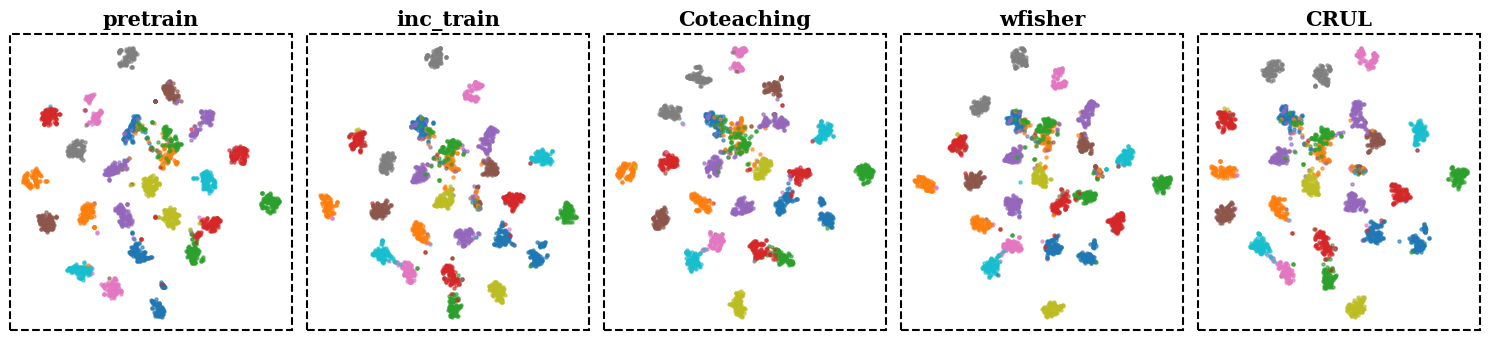

In [8]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)


import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging

os.environ["CUDA_VISIBLE_DEVICES"] = "7"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up logging for better visibility
logging.basicConfig(level=logging.INFO, format='\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m')
logger = logging.getLogger(__name__)


class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]
    
def get_model_path(dataset_name, model_name, method):
    
    # TODO-241105 [sunzekun] 新的参数读取路径规则，先做初步测试用，对各个数据集需要分别根据文档的设定手写case（主要变的是noise_ratio)
    base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_0.25_nt_asymmetric_cvpr"
    if method == 'pretrain':
        return f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth"
    elif method == 'inc_train':
        return os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth")
    else:
        return os.path.join(base_ckpt_path, method, f"{model_name}_restore.pth")
    
    
def load_model_and_data(
    dataset_name, model_name, method
):
    """
    加载模型及其对应的测试数据集，并返回模型和数据加载器
    """
    # 更改数据集为 pet-37
    # dataset_name = "pet-37"  # 使用 Oxford-IIIT Pet 数据集
    

    num_classes = settings.num_classes_dict[dataset_name]

    # 加载测试数据集
    # Load test dataset
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}")
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return


    # 加载模型    
    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(f"Currently testing dataset: {dataset_name} with {num_classes} classes.")

    model_path = get_model_path(dataset_name, model_name, method)
    logger.info(f"Evaluating model from path: {model_path}")

    # Load model architecture and weights
    model = load_custom_model(model_name, num_classes, load_pretrained=False)
    model = ClassifierWrapper(model, num_classes)
    try:
        checkpoint = torch.load(model_path, map_location=device)
        logger.info(f"Loaded model checkpoint from {model_path}")
    except FileNotFoundError:
        logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
        return
    model.load_state_dict(checkpoint, strict=False)
    
    model.eval()
    model.to(device)

    return model, test_dataloader, test_labels

# 获取嵌入数据
def get_embeddings(model, dataloader, layer_name="feature_model"):
    """
    提取模型的嵌入层输出
    """
    embeddings = []
    labels = []

    # 注册hook来捕获指定层的输出
    def hook_fn(module, input, output):
        embeddings.append(output.detach().cpu().numpy())

    handle = model._modules.get(layer_name).register_forward_hook(hook_fn)

    # 进行前向传播以获取嵌入
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            model(inputs)
            labels.extend(targets.cpu().numpy())

    handle.remove()

    # 拼接所有批次的嵌入和标签
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.array(labels)
    return embeddings, labels

def get_cache_path_tsne(dataset_name, case, unique_name):
    root_dir = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))

    path = os.path.join(
        root_dir,
        "result_analysis/results_cvpr/tsne",
        dataset_name,
        case,
        unique_name,
    )
    os.makedirs(path, exist_ok=True)

    return os.path.join(path, f"tsne.npz")

# 绘制 t-SNE
def get_tsne(model, dataloader, class_range=None):
    """
    绘制多个step的t-SNE结果，展示不同方法在不同步骤的嵌入变化
    """
    embeddings, labels = get_embeddings(model, dataloader)

    if class_range is not None:
        mask = np.isin(labels, class_range)
        embeddings = embeddings[mask]
        labels = labels[mask]

    # PCA 降维
    pca = PCA(n_components=50)
    pca_result = pca.fit_transform(embeddings)

    # t-SNE降维
    tsne = TSNE(n_components=2, n_jobs=8, random_state=42)
    tsne_result = tsne.fit_transform(pca_result)

    return tsne_result, labels

def plot_tsne(
    methods, dataset_name, model_name, noise_type, class_range=None, title=None, use_cache=False
):
    # 本实验中简化了case的使用，直接改为由noise-type来决定特定的名字（有需要再换回去）   
    case = "sym" if noise_type == "symmetric" else "asym"

    plt.style.use("default")
    fig, axs = plt.subplots(1, len(methods), figsize=(3 * len(methods), 3.5))
    fig.subplots_adjust(hspace=0.6, wspace=0.6)  # 增加子图之间的边距，保证美观

    tsne_results_all = {}

    for method in methods:
        model = None
        dataloader = None
        cache_path = get_cache_path_tsne(
            dataset_name=dataset_name, case=case, unique_name=method
        )
        if use_cache:
            try:
                data = np.load(cache_path)
                tsne = data["tsne"]
                labels = data["labels"]
                print(f"读取缓存的tsne记录：{cache_path}")
            except FileNotFoundError:
                print(
                    "未读取到对应的tsne。首次评估某个模型时，请先使用use_cache=False"
                )
                if model is None or dataloader is None:
                    model, dataloader, _ = load_model_and_data(
                        dataset_name, model_name, method
                    )
                tsne, labels = get_tsne(
                    model, dataloader, class_range
                )
                np.savez(cache_path, tsne=tsne, labels=labels)
                print(f"缓存tsne结果至：{cache_path}")
            tsne_results_all[method] = (tsne, labels)
        else:
            if model is None or dataloader is None:
                model, dataloader, _ = load_model_and_data(
                    dataset_name, model_name, method
                )
            tsne, labels = get_tsne(
                model, dataloader, class_range
            )
            np.savez(cache_path, tsne=tsne, labels=labels)
            print(f"缓存tsne结果至：{cache_path}")
            tsne_results_all[method] = (tsne, labels)


    # Plotting t-SNE results for the specified class range
    for method_idx, method in enumerate(methods):
        ax = axs[method_idx]
        tsne_result, labels = tsne_results_all.get(method, (None, None))
        if tsne_result is not None:
            unique_labels = np.unique(labels)
            for class_label in unique_labels:
                class_mask = labels == class_label
                ax.scatter(tsne_result[class_mask, 0], tsne_result[class_mask, 1], s=5, alpha=0.6, label=f'Class {class_label}')
            ax.set_title(f"{method}", fontsize=15, fontfamily="serif", weight="bold")
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.axis("off")
        else:
            ax.set_title(f"No data for {method}", fontsize=15, fontfamily="serif", weight="bold")
            ax.axis("off")

    # Adding dashed black border around each subplot for visual distinction
    for ax in axs.flat:
        rect = plt.Rectangle(
            (0, 0), 1, 1, transform=ax.transAxes, 
            color="black", linewidth=1.5, linestyle='--', fill=False, clip_on=False, zorder=10
        )
        ax.add_patch(rect)

    if title:
        title_fs = 15  # 标题的字号大小
        plt.suptitle(title, fontsize=title_fs, fontfamily="serif", weight="bold")
    plt.tight_layout()
    # plt.savefig(f'tsne_visualization_{method}_step_{step}_{noise_type}_{class_type}.pdf', format='pdf', dpi=300)
    plt.show()

# # 通用配置字典
# def configure_plot(dataset_name, model_name, methods, steps, noise_type, noise_ratio, class_type):
#     if class_type == "forget":
#         class_range = list(range(18))
#         title = "t-SNE Visualization for Forget Classes"
#     elif class_type == "noise":
#         class_range = list(range(18, 28))
#         title = "t-SNE Visualization for Noise Classes"
#     else:  # full
#         class_range = None
#         title = "t-SNE Visualization for All Classes"
#     return class_range, title

# 执行 t-SNE 可视化

methods = [ # baseline方法，包括一些预训练，增量训练(raw, 仅在d1上训练) 和基础的baseline
            # 'pretrain', 'inc_train', 'finetune',
            'pretrain', 'inc_train',
            # LNL方法
            # 'Coteaching', 'Coteachingplus', 'JoCoR', 'Decoupling', 'NegativeLearning', 'PENCIL',                
            'Coteaching',
            # MU 方法
            # 'raw', 'GA', 'GA_l1', 'FT', 'FT_l1', 'fisher_new', 'wfisher', 'FT_prune', 'FT_prune_bi', 'retrain', 'retrain_ls', 'retrain_sam',
            'wfisher',
            # 我们的方法
            'CRUL'
            ]
dataset_name = "pet-37"  # 更改为 pet-37 数据集
noise_type= "asymmetric"
model_name = "wideresnet50"  # 确保模型适配 pet-37 数据集

# class_range = list(range(5, 15))  # 只展示前10个类
# class_range = [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33] # 猫的类别
class_range = [1, 2, 3, 4, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 28, 29, 30, 31, 34, 35, 36] # 狗的类别
# class_range = [0, 5, 1, 29, 2, 24, 3, 17, 4, 17]  # mapping 关系中，配对的label。选取了前5组。

# class_range = None  # 只展示前10个类
title = None

plot_tsne(
    methods, dataset_name, model_name, noise_type, class_range=class_range, title=title, use_cache=False
)

# plot_tsne(
#     methods, dataset_name, model_name, noise_type, class_range=class_range, title=title, use_cache=True
# )



### cifar-10-sym

读取缓存的tsne记录：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/cifar-10/sym/pretrain/tsne.npz
读取缓存的tsne记录：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/cifar-10/sym/inc_train/tsne.npz
读取缓存的tsne记录：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/cifar-10/sym/Coteaching/tsne.npz
读取缓存的tsne记录：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/cifar-10/sym/wfisher/tsne.npz
读取缓存的tsne记录：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_cvpr/tsne/cifar-10/sym/CRUL/tsne.npz
10000
10000
10000
10000
10000


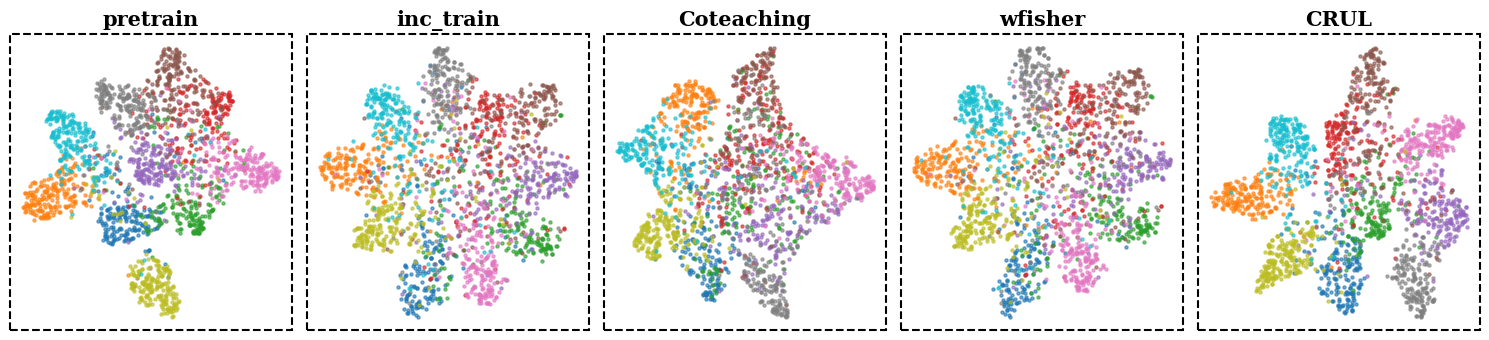

In [16]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

# 添加项目根目录到 sys.path
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(project_root)


import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from core_model.custom_model import ClassifierWrapper, load_custom_model
from configs import settings
import logging


os.environ["CUDA_VISIBLE_DEVICES"] = "7"  # 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up logging for better visibility
logging.basicConfig(level=logging.INFO, format='\033[1;36m%(asctime)s - %(levelname)s - %(message)s\033[0m')
logger = logging.getLogger(__name__)


class BaseTensorDataset(Dataset):
    def __init__(self, data, labels, transforms=None, device=None):
        self.data = torch.as_tensor(data, device=device)
        self.labels = torch.as_tensor(labels, device=device)
        self.transforms = transforms
        logger.info(f"Dataset initialized with data shape: {data.shape} and labels shape: {labels.shape}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transforms is not None:
            self.transforms(data)

        return data, self.labels[index]
    
def get_model_path(dataset_name, model_name, method):
    
    # TODO-241105 [sunzekun] 新的参数读取路径规则，先做初步测试用，对各个数据集需要分别根据文档的设定手写case（主要变的是noise_ratio)
    base_ckpt_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_0.25_nt_symmetric_cvpr"
    if method == 'pretrain':
        return f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/pretrain/{model_name}_pretrain.pth"
    elif method == 'inc_train':
        return os.path.join(base_ckpt_path, f"{model_name}_inc_train.pth")
    else:
        return os.path.join(base_ckpt_path, method, f"{model_name}_restore.pth")
    
    
def load_model_and_data(
    dataset_name, model_name, method
):
    """
    加载模型及其对应的测试数据集，并返回模型和数据加载器
    """
    # 更改数据集为 pet-37
    # dataset_name = "pet-37"  # 使用 Oxford-IIIT Pet 数据集
    

    num_classes = settings.num_classes_dict[dataset_name]

    # 加载测试数据集
    # Load test dataset
    batch_size = 64
    test_data_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_data.npy"
    test_label_path = f"/nvme/szh/code/tta-mr/data/{dataset_name}/gen/test_label.npy"

    try:
        logger.info(f"Loading test data from: {test_data_path}")
        test_data = np.load(test_data_path)
        test_labels = np.load(test_label_path)
        logger.info(f"Test data loaded with shape: {test_data.shape}, Test labels loaded with shape: {test_labels.shape}")
        test_dataset = BaseTensorDataset(test_data, test_labels, device=device)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    except FileNotFoundError as e:
        logger.error(f"Error loading test dataset: {e}")
        return


    # 加载模型    
    num_classes = settings.num_classes_dict[dataset_name]
    logger.info(f"Currently testing dataset: {dataset_name} with {num_classes} classes.")

    model_path = get_model_path(dataset_name, model_name, method)
    logger.info(f"Evaluating model from path: {model_path}")

    # Load model architecture and weights
    model = load_custom_model(model_name, num_classes, load_pretrained=False)
    model = ClassifierWrapper(model, num_classes)
    try:
        checkpoint = torch.load(model_path, map_location=device)
        logger.info(f"Loaded model checkpoint from {model_path}")
    except FileNotFoundError:
        logger.error(f"Cannot find the weight file at {model_path}. Skipping.")
        return
    model.load_state_dict(checkpoint, strict=False)
    
    model.eval()
    model.to(device)

    return model, test_dataloader, test_labels

# 获取嵌入数据
def get_embeddings(model, dataloader, layer_name="feature_model"):
    """
    提取模型的嵌入层输出
    """
    embeddings = []
    labels = []

    # 注册hook来捕获指定层的输出
    def hook_fn(module, input, output):
        embeddings.append(output.detach().cpu().numpy())

    handle = model._modules.get(layer_name).register_forward_hook(hook_fn)

    # 进行前向传播以获取嵌入
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            model(inputs)
            labels.extend(targets.cpu().numpy())

    handle.remove()

    # 拼接所有批次的嵌入和标签
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.array(labels)
    return embeddings, labels

def get_cache_path_tsne(dataset_name, case, unique_name):
    root_dir = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))

    path = os.path.join(
        root_dir,
        "result_analysis/results_cvpr/tsne",
        dataset_name,
        case,
        unique_name,
    )
    os.makedirs(path, exist_ok=True)

    return os.path.join(path, f"tsne.npz")

# 绘制 t-SNE
def get_tsne(model, dataloader, class_range=None):
    """
    绘制多个step的t-SNE结果，展示不同方法在不同步骤的嵌入变化
    """
    embeddings, labels = get_embeddings(model, dataloader)

    if class_range is not None:
        mask = np.isin(labels, class_range)
        embeddings = embeddings[mask]
        labels = labels[mask]

    # PCA 降维
    pca = PCA(n_components=50)
    pca_result = pca.fit_transform(embeddings)

    # t-SNE降维
    tsne = TSNE(n_components=2, n_jobs=8, random_state=42)
    tsne_result = tsne.fit_transform(pca_result)

    return tsne_result, labels

def plot_tsne(
    methods, dataset_name, model_name, noise_type, class_range=None, title=None, use_cache=False
):
    # 本实验中简化了case的使用，直接改为由noise-type来决定特定的名字（有需要再换回去）   
    case = "sym" if noise_type == "symmetric" else "asym"

    plt.style.use("default")
    fig, axs = plt.subplots(1, len(methods), figsize=(3 * len(methods), 3.5))
    fig.subplots_adjust(hspace=0.6, wspace=0.6)  # 增加子图之间的边距，保证美观

    tsne_results_all = {}

    for method in methods:
        model = None
        dataloader = None
        cache_path = get_cache_path_tsne(
            dataset_name=dataset_name, case=case, unique_name=method
        )
        if use_cache:
            try:
                data = np.load(cache_path)
                tsne = data["tsne"]
                labels = data["labels"]
                print(f"读取缓存的tsne记录：{cache_path}")
            except FileNotFoundError:
                print(
                    "未读取到对应的tsne。首次评估某个模型时，请先使用use_cache=False"
                )
                if model is None or dataloader is None:
                    model, dataloader, _ = load_model_and_data(
                        dataset_name, model_name, method
                    )
                tsne, labels = get_tsne(
                    model, dataloader, class_range
                )
                np.savez(cache_path, tsne=tsne, labels=labels)
                print(f"缓存tsne结果至：{cache_path}")
            tsne_results_all[method] = (tsne, labels)
        else:
            if model is None or dataloader is None:
                model, dataloader, _ = load_model_and_data(
                    dataset_name, model_name, method
                )
            tsne, labels = get_tsne(
                model, dataloader, class_range
            )
            np.savez(cache_path, tsne=tsne, labels=labels)
            print(f"缓存tsne结果至：{cache_path}")
            tsne_results_all[method] = (tsne, labels)


    # Plotting t-SNE results for the specified class range
    for method_idx, method in enumerate(methods):
        ax = axs[method_idx]
        tsne_result, labels = tsne_results_all.get(method, (None, None))
        # print(tsne_result.shape)

        # 尝试仅展示前k个点

        k = 1000
        tsne_result = tsne_result[:k]
        labels = labels[:k]


        if tsne_result is not None:
            unique_labels = np.unique(labels)
            for class_label in unique_labels:
                class_mask = labels == class_label
                ax.scatter(tsne_result[class_mask, 0], tsne_result[class_mask, 1], s=5, alpha=0.6, label=f'Class {class_label}')
            ax.set_title(f"{method}", fontsize=15, fontfamily="serif", weight="bold")
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.axis("off")
        else:
            ax.set_title(f"No data for {method}", fontsize=15, fontfamily="serif", weight="bold")
            ax.axis("off")

    # Adding dashed black border around each subplot for visual distinction
    for ax in axs.flat:
        rect = plt.Rectangle(
            (0, 0), 1, 1, transform=ax.transAxes, 
            color="black", linewidth=1.5, linestyle='--', fill=False, clip_on=False, zorder=10
        )
        ax.add_patch(rect)

    if title:
        title_fs = 15  # 标题的字号大小
        plt.suptitle(title, fontsize=title_fs, fontfamily="serif", weight="bold")
    plt.tight_layout()
    # plt.savefig(f'tsne_visualization_{method}_step_{step}_{noise_type}_{class_type}.pdf', format='pdf', dpi=300)
    plt.show()

# # 通用配置字典
# def configure_plot(dataset_name, model_name, methods, steps, noise_type, noise_ratio, class_type):
#     if class_type == "forget":
#         class_range = list(range(18))
#         title = "t-SNE Visualization for Forget Classes"
#     elif class_type == "noise":
#         class_range = list(range(18, 28))
#         title = "t-SNE Visualization for Noise Classes"
#     else:  # full
#         class_range = None
#         title = "t-SNE Visualization for All Classes"
#     return class_range, title

# 执行 t-SNE 可视化

methods = [ # baseline方法，包括一些预训练，增量训练(raw, 仅在d1上训练) 和基础的baseline
            # 'pretrain', 'inc_train', 'finetune',
            'pretrain', 'inc_train',
            # LNL方法
            # 'Coteaching', 'Coteachingplus', 'JoCoR', 'Decoupling', 'NegativeLearning', 'PENCIL',                
            'Coteaching',
            # MU 方法
            # 'raw', 'GA', 'GA_l1', 'FT', 'FT_l1', 'fisher_new', 'wfisher', 'FT_prune', 'FT_prune_bi', 'retrain', 'retrain_ls', 'retrain_sam',
            'wfisher',
            # 我们的方法
            'CRUL'
            ]

dataset_name = "cifar-10"  # 更改为 pet-37 数据集
noise_type= "symmetric"
model_name = "cifar-resnet18"  # 确保模型适配 pet-37 数据集

# class_range = list(range(10, 20))  # 只展示前10个类
class_range = None  # 都展示
title = None

# plot_tsne(
#     methods, dataset_name, model_name, noise_type, class_range=class_range, title=title, use_cache=False
# )

plot_tsne(
    methods, dataset_name, model_name, noise_type, class_range=class_range, title=title, use_cache=True
)



# 敏感度实验


In [ ]:
dataset_name = "pet-37"
model_name = "wideresnet50"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'contra']
steps: [0, 1, 2, 3]
"""
methods = ["raw", "Coteaching", "contra"]
steps = [i for i in range(4)]
# ------------------------------------------------------------- #
"""
指定结果存储的路径
"""
results_dir = "./results_sensitivity"
# ------------------------------------------------------------- #


for noise_ratio in [0.1, 0.3, 0.5]:
    # 分类任务评估
    results_dir = f"./results_sensitivity/nr_{noise_ratio}"
    eva_test_acc(
        dataset_name,
        model_name,
        noise_ratio=noise_ratio,
        noise_type="symmetric",
        methods=methods,
        steps=steps,
        results_dir=results_dir,
    )

    # 检测任务评估
    eva_map(
        dataset_name,
        model_name,
        noise_ratio=noise_ratio,
        noise_type="asymmetric",
        methods=methods,
        steps=steps,
        results_dir=results_dir,
    )

目前测试的数据集：pet-37, case模式：nr_0.1_nt_symmetric_balanced
Loading /nvme/sunzekun/Projects/tta-mr/data/pet-37/gen/nr_0.1_nt_symmetric_balanced/test_data.npy
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.1_nt_symmetric_balanced/step_0/raw/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/4186978523.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


test_acc: 91.25
label: 0, acc: 72.45
label: 1, acc: 93.00
label: 2, acc: 34.00
label: 3, acc: 89.00
label: 4, acc: 97.00
label: 5, acc: 90.00
label: 6, acc: 88.00
label: 7, acc: 98.86
label: 8, acc: 91.92
label: 9, acc: 83.00
label: 10, acc: 90.00
label: 11, acc: 93.81
label: 12, acc: 96.00
label: 13, acc: 98.00
label: 14, acc: 99.00
label: 15, acc: 96.00
label: 16, acc: 94.00
label: 17, acc: 100.00
label: 18, acc: 100.00
label: 19, acc: 99.00
label: 20, acc: 91.00
label: 21, acc: 95.00
label: 22, acc: 98.00
label: 23, acc: 91.00
label: 24, acc: 94.00
label: 25, acc: 99.00
label: 26, acc: 75.00
label: 27, acc: 86.00
label: 28, acc: 99.00
label: 29, acc: 100.00
label: 30, acc: 98.99
label: 31, acc: 99.00
label: 32, acc: 84.00
label: 33, acc: 95.00
label: 34, acc: 71.91
label: 35, acc: 95.00
label: 36, acc: 100.00
测试集Acc：0.9125102207686018
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.1_nt_symmetric_balanced/step_1/raw/wideresnet50_worker_restore.pth
test_acc: 88.63
label: 0

/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.1_nt_asymmetric_balanced/step_0/raw/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:03<00:00,  9.23it/s]


测试mAP：0.9251547409945474
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.1_nt_asymmetric_balanced/step_1/raw/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.9198157823843427
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.1_nt_asymmetric_balanced/step_2/raw/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.913448720892312
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.1_nt_asymmetric_balanced/step_3/raw/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.9036711934276552


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.1_nt_asymmetric_balanced/step_0/Coteaching/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:03<00:00,  9.64it/s]


测试mAP：0.9251547409945474


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.1_nt_asymmetric_balanced/step_1/Coteaching/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:03<00:00,  9.62it/s]


测试mAP：0.7416686916355228
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.1_nt_asymmetric_balanced/step_2/Coteaching/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:02<00:00,  9.

测试mAP：0.6821409025185032
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.1_nt_asymmetric_balanced/step_3/Coteaching/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:02<00:00,  9.

测试mAP：0.603352180166253
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.1_nt_asymmetric_balanced/step_0/contra/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:02<00:00,  9.

测试mAP：0.9251547409945474


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.1_nt_asymmetric_balanced/step_1/contra/wideresnet50_worker_tta.pth


100%|██████████| 29/29 [00:02<00:00,  9.72it/s]


测试mAP：0.9215156522568851


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.1_nt_asymmetric_balanced/step_2/contra/wideresnet50_worker_tta.pth


100%|██████████| 29/29 [00:03<00:00,  9.57it/s]


测试mAP：0.92407167682443


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.1_nt_asymmetric_balanced/step_3/contra/wideresnet50_worker_tta.pth


100%|██████████| 29/29 [00:02<00:00,  9.83it/s]


测试mAP：0.9263637295489346
目前测试的数据集：pet-37, case模式：nr_0.3_nt_symmetric_balanced
Loading /nvme/sunzekun/Projects/tta-mr/data/pet-37/gen/nr_0.3_nt_symmetric_balanced/test_data.npy
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.3_nt_symmetric_balanced/step_0/raw/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/4186978523.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


test_acc: 91.25
label: 0, acc: 72.45
label: 1, acc: 93.00
label: 2, acc: 34.00
label: 3, acc: 89.00
label: 4, acc: 97.00
label: 5, acc: 90.00
label: 6, acc: 88.00
label: 7, acc: 98.86
label: 8, acc: 91.92
label: 9, acc: 83.00
label: 10, acc: 90.00
label: 11, acc: 93.81
label: 12, acc: 96.00
label: 13, acc: 98.00
label: 14, acc: 99.00
label: 15, acc: 96.00
label: 16, acc: 94.00
label: 17, acc: 100.00
label: 18, acc: 100.00
label: 19, acc: 99.00
label: 20, acc: 91.00
label: 21, acc: 95.00
label: 22, acc: 98.00
label: 23, acc: 91.00
label: 24, acc: 94.00
label: 25, acc: 99.00
label: 26, acc: 75.00
label: 27, acc: 86.00
label: 28, acc: 99.00
label: 29, acc: 100.00
label: 30, acc: 98.99
label: 31, acc: 99.00
label: 32, acc: 84.00
label: 33, acc: 95.00
label: 34, acc: 71.91
label: 35, acc: 95.00
label: 36, acc: 100.00
测试集Acc：0.9125102207686018
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.3_nt_symmetric_balanced/step_1/raw/wideresnet50_worker_restore.pth
test_acc: 89.89
label: 0

/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.3_nt_asymmetric_balanced/step_0/raw/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:03<00:00,  9.58it/s]


测试mAP：0.9251547409945474


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.3_nt_asymmetric_balanced/step_1/raw/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:03<00:00,  9.29it/s]


测试mAP：0.9151363047263059
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.3_nt_asymmetric_balanced/step_2/raw/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.9119056926067319
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.3_nt_asymmetric_balanced/step_3/raw/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.9035095706892633


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.3_nt_asymmetric_balanced/step_0/Coteaching/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:03<00:00,  8.77it/s]


测试mAP：0.9251547409945474
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.3_nt_asymmetric_balanced/step_1/Coteaching/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.7354506787270191


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.3_nt_asymmetric_balanced/step_2/Coteaching/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:03<00:00,  9.10it/s]


测试mAP：0.6565864257360171
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.3_nt_asymmetric_balanced/step_3/Coteaching/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  8.

测试mAP：0.5653208744936655
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.3_nt_asymmetric_balanced/step_0/contra/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.9251547409945474


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.3_nt_asymmetric_balanced/step_1/contra/wideresnet50_worker_tta.pth


100%|██████████| 29/29 [00:03<00:00,  9.63it/s]


测试mAP：0.9285543929699517
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.3_nt_asymmetric_balanced/step_2/contra/wideresnet50_worker_tta.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:02<00:00,  9.

测试mAP：0.9268385961407367


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.3_nt_asymmetric_balanced/step_3/contra/wideresnet50_worker_tta.pth


100%|██████████| 29/29 [00:02<00:00,  9.70it/s]


测试mAP：0.9194653868911565
目前测试的数据集：pet-37, case模式：nr_0.5_nt_symmetric_balanced
Loading /nvme/sunzekun/Projects/tta-mr/data/pet-37/gen/nr_0.5_nt_symmetric_balanced/test_data.npy
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.5_nt_symmetric_balanced/step_0/raw/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/4186978523.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


test_acc: 91.25
label: 0, acc: 72.45
label: 1, acc: 93.00
label: 2, acc: 34.00
label: 3, acc: 89.00
label: 4, acc: 97.00
label: 5, acc: 90.00
label: 6, acc: 88.00
label: 7, acc: 98.86
label: 8, acc: 91.92
label: 9, acc: 83.00
label: 10, acc: 90.00
label: 11, acc: 93.81
label: 12, acc: 96.00
label: 13, acc: 98.00
label: 14, acc: 99.00
label: 15, acc: 96.00
label: 16, acc: 94.00
label: 17, acc: 100.00
label: 18, acc: 100.00
label: 19, acc: 99.00
label: 20, acc: 91.00
label: 21, acc: 95.00
label: 22, acc: 98.00
label: 23, acc: 91.00
label: 24, acc: 94.00
label: 25, acc: 99.00
label: 26, acc: 75.00
label: 27, acc: 86.00
label: 28, acc: 99.00
label: 29, acc: 100.00
label: 30, acc: 98.99
label: 31, acc: 99.00
label: 32, acc: 84.00
label: 33, acc: 95.00
label: 34, acc: 71.91
label: 35, acc: 95.00
label: 36, acc: 100.00
测试集Acc：0.9125102207686018
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.5_nt_symmetric_balanced/step_1/raw/wideresnet50_worker_restore.pth
test_acc: 89.07
label: 0

/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.9251547409945474


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_balanced/step_1/raw/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:03<00:00,  9.54it/s]


测试mAP：0.913021330401577
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_balanced/step_2/raw/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.9072505482235897
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_balanced/step_3/raw/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.894035129486417
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_balanced/step_0/Coteaching/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:02<00:00,  9.

测试mAP：0.9251547409945474
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_balanced/step_1/Coteaching/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.7173052690358317
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_balanced/step_2/Coteaching/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.6595015216043718
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_balanced/step_3/Coteaching/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.5730663623852781
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_balanced/step_0/contra/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.9251547409945474
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_balanced/step_1/contra/wideresnet50_worker_tta.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.9237768060622593
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_balanced/step_2/contra/wideresnet50_worker_tta.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:02<00:00,  9.

测试mAP：0.9246562816979451
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.5_nt_asymmetric_balanced/step_3/contra/wideresnet50_worker_tta.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:02<00:00,  9.

测试mAP：0.9275902209227674


> 结果绘图


In [ ]:
def visualize(results_file_path, type="cls"):
    data = pd.read_csv(results_file_path, index_col=0)
    plt.figure(figsize=(4, 4))
    # fig, ax = plt.subplots(figsize=(4, 5))
    ax = plt.gca()
    ax.set_facecolor("#EAEAF2")
    # color_list = ['#696969', '#2799B2', '#4DA764']

    lw = 2
    ms = 10  # marker_size
    tfs = 12  # tick font size

    plt.plot(
        data.columns,
        data.loc["raw"],
        label="raw",
        color="#696969",
        linestyle="--",
        linewidth=lw,
        marker="o",
        markersize=ms,
    )  # Grey dashed line
    plt.plot(
        data.columns,
        data.loc["Coteaching"],
        label="coteaching",
        color="#2799B2",
        linewidth=lw,
        marker="^",
        markersize=ms,
    )  # Blue solid line
    plt.plot(
        data.columns,
        data.loc["contra"],
        label="contra",
        color="#4DA764",
        linewidth=lw,
        marker="s",
        markersize=ms,
    )  # Green solid line

    # for i, label in enumerate(data.index):
    #     plt.plot(data.columns, data.loc[label], label=label, color=color_list[i])

    if type == "cls":

        # plt.yticks(np.arange(0.75, 0.96, 0.05), [''] * len(np.arange(0.75, 0.96, 0.05)), fontsize=tfs, rotation=90, va='center', fontfamily="serif", weight="bold")
        plt.yticks(
            np.arange(0.25, 0.95, 0.2),
            fontsize=tfs,
            rotation=90,
            va="center",
            fontfamily="serif",
            weight="bold",
        )
    else:
        plt.yticks(
            np.arange(0.5, 0.95, 0.15),
            fontsize=tfs,
            rotation=90,
            va="center",
            fontfamily="serif",
            weight="bold",
        )

    plt.xticks(fontsize=tfs, fontfamily="serif", weight="bold")
    # plt.title('Performance Comparison')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.legend()
    plt.grid(True, color="white")

    # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)

    # plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    # plt.axis('off')
    # plt.margins(0,0)
    # plt.tight_layout()

    plt.show()

Visualizing ./results_sensitivity/nr_0.1/pet-37_cls.csv


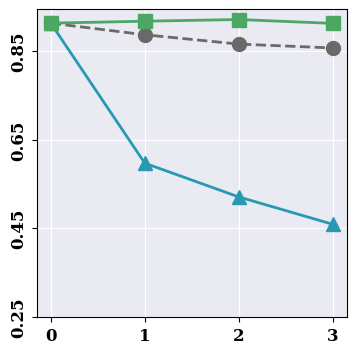

Visualizing ./results_sensitivity/nr_0.3/pet-37_cls.csv


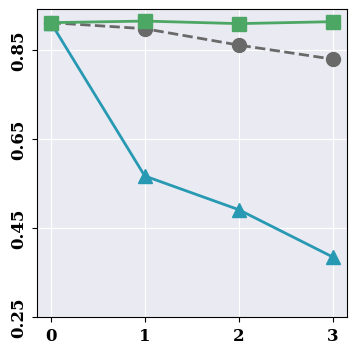

Visualizing ./results_sensitivity/nr_0.5/pet-37_cls.csv


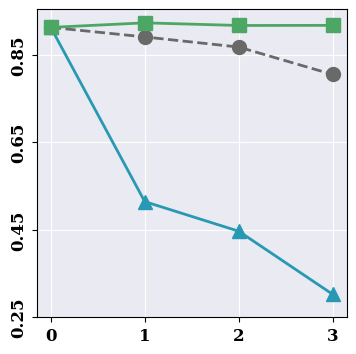

Visualizing ./results_sensitivity/nr_0.1/pet-37_rtv.csv


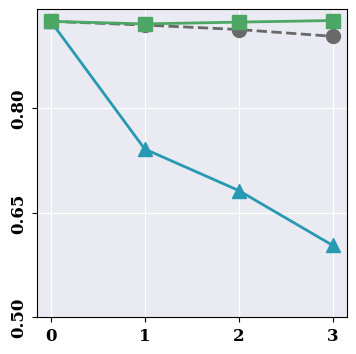

Visualizing ./results_sensitivity/nr_0.3/pet-37_rtv.csv


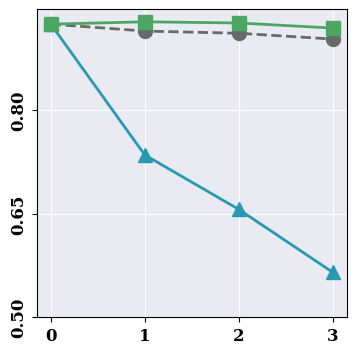

Visualizing ./results_sensitivity/nr_0.5/pet-37_rtv.csv


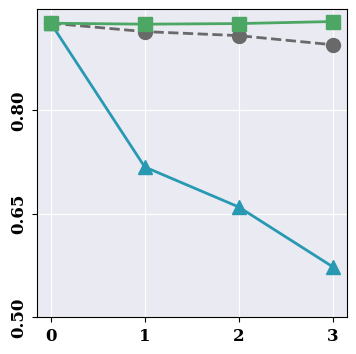

In [28]:
# results_file_path = f'./results_sensitivity/nr_0.1/pet-37_cls.csv'
# visualize(results_file_path)
for noise_ratio in [0.1, 0.3, 0.5]:
    results_file_path = f"./results_sensitivity/nr_{noise_ratio}/pet-37_cls.csv"
    print(f"Visualizing {results_file_path}")
    visualize(results_file_path)


for noise_ratio in [0.1, 0.3, 0.5]:
    results_file_path = f"./results_sensitivity/nr_{noise_ratio}/pet-37_rtv.csv"
    print(f"Visualizing {results_file_path}")
    visualize(results_file_path, type="rtv")

# 消融实验


> 分类任务（Pet-37)


In [ ]:
dataset_name = "pet-37"
model_name = "wideresnet50"
noise_type = "symmetric"

"""
注意！！！
这个函数使用之前记得去get_suffix里边进行相应代码的切换
因为它的读取策略和普通的实验不同。
"""
# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['contra_repair_only', 'contra_tta_only']
steps: [0, 1, 2, 3]
"""

# methods = ['contra', 'contra_tta_only'] # 其中contra会返回worker_restore的结果，这个是restore-only，而后面那个是tta_only
methods = ["contra_tta_only"]
# methods = ['contra']
steps = [i for i in range(4)]
# ------------------------------------------------------------- #
"""
指定结果存储的路径
"""
results_dir = "./results_ablation"
# ------------------------------------------------------------- #

eva_test_acc(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    results_dir=results_dir,
)

目前测试的数据集：pet-37, case模式：nr_0.2_nt_symmetric_balanced
Loading /nvme/sunzekun/Projects/tta-mr/data/pet-37/gen/nr_0.2_nt_symmetric_balanced/test_data.npy
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_symmetric_balanced/step_0/contra_tta_only/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/4186978523.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


test_acc: 91.25
label: 0, acc: 72.45
label: 1, acc: 93.00
label: 2, acc: 34.00
label: 3, acc: 89.00
label: 4, acc: 97.00
label: 5, acc: 90.00
label: 6, acc: 88.00
label: 7, acc: 98.86
label: 8, acc: 91.92
label: 9, acc: 83.00
label: 10, acc: 90.00
label: 11, acc: 93.81
label: 12, acc: 96.00
label: 13, acc: 98.00
label: 14, acc: 99.00
label: 15, acc: 96.00
label: 16, acc: 94.00
label: 17, acc: 100.00
label: 18, acc: 100.00
label: 19, acc: 99.00
label: 20, acc: 91.00
label: 21, acc: 95.00
label: 22, acc: 98.00
label: 23, acc: 91.00
label: 24, acc: 94.00
label: 25, acc: 99.00
label: 26, acc: 75.00
label: 27, acc: 86.00
label: 28, acc: 99.00
label: 29, acc: 100.00
label: 30, acc: 98.99
label: 31, acc: 99.00
label: 32, acc: 84.00
label: 33, acc: 95.00
label: 34, acc: 71.91
label: 35, acc: 95.00
label: 36, acc: 100.00
测试集Acc：0.9125102207686018
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_symmetric_balanced/step_1/contra_tta_only/wideresnet50_worker_restore.pth
test_acc: 89

> 检索任务


In [ ]:
dataset_name = "pet-37"
model_name = "wideresnet50"
noise_type = "asymmetric"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
steps: [0, 1, 2, 3]
"""

# methods = ['contra', 'contra_tta_only'] # 其中contra会返回worker_restore的结果，这个是restore-only，而后面那个是tta_only
methods = ["contra_tta_only"]
steps = [i for i in range(4)]
# steps = [0]
# ------------------------------------------------------------- #
"""
指定结果存储的路径
"""
results_dir = "./results_ablation"
# ------------------------------------------------------------- #
eva_test_acc(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    results_dir=results_dir,
)
# eva_map(
#     dataset_name,
#     model_name,
#     noise_type,
#     methods=methods,
#     steps=steps,
#     results_dir=results_dir,
# )

# TNSE：主实验


CIFAR10 数据集


In [14]:
!pip install MulticoreTSNE

  Preparing metadata (setup.py) ... done
  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp38-cp38-linux_x86_64.whl size=62976 sha256=fd10d574d57b3f7888d460ecb17f6c072adb23a9cadcf48dd9e3681bd0d45e88
  Stored in directory: /home/suizhihao/.cache/pip/wheels/62/fc/a5/9a3b34382cf75f60f8840dba221425dbc1530ad2a5bd2786b8
Successfully built MulticoreTSNE
    numpy (>=1.19.*) ; python_version >= "3.7"
           ~~~~~~~^


In [34]:
import torch
import numpy as np
import os
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt


def load_model_and_data(
    dataset_name, model_name, step, method, noise_type, noise_ratio, layer_name="fc"
):
    """
    加载模型及其对应的测试数据集，并返回模型和数据加载器
    """
    # 构建数据集和模型的case
    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    )

    num_classes = settings.num_classes_dict[dataset_name]

    # 加载测试数据集
    batch_size = 64
    test_data, test_labels, test_dataloader = get_dataset_loader(
        dataset_name,
        "test",
        case,
        None,
        None,
        None,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,
    )

    # 加载模型
    model_suffix = get_suffix(method, step)
    model = load_custom_model(model_name, num_classes, load_pretrained=False)
    model = ClassifierWrapper(model, num_classes)

    # 生成正确的模型路径，增加 "cifar-" 前缀
    model_path = settings.get_ckpt_path(
        dataset_name,
        case,
        model_name,
        model_suffix=f"cifar-{model_suffix}",  # 增加 'cifar-' 前缀
        step=step,
        unique_name=method,
    )

    # 加载模型权重
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint, strict=False)
    model.eval()

    return model, test_dataloader


# 获取嵌入数据
def get_embeddings(model, dataloader, layer_name="fc"):
    """
    提取模型的嵌入层输出
    """
    embeddings = []

    # 注册hook来捕获指定层的输出
    def hook_fn(module, input, output):
        embeddings.append(output.detach().cpu().numpy())

    handle = model._modules.get(layer_name).register_forward_hook(hook_fn)

    # 进行前向传播以获取嵌入
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            model(inputs)

    handle.remove()

    # 拼接所有批次的嵌入
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings


# 绘制 t-SNE
def plot_tsne_contra(dataset_name, model_name, steps, methods, noise_type, noise_ratio):
    """
    绘制多个step的t-SNE结果，展示Contra方法在不同步骤的嵌入变化
    """
    all_embeddings = []
    all_labels = []

    # 遍历不同的steps和方法，获取模型嵌入
    for step in steps:
        model, dataloader = load_model_and_data(
            dataset_name, model_name, step, methods, noise_type, noise_ratio
        )
        embeddings = get_embeddings(model, dataloader)
        all_embeddings.append(embeddings)
        all_labels += [f"step_{step}"] * len(embeddings)

    # 将所有嵌入拼接
    embeddings_concat = np.concatenate(all_embeddings, axis=0)

    # PCA 降维
    pca = PCA(n_components=50)
    pca_result = pca.fit_transform(embeddings_concat)

    # t-SNE降维
    tsne = TSNE(n_components=2, n_jobs=8, random_state=42)
    tsne_result = tsne.fit_transform(pca_result)

    # 绘制结果
    plt.figure(figsize=(10, 10))
    unique_labels = list(set(all_labels))
    colors = plt.cm.get_cmap("tab10", len(unique_labels))

    for i, label in enumerate(unique_labels):
        indices = [j for j, lbl in enumerate(all_labels) if lbl == label]
        plt.scatter(
            tsne_result[indices, 0],
            tsne_result[indices, 1],
            label=label,
            color=colors(i),
            s=50,
            alpha=0.6,
        )

    plt.title(f"t-SNE of Contra on {dataset_name}", fontsize=20)
    plt.legend()
    plt.show()

In [35]:
# 执行 t-SNE 可视化
# steps = [0, 1, 2, 3]
steps = [1, 2, 3]
methods = 'contra'
dataset_name = 'cifar-10'
model_name = 'resnet18'
noise_type = 'symmetric'
noise_ratio = 0.2

plot_tsne_contra(
    dataset_name=dataset_name,
    model_name=model_name,
    steps=steps,
    methods=methods,
    noise_type=noise_type,
    noise_ratio=noise_ratio
)


Loading /nvme/szh/code/tta-mr/data/cifar-10/gen/nr_0.2_nt_symmetric_balanced/test_data.npy


/tmp/ipykernel_52083/130447157.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


FileNotFoundError: [Errno 2] No such file or directory: '/nvme/szh/code/tta-mr/ckpt/cifar-10/nr_0.2_nt_symmetric_balanced/step_1/contra/resnet18_cifar-worker_tta.pth'

# 混淆矩阵：对比实验

In [9]:
import torch
import numpy as np
import os

def predict_and_save_pet37(
    dataset_name,
    model_name,
    noise_type="asymmetric",
    noise_ratio=0.5,
    methods=None,
    steps=None,
    output_dir="predictions/",
):
    """
    使用 pet37 数据集对模型进行预测，并保存预测结果。
    """
    
    # 确保输出目录存在
    os.makedirs(output_dir, exist_ok=True)

    # 加载数据集相关参数
    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    )
    mean, std = None, None
    num_classes = settings.num_classes_dict[dataset_name]
    print(f"目前测试的数据集：{dataset_name}, case模式：{case}")

    # 读入测试数据集
    test_data, test_labels, test_dataloader = get_dataset_loader(
        dataset_name, "test", None, None, mean, std, batch_size=128, shuffle=False
    )

    assert methods is not None, "请指定要评估的方法"
    assert steps is not None, "请指定要评估的 step(实验组)"

    # 遍历每种方法和 step，进行预测
    for method in methods:
        for step in steps:
            # 构造模型路径
            base_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{noise_type}_balanced/step_{step}/{method}"
            
            # 根据文件名模式确定模型文件名
            if method == "contra":
                if step == 0:
                    model_file_name = "wideresnet50_worker_restore.pth"
                else:
                    model_file_name = "wideresnet50_worker_tta.pth"
            elif method in ["Coteaching", "Coteachingplus", "JoCoR", "cotta", "plf", "raw", "replay"]:
                model_file_name = "wideresnet50_worker_restore.pth"
            else:
                print(f"Unknown method: {method}, skipping...")
                continue
            
            # 完整模型路径
            model_repair_save_path = os.path.join(base_path, model_file_name)
            print(f"Evaluating {model_repair_save_path}")

            # 尝试加载模型
            if not os.path.exists(model_repair_save_path):
                print(f"Cannot find the weight file at {model_repair_save_path}. Just SKIP.")
                continue

            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)

            checkpoint = torch.load(model_repair_save_path)
            model.load_state_dict(checkpoint, strict=False)
            model.eval()

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)

            # 进行预测
            all_predictions = []

            with torch.no_grad():
                for inputs, _ in test_dataloader:
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    all_predictions.append(preds.cpu().numpy())

            # 将所有预测结果拼接并保存
            all_predictions = np.concatenate(all_predictions, axis=0)
            output_file = os.path.join(output_dir, f"{method}_step_{step}_predictions.npy")
            np.save(output_file, all_predictions)
            print(f"Predictions saved to {output_file}")

# 使用示例
dataset_name = "pet-37"
model_name = "wideresnet50"
methods = ["contra", "Coteaching", "Coteachingplus", "JoCoR", "cotta", "plf", "raw", "replay"]  # 需要评估的方法
steps = [0, 1, 2, 3]  # 评估的 steps
output_dir = "predictions_pet37"

predict_and_save_pet37(dataset_name, model_name, methods=methods, steps=steps, output_dir=output_dir)

目前测试的数据集：pet-37, case模式：nr_0.2_nt_asymmetric_balanced
Loading /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_0/contra/wideresnet50_worker_restore.pth


/tmp/ipykernel_93863/3031640693.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Predictions saved to predictions_pet37/contra_step_0_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/contra/wideresnet50_worker_tta.pth
Predictions saved to predictions_pet37/contra_step_1_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_2/contra/wideresnet50_worker_tta.pth
Predictions saved to predictions_pet37/contra_step_2_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/contra/wideresnet50_worker_tta.pth
Predictions saved to predictions_pet37/contra_step_3_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_0/Coteaching/wideresnet50_worker_restore.pth
Predictions saved to predictions_pet37/Coteaching_step_0_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/Coteaching/wideresnet50_worker_restore.pth
Predictions saved to predictions_pet37/Coteaching_

/tmp/ipykernel_93863/160249716.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


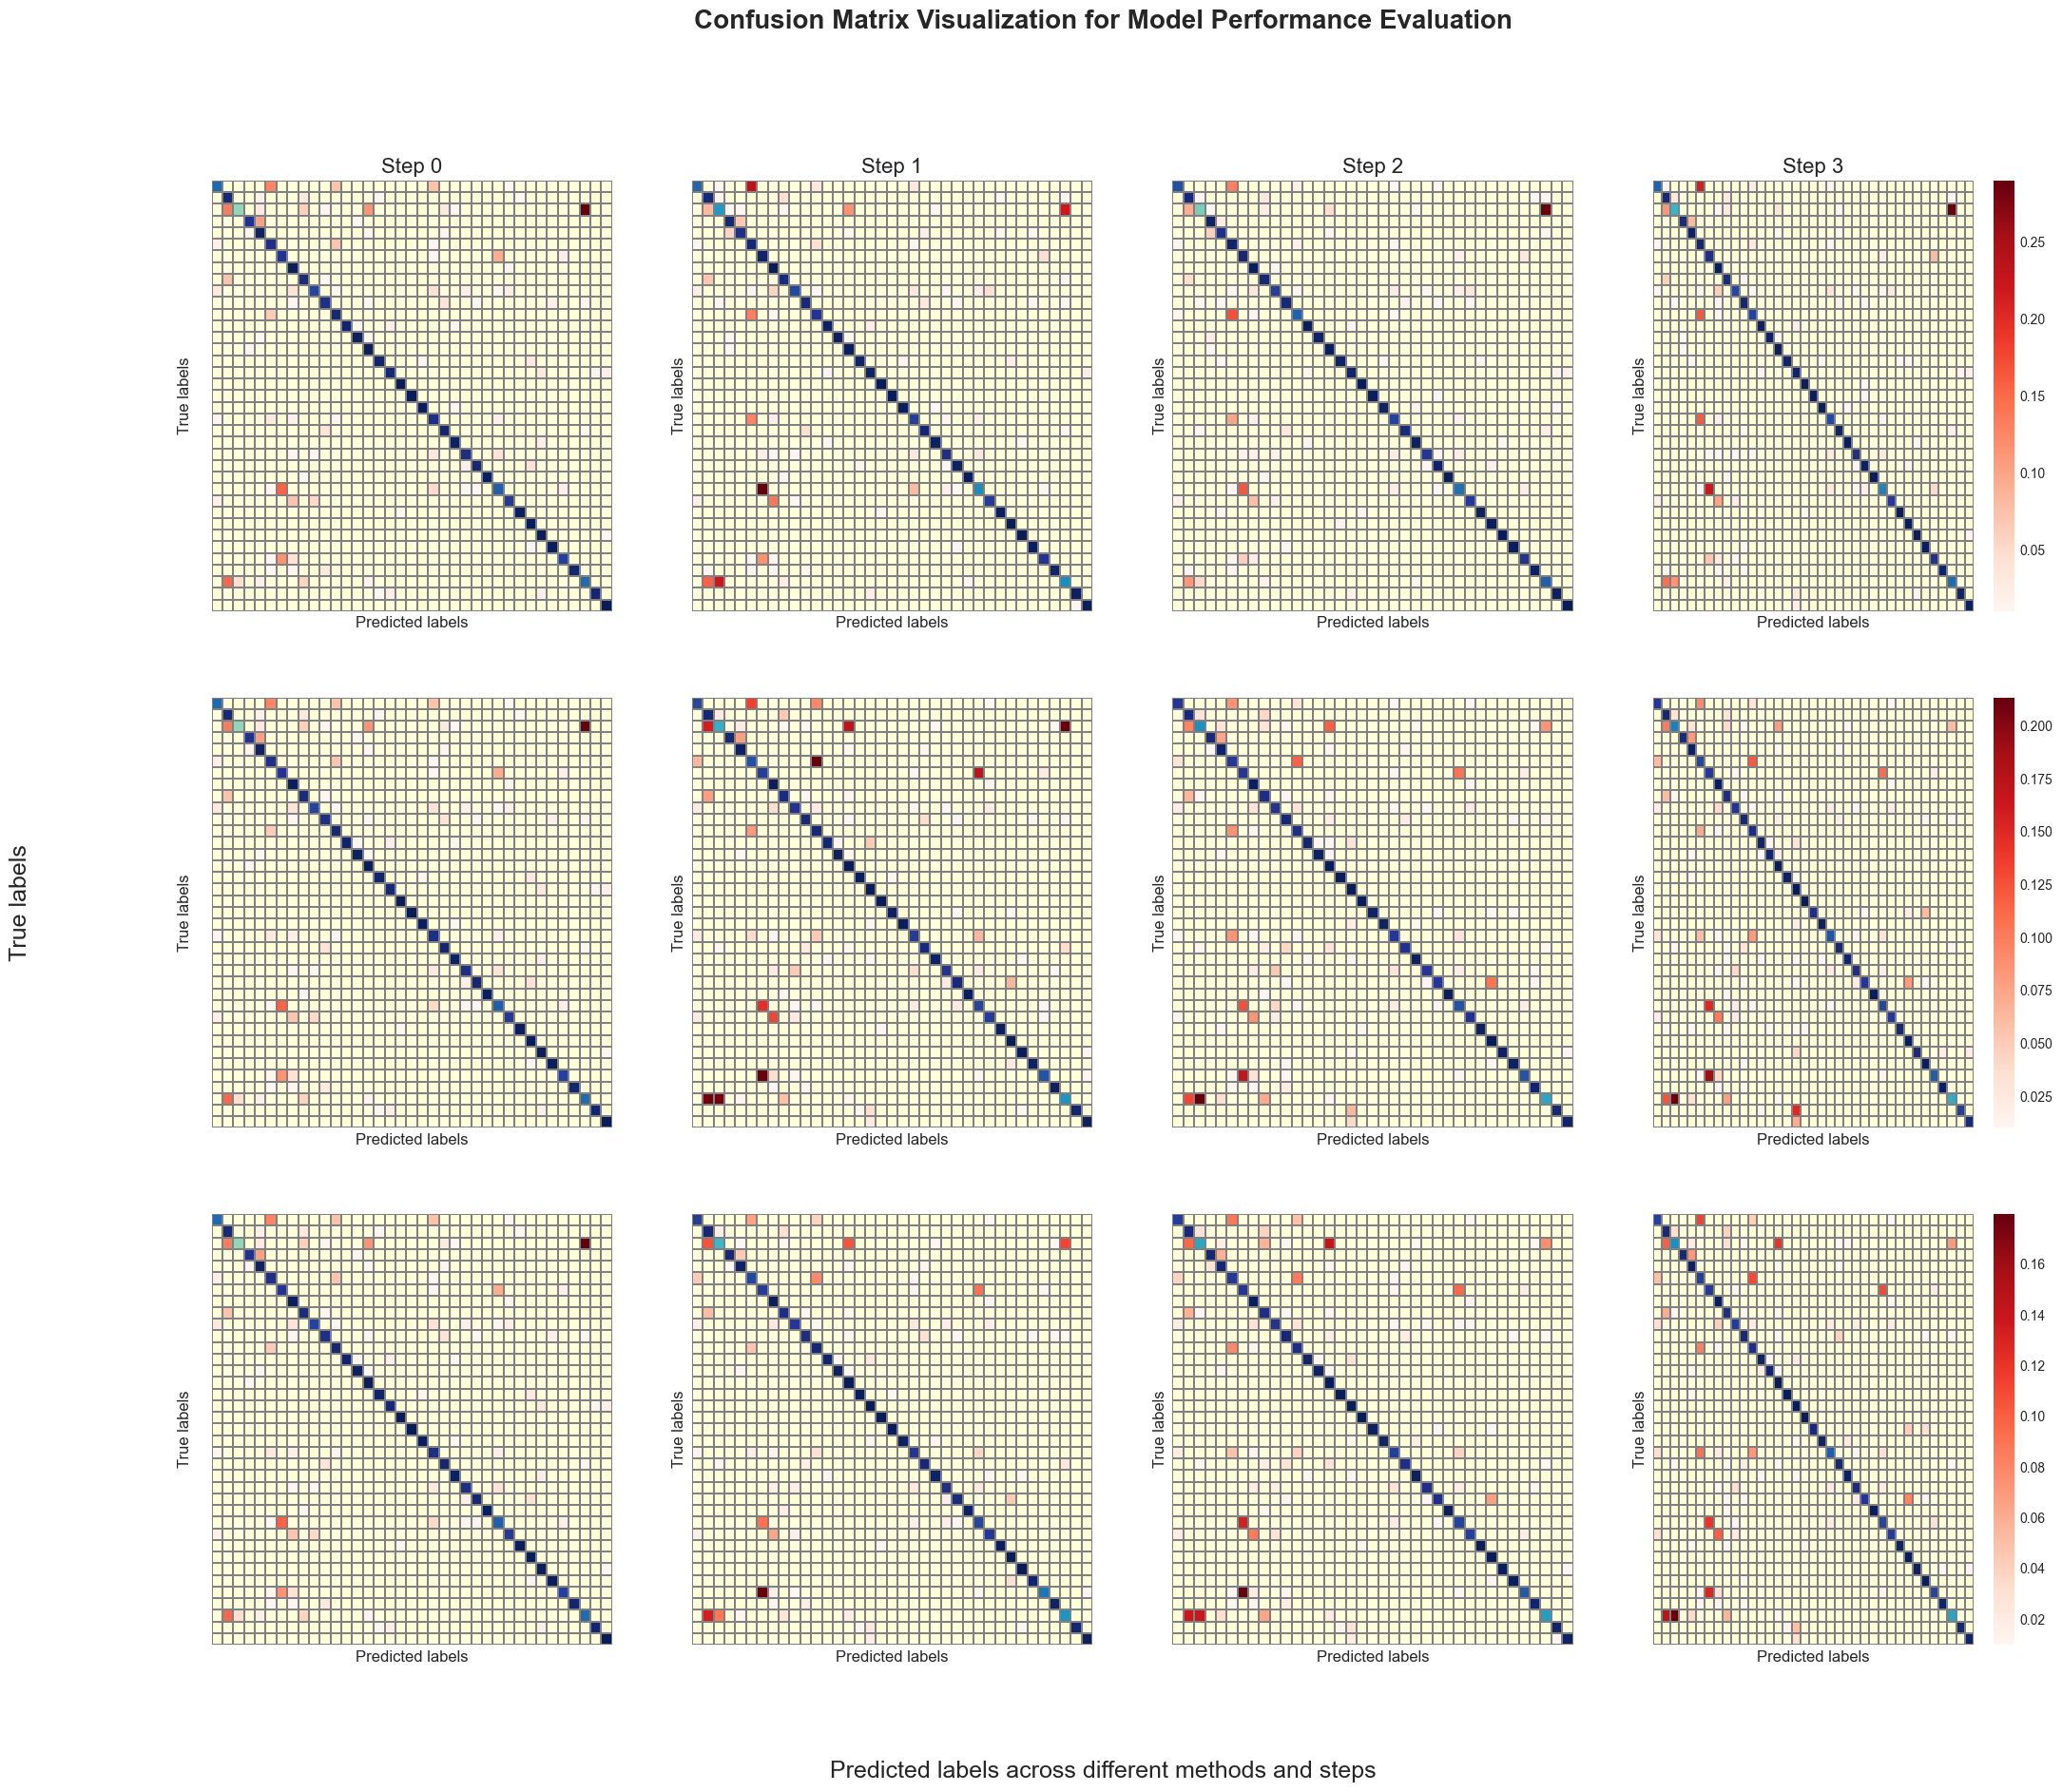

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 加载真实标签
true_labels_path = "/nvme/szh/code/tta-mr/data/pet-37/gen/test_label.npy"
true_labels = np.load(true_labels_path)

# 定义预测文件路径和方法
methods = ["contra", "Coteaching", "JoCoR"]
steps = [0, 1, 2, 3]
labels_order = list(range(37))  # 标签类别顺序（0 到 36）

# 设置绘图风格
plt.style.use("seaborn-white")

# 创建一个大画布
fig, axes = plt.subplots(len(methods), len(steps), figsize=(25, 20))

# 遍历每个方法和步骤
for method_idx, method in enumerate(methods):
    for step_idx, step in enumerate(steps):
        # 加载预测标签
        predictions_path = f"predictions_pet37/{method}_step_{step}_predictions.npy"
        predicted_labels = np.load(predictions_path)

        # 计算混淆矩阵（归一化到真实标签上）
        cm = confusion_matrix(true_labels, predicted_labels, labels=labels_order, normalize="true")

        # 创建新的矩阵以区分对视线和非对视线部分
        cm_diag = np.zeros_like(cm)
        cm_off_diag = np.zeros_like(cm)

        # 分离对视线和非对视线部分
        for i in range(len(labels_order)):
            for j in range(len(labels_order)):
                if i == j:
                    cm_diag[i, j] = cm[i, j]  # 对视线部分
                else:
                    cm_off_diag[i, j] = cm[i, j]  # 非对视线部分

        # 在对应的子图上绘制对视线部分（正确分类）
        ax = axes[method_idx, step_idx]
        sns.heatmap(
            cm_diag,
            annot=False,
            cmap="YlGnBu",  # 对视线部分使用浅色调，表示正确分类
            cbar=False,
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            linewidths=0.1,
            linecolor='gray'
        )

        # 绘制非对视线部分（错误分类）以增强误分类展示效果
        sns.heatmap(
            cm_off_diag,
            annot=False,
            cmap="Reds",  # 非对视线部分使用醒目的红色调，表示误分类
            cbar=(step_idx == len(steps) - 1),  # 最后一列添加颜色条
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            mask=(cm_off_diag == 0),  # 隐藏没有误分类的部分
            linewidths=0.1,
            linecolor='gray'
        )

        # 设置标题、标签
        if step_idx == 0:
            ax.set_ylabel(f"{method}", fontsize=16, labelpad=15)
        if method_idx == 0:
            ax.set_title(f"Step {step}", fontsize=16)
        ax.set_xlabel("Predicted labels", fontsize=12)
        ax.set_ylabel("True labels", fontsize=12)

        # 取消 x 和 y 的刻度，以减少杂乱
        ax.set_xticks([])
        ax.set_yticks([])

# # 调整整体布局
# plt.tight_layout(pad=3.0)
# plt.subplots_adjust(top=0.92)
# fig.suptitle("Confusion Matrices Across Methods and Steps", fontsize=24)

# 添加图注
fig.text(0.5, 0.04, 'Predicted labels across different methods and steps', ha='center', fontsize=18)
fig.text(0.04, 0.5, 'True labels', va='center', rotation='vertical', fontsize=18)
fig.text(0.5, 0.96, 'Confusion Matrix Visualization for Model Performance Evaluation', ha='center', fontsize=20, weight='bold')

# 保存为 PDF
plt.savefig("confusion_matrices_pet37.pdf", format="pdf")

# 显示结果
plt.show()

/tmp/ipykernel_93863/4272119692.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


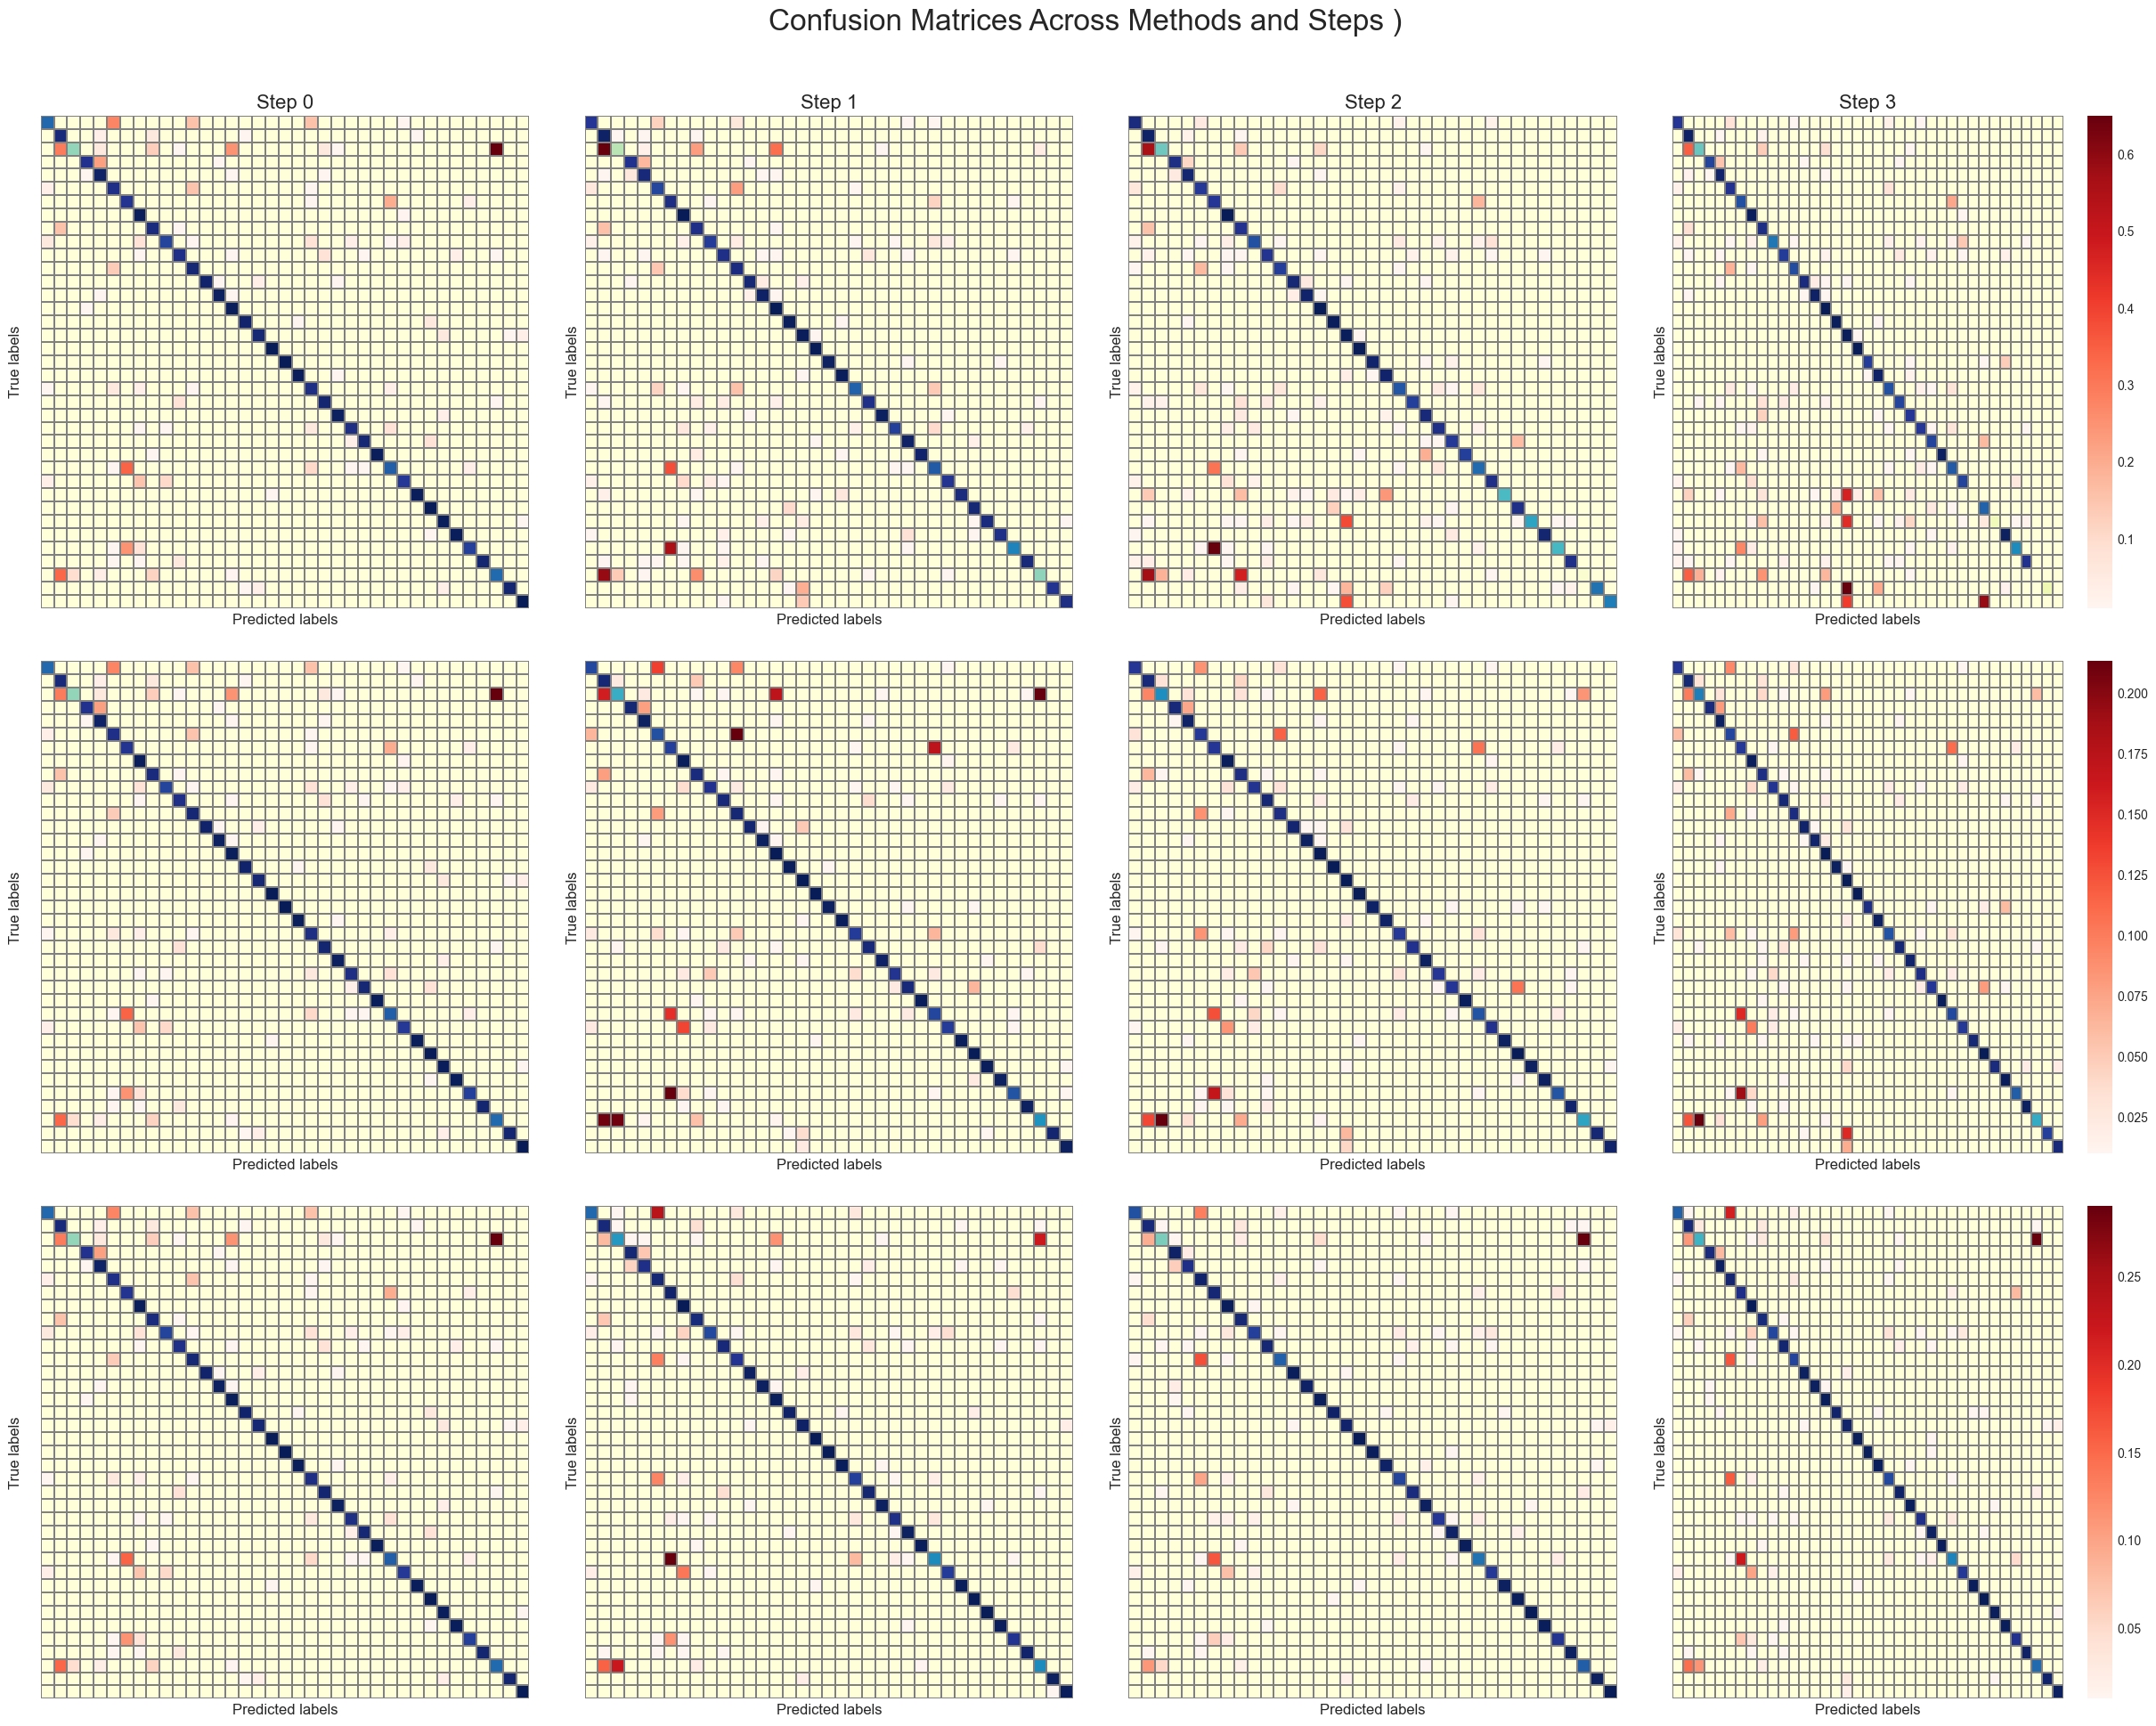

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 加载真实标签
true_labels_path = "/nvme/szh/code/tta-mr/data/pet-37/gen/test_label.npy"
true_labels = np.load(true_labels_path)

# 定义预测文件路径和方法
methods = ["raw", "Coteaching", "contra"]
# methods = ["contra", "Coteaching", "Coteachingplus", "JoCoR", "cotta", "plf", "raw", "replay"]  # 需要评估的方法

steps = [0, 1, 2, 3]
labels_order = list(range(37))  # 标签类别顺序（0 到 36）

# 设置绘图风格
plt.style.use("seaborn-white")

# 创建一个大画布
fig, axes = plt.subplots(len(methods), len(steps), figsize=(25, 20))

# 遍历每个方法和步骤
for method_idx, method in enumerate(methods):
    for step_idx, step in enumerate(steps):
        # 加载预测标签
        predictions_path = f"predictions_pet37/{method}_step_{step}_predictions.npy"
        predicted_labels = np.load(predictions_path)

        # 计算混淆矩阵（归一化到真实标签上）
        cm = confusion_matrix(true_labels, predicted_labels, labels=labels_order, normalize="true")

        # 创建新的矩阵以区分对角线和非对角线部分
        cm_diag = np.zeros_like(cm)
        cm_off_diag = np.zeros_like(cm)

        # 分离对角线和非对角线部分
        for i in range(len(labels_order)):
            for j in range(len(labels_order)):
                if i == j:
                    cm_diag[i, j] = cm[i, j]  # 对角线部分
                else:
                    cm_off_diag[i, j] = cm[i, j]  # 非对角线部分

        # 在对应的子图上绘制对角线部分（正确分类）
        ax = axes[method_idx, step_idx]
        sns.heatmap(
            cm_diag,
            annot=False,
            cmap="YlGnBu",  # 对角线部分使用浅色调，表示正确分类
            cbar=False,
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            linewidths=0.1,
            linecolor='gray'
        )

        # 绘制非对角线部分（错误分类）以增强误分类展示效果
        sns.heatmap(
            cm_off_diag,
            annot=False,
            cmap="Reds",  # 非对角线部分使用醒目的红色调，表示误分类
            cbar=(step_idx == len(steps) - 1),  # 最后一列添加颜色条
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            mask=(cm_off_diag == 0),  # 隐藏没有误分类的部分
            linewidths=0.1,
            linecolor='gray'
        )

        # 设置标题、标签
        if step_idx == 0:
            ax.set_ylabel(f"{method}", fontsize=16, labelpad=15)
        if method_idx == 0:
            ax.set_title(f"Step {step}", fontsize=16)
        ax.set_xlabel("Predicted labels", fontsize=12)
        ax.set_ylabel("True labels", fontsize=12)

        # 取消 x 和 y 的刻度，以减少杂乱
        ax.set_xticks([])
        ax.set_yticks([])

# 调整整体布局
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.92)
fig.suptitle("Confusion Matrices Across Methods and Steps )", fontsize=24)

# 显示结果
plt.show()


/tmp/ipykernel_93863/1834694111.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


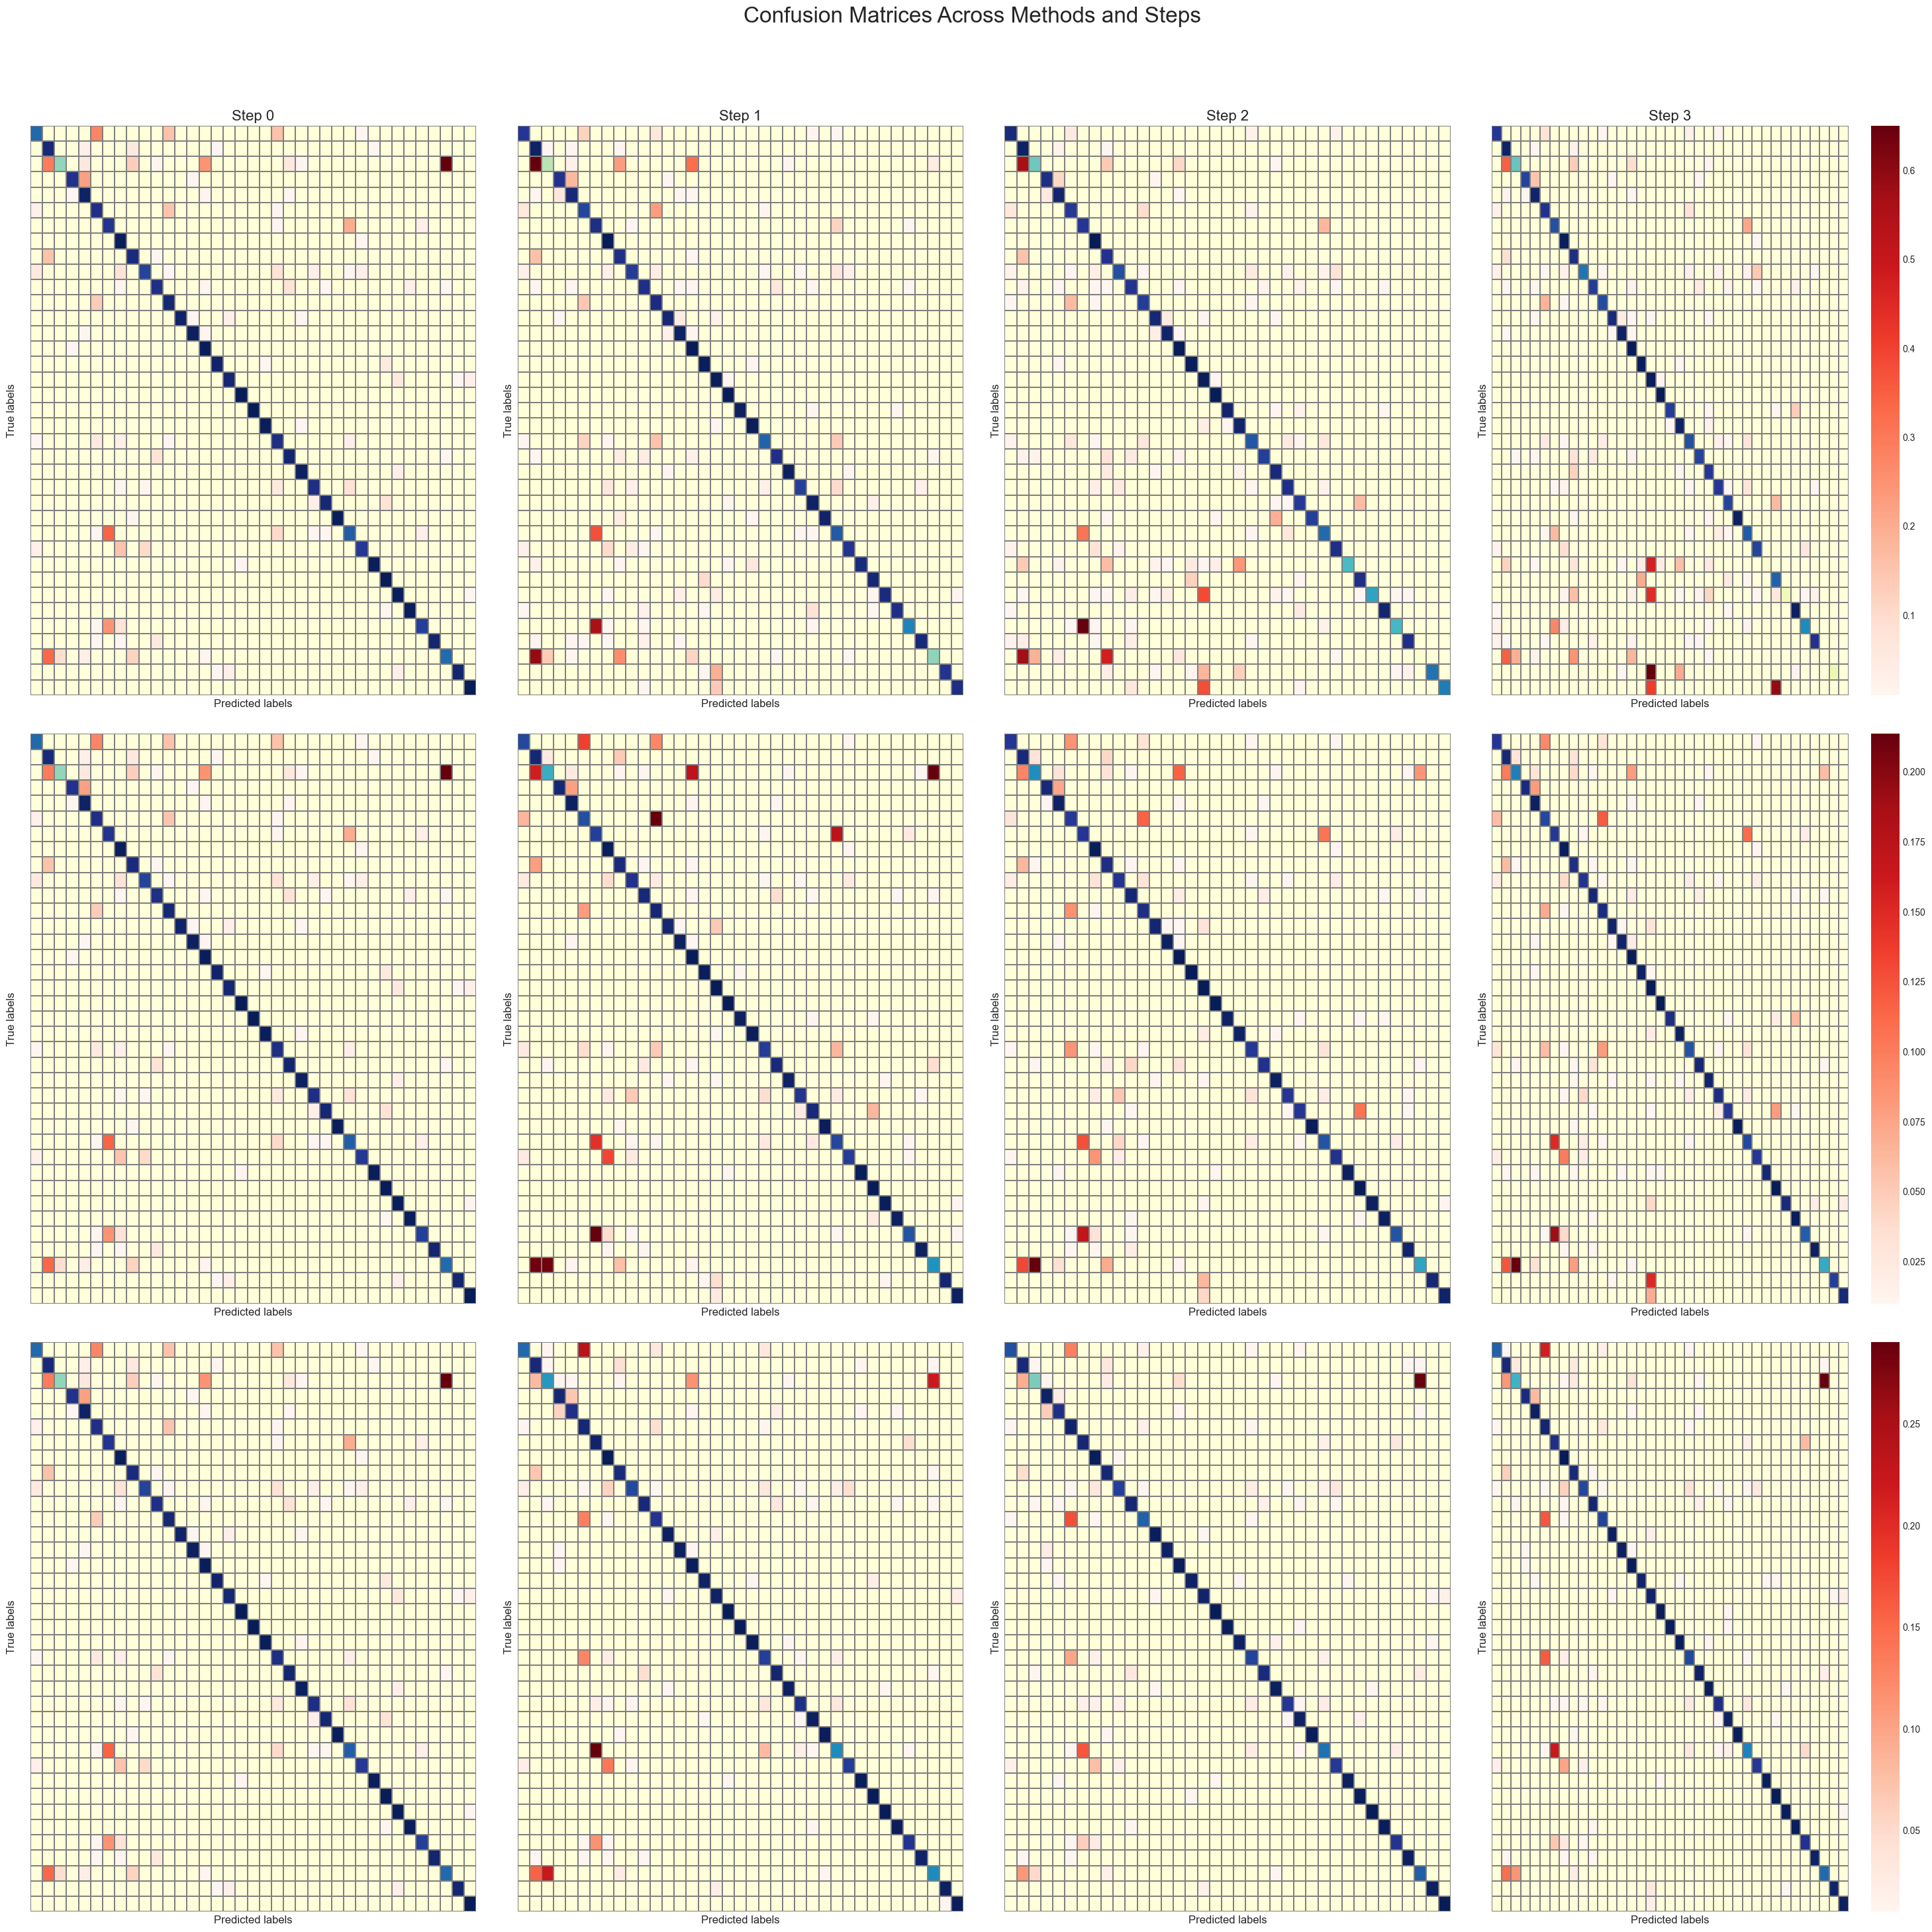

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 加载真实标签
true_labels_path = "/nvme/szh/code/tta-mr/data/pet-37/gen/test_label.npy"
true_labels = np.load(true_labels_path)

# 定义预测文件路径和方法
methods = ["raw", "Coteaching", "contra"]
steps = [0, 1, 2, 3]
labels_order = list(range(37))  # 标签类别顺序（0 到 36）

# 设置绘图风格
plt.style.use("seaborn-white")

# 创建一个大画布
fig, axes = plt.subplots(len(methods), len(steps), figsize=(30, 30))

# 遍历每个方法和步骤
method_labels = ["Standard", "Coteaching", "Contra"]
for method_idx, method in enumerate(methods):
    for step_idx, step in enumerate(steps):
        # 加载预测标签
        predictions_path = f"predictions_pet37/{method}_step_{step}_predictions.npy"
        predicted_labels = np.load(predictions_path)

        # 计算混淆矩阵（归一化到真实标签上）
        cm = confusion_matrix(true_labels, predicted_labels, labels=labels_order, normalize="true")

        # 创建新的矩阵以区分对视线和非对视线部分
        cm_diag = np.zeros_like(cm)
        cm_off_diag = np.zeros_like(cm)

        # 分离对视线和非对视线部分
        for i in range(len(labels_order)):
            for j in range(len(labels_order)):
                if i == j:
                    cm_diag[i, j] = cm[i, j]  # 对视线部分
                else:
                    cm_off_diag[i, j] = cm[i, j]  # 非对视线部分

        # 在对应的子图上绘制对视线部分（正确分类）
        ax = axes[method_idx, step_idx]
        sns.heatmap(
            cm_diag,
            annot=False,
            cmap="YlGnBu",  # 对视线部分使用浅色调，表示正确分类
            cbar=False,
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            linewidths=0.1,
            linecolor='gray'
        )

        # 绘制非对视线部分（错误分类）以增强误分类展示效果
        sns.heatmap(
            cm_off_diag,
            annot=False,
            cmap="Reds",  # 非对视线部分使用醒目的红色调，表示误分类
            cbar=(step_idx == len(steps) - 1),  # 最后一列添加颜色条
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            mask=(cm_off_diag == 0),  # 隐藏没有误分类的部分
            linewidths=0.1,
            linecolor='gray'
        )

        # 设置标题、标签
        if step_idx == 0:
            ax.set_ylabel(method_labels[method_idx], fontsize=16, labelpad=15)
        if method_idx == 0:
            ax.set_title(f"Step {step}", fontsize=16)
        ax.set_xlabel("Predicted labels", fontsize=12)
        ax.set_ylabel("True labels", fontsize=12)

        # 取消 x 和 y 的刻度，以减少杂乱
        ax.set_xticks([])
        ax.set_yticks([])

# 调整整体布局
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.92)
fig.suptitle("Confusion Matrices Across Methods and Steps", fontsize=24)

# # 添加图注
# fig.text(0.5, 0.04, 'Predicted labels across different methods and steps', ha='center', fontsize=18)
# fig.text(0.04, 0.5, 'True labels', va='center', rotation='vertical', fontsize=18)
# fig.text(0.5, 0.96, 'Confusion Matrix Visualization for Model Performance Evaluation', ha='center', fontsize=20, weight='bold')

# 保存为 PDF
plt.savefig("confusion_matrices_pet37.pdf", format="pdf")

# 保存为 PDF
plt.savefig("confusion_matrices_pet37.pdf", format="pdf")

# 显示结果
plt.show()

# 混淆矩阵：消融实验

In [ ]:
## step 1 pth files are:
# restore pth is:
# /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/contra_tta_only/wideresnet50_worker_restore.pth

# tta-only pth is:
# /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/contra_tta_only/wideresnet50_worker_tta.pth

# contra tta pth is:
# /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/contra/wideresnet50_worker_tta.pth

## step 2 and step 3 pth files are similar to step 1.


In [11]:
import torch
import numpy as np
import os

def predict_and_save_pet37(
    dataset_name,
    model_name,
    noise_type="asymmetric",
    noise_ratio=0.5,
    methods=None,
    steps=None,
    output_dir="predictions/",
):
    """
    使用 pet37 数据集对模型进行预测，并保存预测结果。
    """
    
    # 确保输出目录存在
    os.makedirs(output_dir, exist_ok=True)

    # 加载数据集相关参数
    case = settings.get_case(
        noise_ratio=noise_ratio, noise_type=noise_type, balanced=True
    )
    mean, std = None, None
    num_classes = settings.num_classes_dict[dataset_name]
    print(f"目前测试的数据集：{dataset_name}, case模式：{case}")

    # 读入测试数据集
    test_data, test_labels, test_dataloader = get_dataset_loader(
        dataset_name, "test", None, None, mean, std, batch_size=128, shuffle=False
    )

    assert methods is not None, "请指定要评估的方法"
    assert steps is not None, "请指定要评估的 step(实验组)"

    # 增加初始模型（step_0）的预测
    base_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{noise_type}_balanced/step_0/contra"
    model_file_name = "wideresnet50_worker_restore.pth"
    model_repair_save_path = os.path.join(base_path, model_file_name)
    print(f"Evaluating initial model from {model_repair_save_path}")

    # 尝试加载初始模型
    if not os.path.exists(model_repair_save_path):
        print(f"Cannot find the weight file at {model_repair_save_path}. Just SKIP.")
    else:
        model = load_custom_model(model_name, num_classes, load_pretrained=False)
        model = ClassifierWrapper(model, num_classes)

        checkpoint = torch.load(model_repair_save_path)
        model.load_state_dict(checkpoint, strict=False)
        model.eval()

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # 进行初始模型的预测
        all_predictions = []

        with torch.no_grad():
            for inputs, _ in test_dataloader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_predictions.append(preds.cpu().numpy())

        # 将所有预测结果拼接并保存
        all_predictions = np.concatenate(all_predictions, axis=0)
        output_file = os.path.join(output_dir, f"contra_step_0_predictions.npy")
        np.save(output_file, all_predictions)
        print(f"Predictions saved to {output_file}")

    # 遍历每种方法和 step，进行预测
    for method in methods:
        for step in steps:
            # 构造模型路径
            base_path = f"/nvme/szh/code/tta-mr/ckpt/{dataset_name}/nr_{noise_ratio}_nt_{noise_type}_balanced/step_{step}"
            
            # 根据步骤和方法确定模型文件名
            if step == 1:
                if method == "restore":
                    model_file_name = "contra_tta_only/wideresnet50_worker_restore.pth"
                elif method == "tta_only":
                    model_file_name = "contra_tta_only/wideresnet50_worker_tta.pth"
                elif method == "contra_tta":
                    model_file_name = "contra/wideresnet50_worker_tta.pth"
                else:
                    print(f"Unknown method: {method}, skipping...")
                    continue
            elif step in [2, 3]:
                if method == "restore":
                    model_file_name = "contra_tta_only/wideresnet50_worker_restore.pth"
                elif method == "tta_only":
                    model_file_name = "contra_tta_only/wideresnet50_worker_tta.pth"
                elif method == "contra_tta":
                    model_file_name = "contra/wideresnet50_worker_tta.pth"
                else:
                    print(f"Unknown method: {method}, skipping...")
                    continue
            else:
                print(f"Step {step} is not supported for method {method}, skipping...")
                continue
            
            # 完整模型路径
            model_repair_save_path = os.path.join(base_path, model_file_name)
            print(f"Evaluating {model_repair_save_path}")

            # 尝试加载模型
            if not os.path.exists(model_repair_save_path):
                print(f"Cannot find the weight file at {model_repair_save_path}. Just SKIP.")
                continue

            model = load_custom_model(model_name, num_classes, load_pretrained=False)
            model = ClassifierWrapper(model, num_classes)

            checkpoint = torch.load(model_repair_save_path)
            model.load_state_dict(checkpoint, strict=False)
            model.eval()

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)

            # 进行预测
            all_predictions = []

            with torch.no_grad():
                for inputs, _ in test_dataloader:
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    all_predictions.append(preds.cpu().numpy())

            # 将所有预测结果拼接并保存
            all_predictions = np.concatenate(all_predictions, axis=0)
            output_file = os.path.join(output_dir, f"{method}_step_{step}_predictions.npy")
            np.save(output_file, all_predictions)
            print(f"Predictions saved to {output_file}")

# 使用示例
dataset_name = "pet-37"
model_name = "wideresnet50"
methods = ["restore", "tta_only", "contra_tta"]  # 需要评估的消融实验方法
steps = [1, 2, 3]  # 评估的 steps
output_dir = "predictions_pet37_ablation"

predict_and_save_pet37(dataset_name, model_name, methods=methods, steps=steps, output_dir=output_dir)


目前测试的数据集：pet-37, case模式：nr_0.2_nt_asymmetric_balanced
Loading /nvme/szh/code/tta-mr/data/pet-37/gen/test_data.npy
Evaluating initial model from /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_0/contra/wideresnet50_worker_restore.pth


/tmp/ipykernel_220892/3454949625.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Predictions saved to predictions_pet37_ablation/contra_step_0_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/contra_tta_only/wideresnet50_worker_restore.pth


/tmp/ipykernel_220892/3454949625.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Predictions saved to predictions_pet37_ablation/restore_step_1_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_2/contra_tta_only/wideresnet50_worker_restore.pth
Predictions saved to predictions_pet37_ablation/restore_step_2_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/contra_tta_only/wideresnet50_worker_restore.pth
Predictions saved to predictions_pet37_ablation/restore_step_3_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/contra_tta_only/wideresnet50_worker_tta.pth
Predictions saved to predictions_pet37_ablation/tta_only_step_1_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_2/contra_tta_only/wideresnet50_worker_tta.pth
Predictions saved to predictions_pet37_ablation/tta_only_step_2_predictions.npy
Evaluating /nvme/szh/code/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/contra_tt

/tmp/ipykernel_220892/1421016584.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


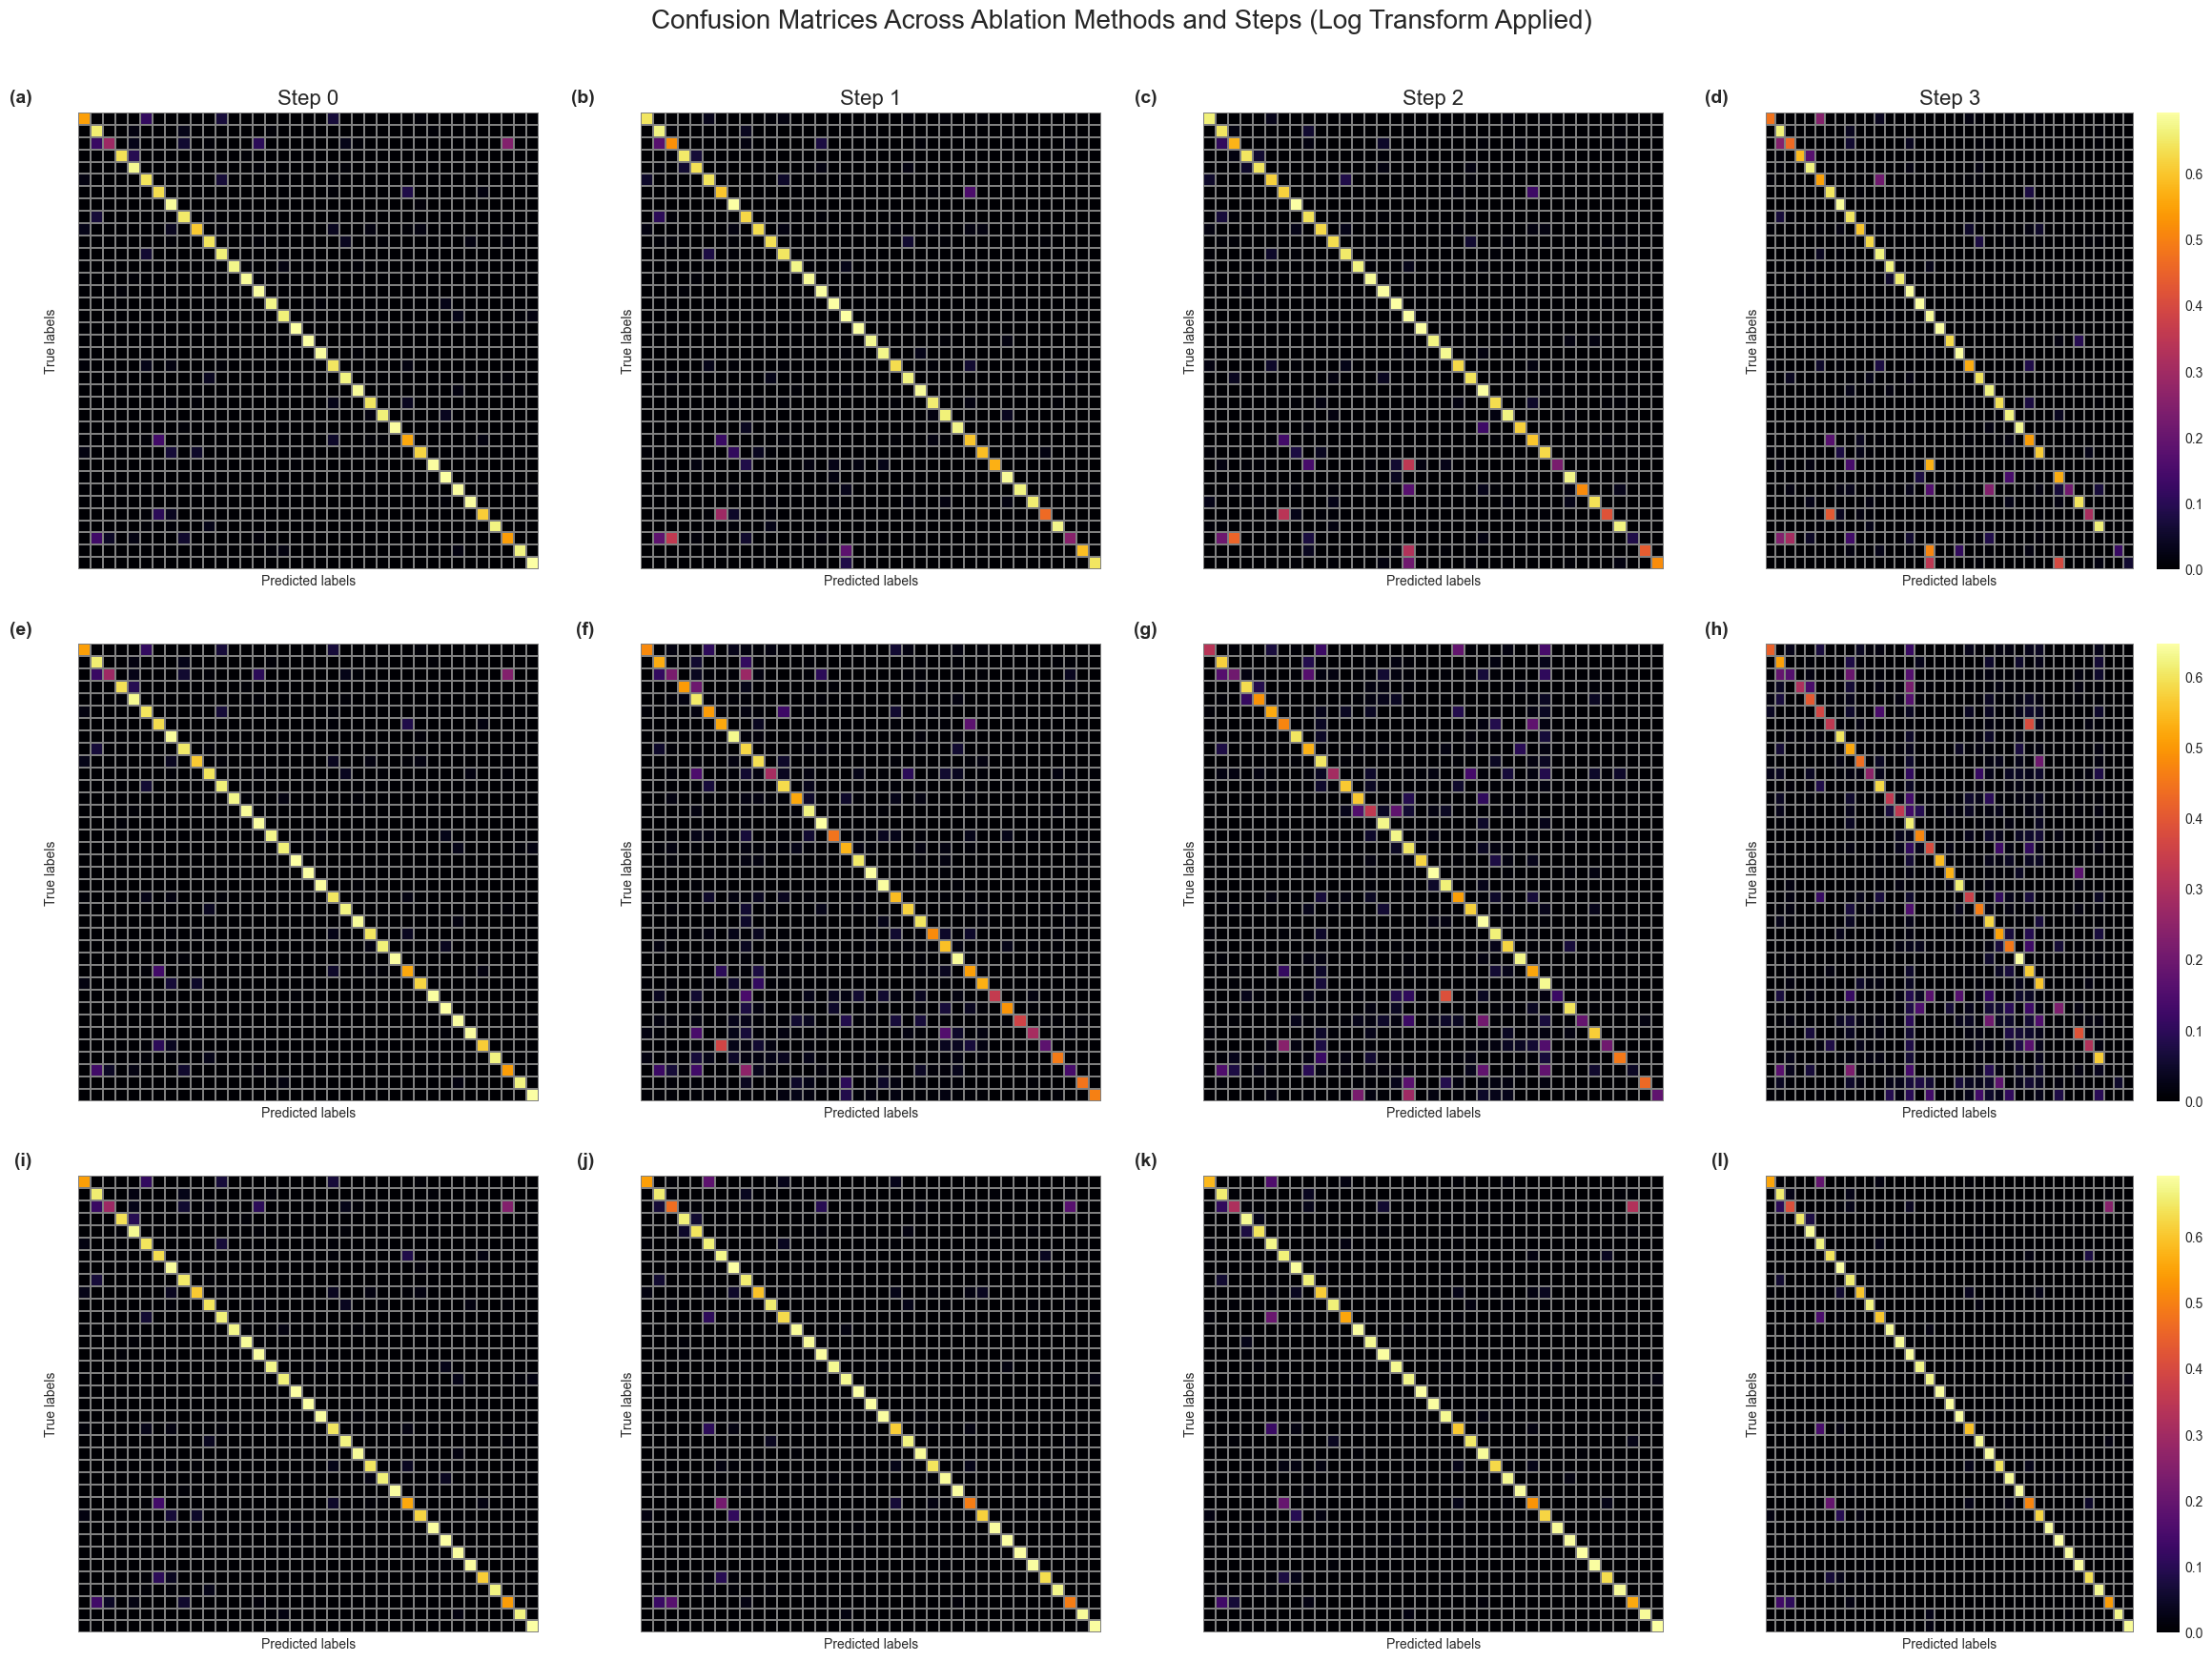

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 加载真实标签
true_labels_path = "/nvme/szh/code/tta-mr/data/pet-37/gen/test_label.npy"
true_labels = np.load(true_labels_path)

# 定义预测文件路径和方法
methods = ["restore", "tta_only", "contra_tta"]
steps = [0, 1, 2, 3]  # 包括 step_0
labels_order = list(range(37))  # 标签类别顺序（0 到 36）

# 设置绘图风格
plt.style.use("seaborn-white")

# 创建一个3x4的大画布
fig, axes = plt.subplots(len(methods), len(steps), figsize=(24, 18))

# 方法的友好名称映射
method_names = {
    "restore": "Only Restoration",
    "tta_only": "Only Adaptation",
    "contra_tta": "Restoration + Adaptation"
}

# 子图编号的初始值
subplot_idx = 0

# 遍历每个方法和步骤
for method_idx, method in enumerate(methods):
    for step_idx, step in enumerate(steps):
        # 加载预测标签
        if step == 0:
            # step_0 的文件名和路径固定
            predictions_path = "./predictions_pet37_ablation/contra_step_0_predictions.npy"
        else:
            predictions_path = f"./predictions_pet37_ablation/{method}_step_{step}_predictions.npy"

        try:
            predicted_labels = np.load(predictions_path)
        except FileNotFoundError:
            print(f"File not found: {predictions_path}, skipping...")
            continue

        # 计算混淆矩阵（归一化到真实标签上）
        cm = confusion_matrix(true_labels, predicted_labels, labels=labels_order, normalize="true")

        # 对混淆矩阵进行对数变换，使得小数值更加显著
        cm_log = np.log1p(cm)  # 使用 log(1 + x) 避免 log(0)

        # 在对应的子图上绘制混淆矩阵
        ax = axes[method_idx, step_idx]
        sns.heatmap(
            cm_log,
            annot=False,
            cmap="inferno",  # 使用高对比度的颜色图
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            cbar=(step_idx == len(steps) - 1),  # 最后一列添加颜色条
            linewidths=0.1,
            linecolor='gray'
        )

        # 设置标题、标签
        if step_idx == 0:
            ax.set_ylabel(f"{method_names[method]}", fontsize=16, labelpad=15)
        if method_idx == 0:
            ax.set_title(f"Step {step}", fontsize=16)
        ax.set_xlabel("Predicted labels", fontsize=10)
        ax.set_ylabel("True labels", fontsize=10)

        # 添加子图编号
        subplot_idx += 1
        ax.text(-0.1, 1.05, f"({chr(96 + subplot_idx)})", transform=ax.transAxes, 
                fontsize=14, fontweight='bold', va='top', ha='right')

        # 取消 x 和 y 的刻度，以减少杂乱
        ax.set_xticks([])
        ax.set_yticks([])

# 调整整体布局
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.92)
fig.suptitle("Confusion Matrices Across Ablation Methods and Steps (Log Transform Applied)", fontsize=20)

# 显示结果
plt.show()


/tmp/ipykernel_116696/2336562829.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


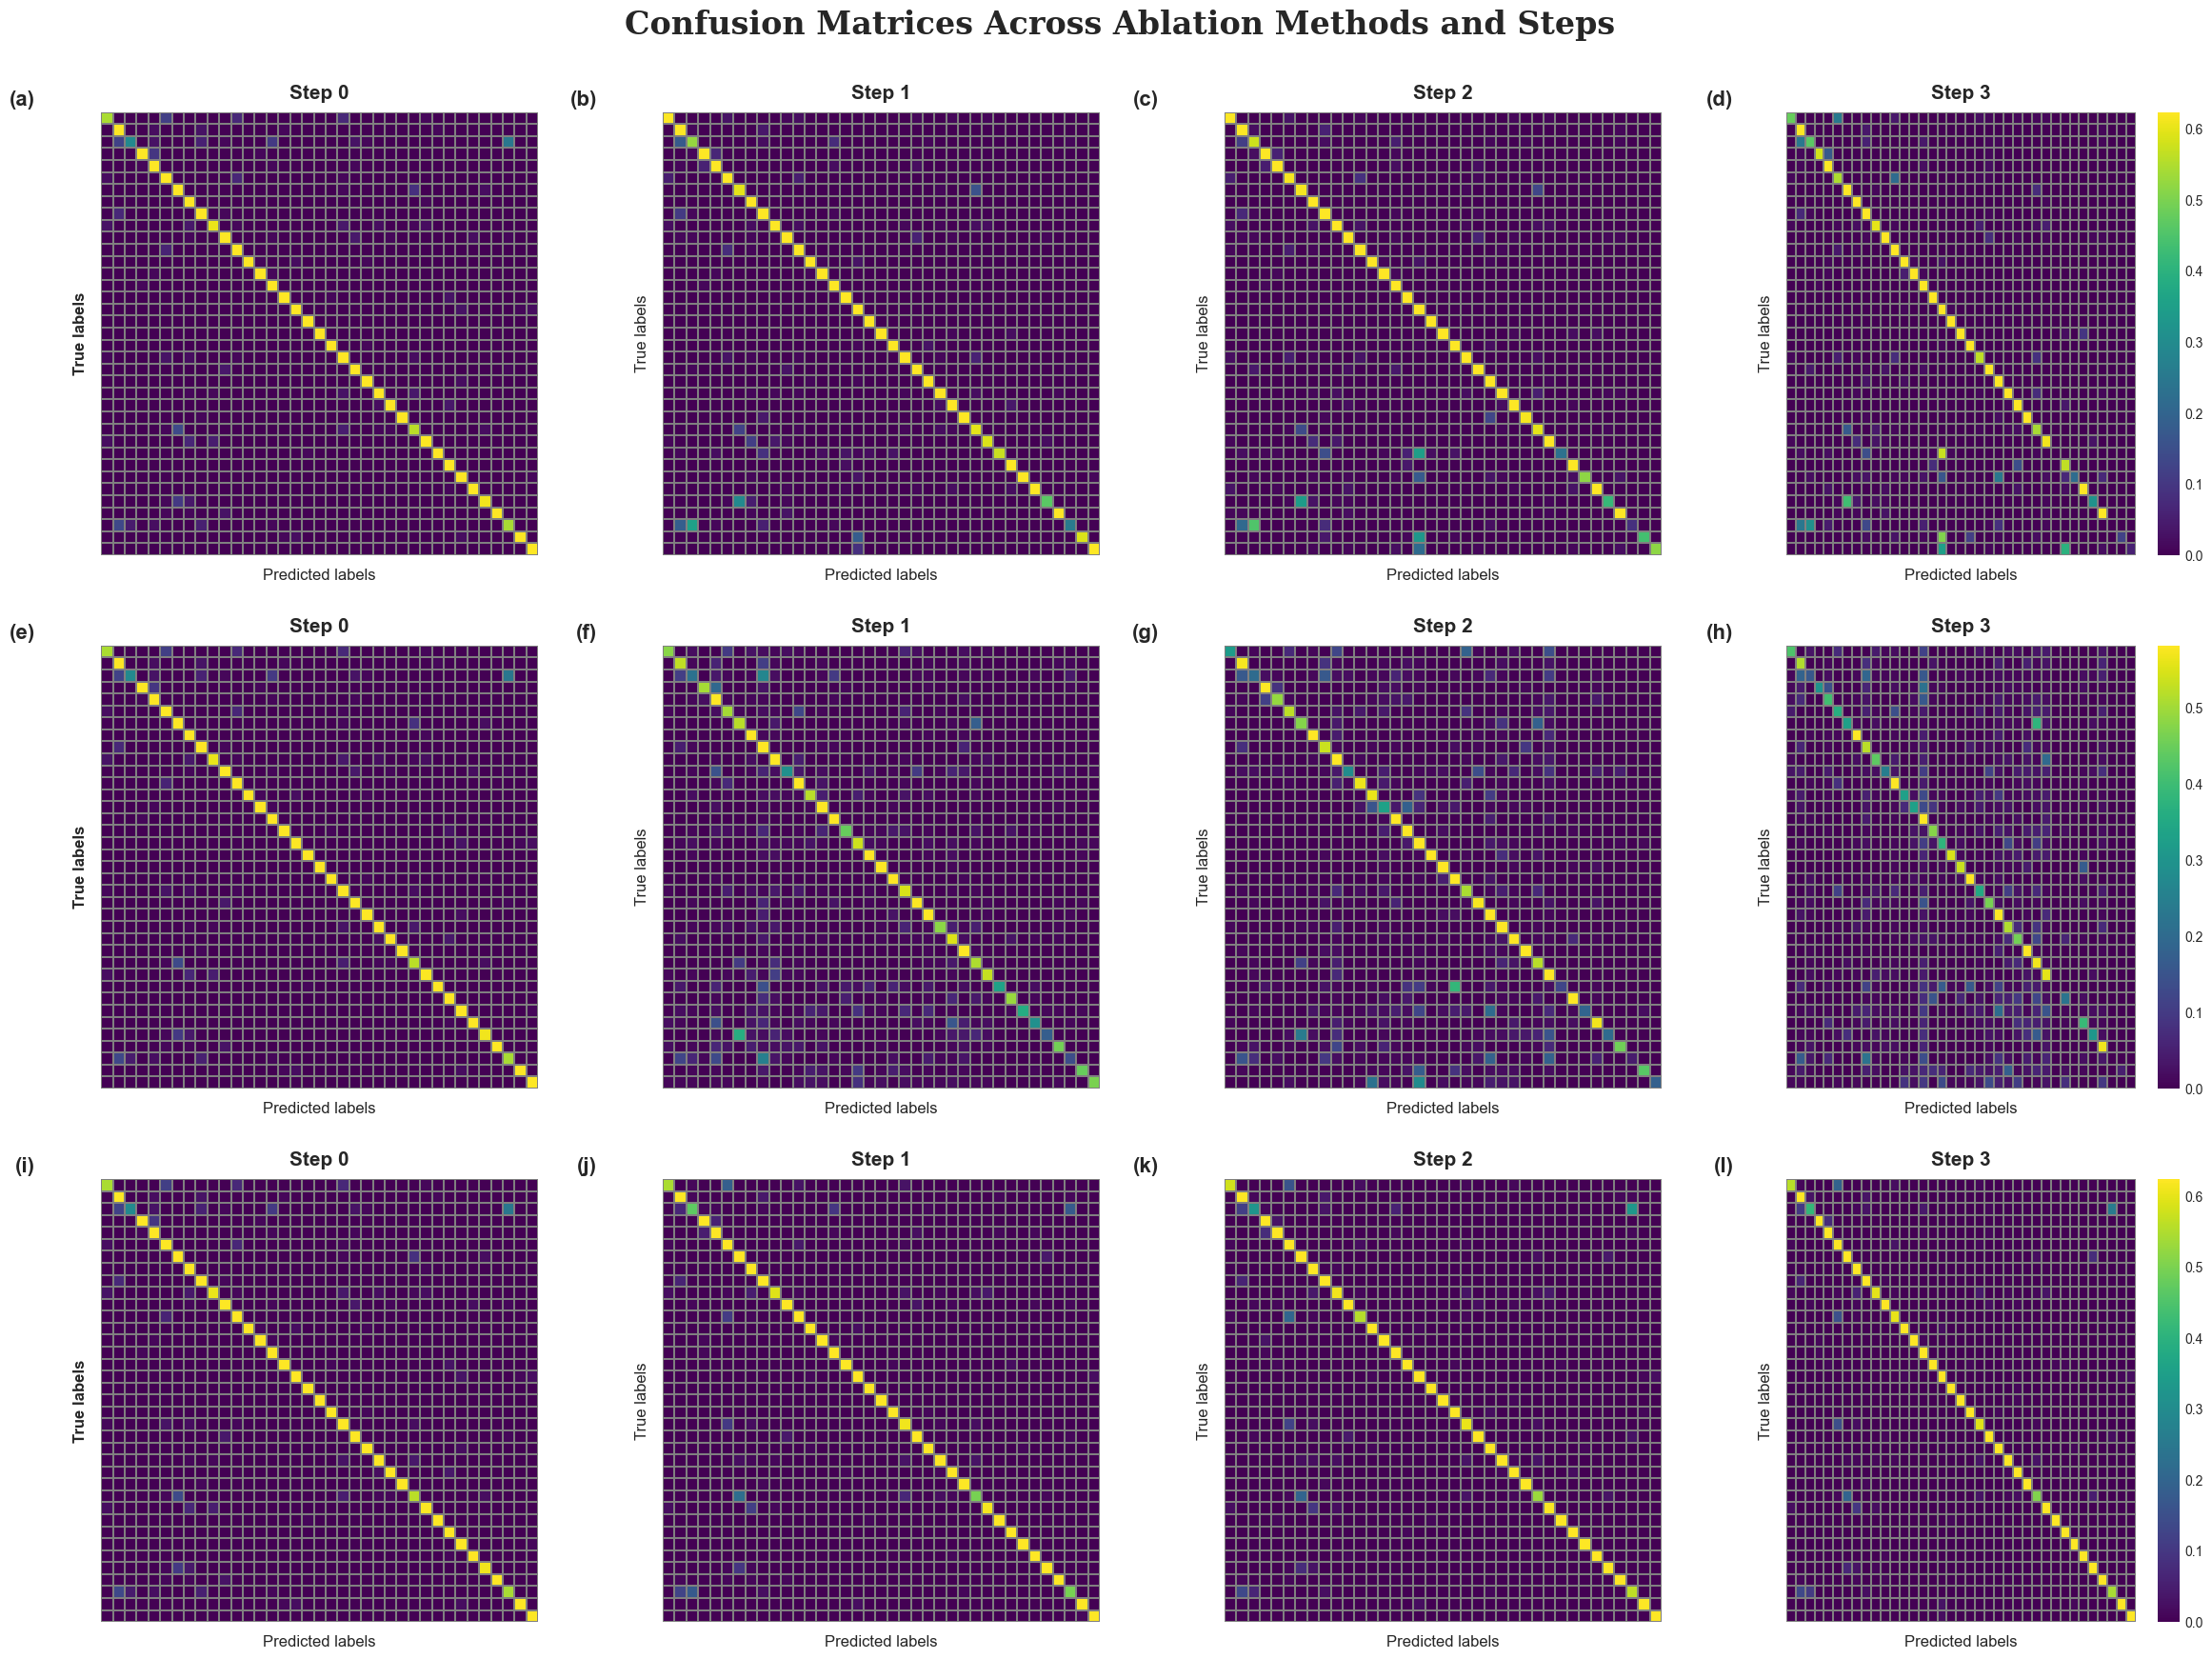

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 加载真实标签
true_labels_path = "/nvme/szh/code/tta-mr/data/pet-37/gen/test_label.npy"
true_labels = np.load(true_labels_path)

# 定义预测文件路径和方法
methods = ["restore", "tta_only", "contra_tta"]
steps = [0, 1, 2, 3]  # 包括 step_0
labels_order = list(range(37))  # 标签类别顺序（0 到 36）

# 设置绘图风格
plt.style.use("seaborn-white")

# 创建一个3x4的大画布
fig, axes = plt.subplots(len(methods), len(steps), figsize=(24, 18))

# 方法的友好名称映射
method_names = {
    "restore": "Only Restoration",
    "tta_only": "Only Adaptation",
    "contra_tta": "Restoration + Adaptation"
}

# 子图编号的初始值
subplot_idx = 0

# 遍历每个方法和步骤
for method_idx, method in enumerate(methods):
    for step_idx, step in enumerate(steps):
        # 加载预测标签
        if step == 0:
            # step_0 的文件名和路径固定
            predictions_path = "./predictions_pet37_ablation/contra_step_0_predictions.npy"
        else:
            predictions_path = f"./predictions_pet37_ablation/{method}_step_{step}_predictions.npy"

        try:
            predicted_labels = np.load(predictions_path)
        except FileNotFoundError:
            print(f"File not found: {predictions_path}, skipping...")
            continue

        # 计算混淆矩阵（归一化到真实标签上）
        cm = confusion_matrix(true_labels, predicted_labels, labels=labels_order, normalize="true")

        # 对混淆矩阵进行对数变换，使得小数值更加显著
        cm_log = np.log1p(cm)  # 使用 log(1 + x) 避免 log(0)

        # 在对应的子图上绘制混淆矩阵
        ax = axes[method_idx, step_idx]
        sns.heatmap(
            cm_log,
            annot=False,
            cmap="viridis",  # 使用对比度更高的 "viridis" 颜色图
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            cbar=(step_idx == len(steps) - 1),  # 最后一列添加颜色条
            linewidths=0.3,
            linecolor='gray',
            vmin=0, vmax=np.max(cm_log) * 0.9  # 调整颜色条的范围以增强对比度
        )

        # 设置标题、标签和字体
        ax.set_title(f"Step {step}", fontsize=15, fontweight='bold', pad=10)
        if step_idx == 0:
            ax.set_ylabel(f"{method_names[method]}", fontsize=15, fontweight='bold', labelpad=15)
        ax.set_xlabel("Predicted labels", fontsize=12, labelpad=10)
        ax.set_ylabel("True labels", fontsize=12, labelpad=10)

        # 添加子图编号
        subplot_idx += 1
        ax.text(-0.15, 1.05, f"({chr(96 + subplot_idx)})", transform=ax.transAxes, 
                fontsize=16, fontweight='bold', va='top', ha='right')

        # 取消 x 和 y 的刻度以减少杂乱
        ax.set_xticks([])
        ax.set_yticks([])

# 调整整体布局
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.92)
fig.suptitle("Confusion Matrices Across Ablation Methods and Steps", 
             fontsize=24, fontweight='bold', fontfamily='serif')

# 显示结果
plt.show()


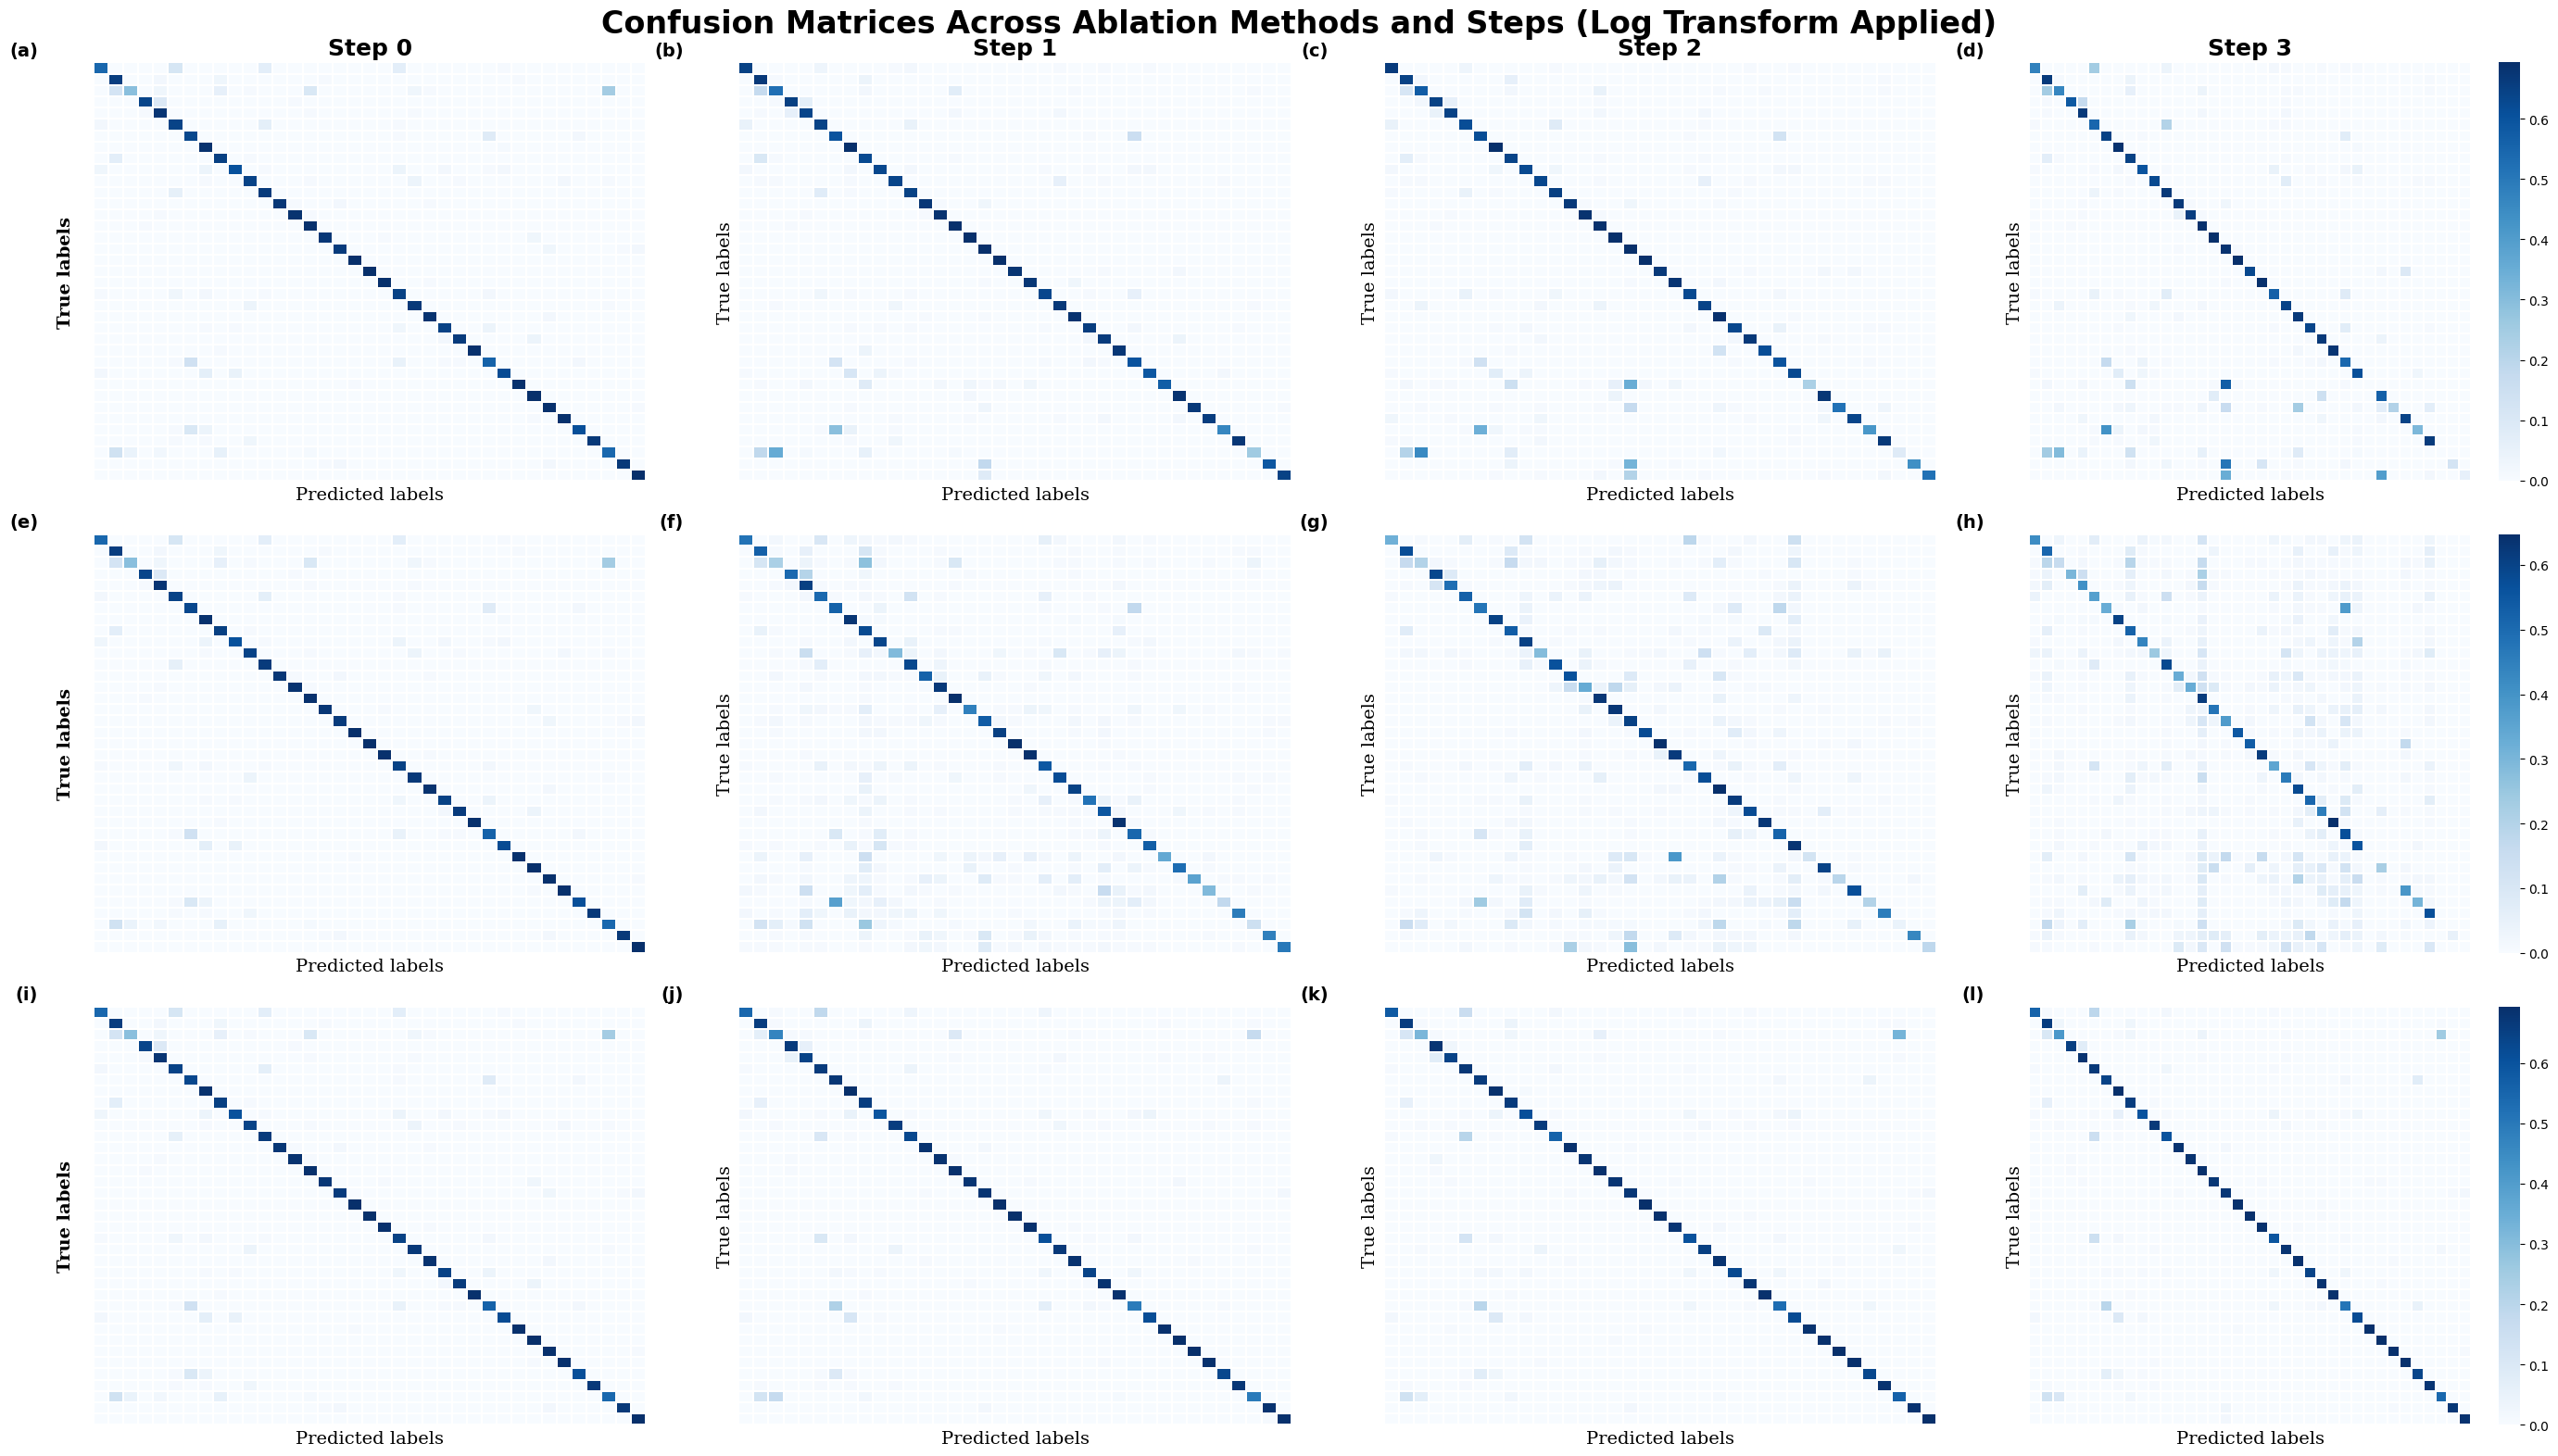

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 加载真实标签
true_labels_path = "/nvme/szh/code/tta-mr/data/pet-37/gen/test_label.npy"
true_labels = np.load(true_labels_path)

# 定义预测文件路径和方法
methods = ["restore", "tta_only", "contra_tta"]
steps = [0, 1, 2, 3]  # 包括 step_0
labels_order = list(range(37))  # 标签类别顺序（0 到 36）

# 方法的友好名称映射
method_names = {
    "restore": "Only Restoration",
    "tta_only": "Only Adaptation",
    "contra_tta": "Restoration + Adaptation"
}

# 设置绘图风格
plt.style.use("default")

# 创建一个3x4的大画布
fig, axes = plt.subplots(len(methods), len(steps), figsize=(28, 16))

# 设置标题字体大小
title_fs = 18
label_fs = 14

# 子图编号的初始值
subplot_idx = 0

# 遍历每个方法和步骤
for method_idx, method in enumerate(methods):
    for step_idx, step in enumerate(steps):
        # 加载预测标签
        if step == 0:
            # step_0 的文件名和路径固定
            predictions_path = "./predictions_pet37_ablation/contra_step_0_predictions.npy"
        else:
            predictions_path = f"./predictions_pet37_ablation/{method}_step_{step}_predictions.npy"

        try:
            predicted_labels = np.load(predictions_path)
        except FileNotFoundError:
            print(f"File not found: {predictions_path}, skipping...")
            continue

        # 计算混淆矩阵（归一化到真实标签上）
        cm = confusion_matrix(true_labels, predicted_labels, labels=labels_order, normalize="true")

        # 对混淆矩阵进行对数变换，使得小数值更加显著
        cm_log = np.log1p(cm)  # 使用 log(1 + x) 避免 log(0)

        # 在对应的子图上绘制混淆矩阵
        ax = axes[method_idx, step_idx]
        sns.heatmap(
            cm_log,
            annot=False,
            cmap="Blues",  # 使用较为柔和的颜色图
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            cbar=(step_idx == len(steps) - 1),  # 最后一列添加颜色条
            linewidths=0.3,
            linecolor='white'
        )

        # 设置标题、标签
        if step_idx == 0:
            ax.set_ylabel(f"{method_names[method]}", fontsize=title_fs, labelpad=15, fontfamily="serif", weight="bold")
        if method_idx == 0:
            ax.set_title(f"Step {step}", fontsize=title_fs, fontweight='bold')

        ax.set_xlabel("Predicted labels", fontsize=label_fs, fontfamily="serif")
        ax.set_ylabel("True labels", fontsize=label_fs, fontfamily="serif")

        # 添加子图编号
        subplot_idx += 1
        ax.text(-0.1, 1.05, f"({chr(96 + subplot_idx)})", transform=ax.transAxes, 
                fontsize=label_fs, fontweight='bold', va='top', ha='right')

        # 去掉x和y轴刻度，减少杂乱
        ax.set_xticks([])
        ax.set_yticks([])

# 调整整体布局
plt.subplots_adjust(left=0.05, right=0.95, top=0.93, bottom=0.05, wspace=0.25, hspace=0.3)
fig.suptitle("Confusion Matrices Across Ablation Methods and Steps (Log Transform Applied)", fontsize=24, fontweight='bold')
plt.tight_layout()

# 显示结果
plt.show()


/tmp/ipykernel_147780/900673951.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


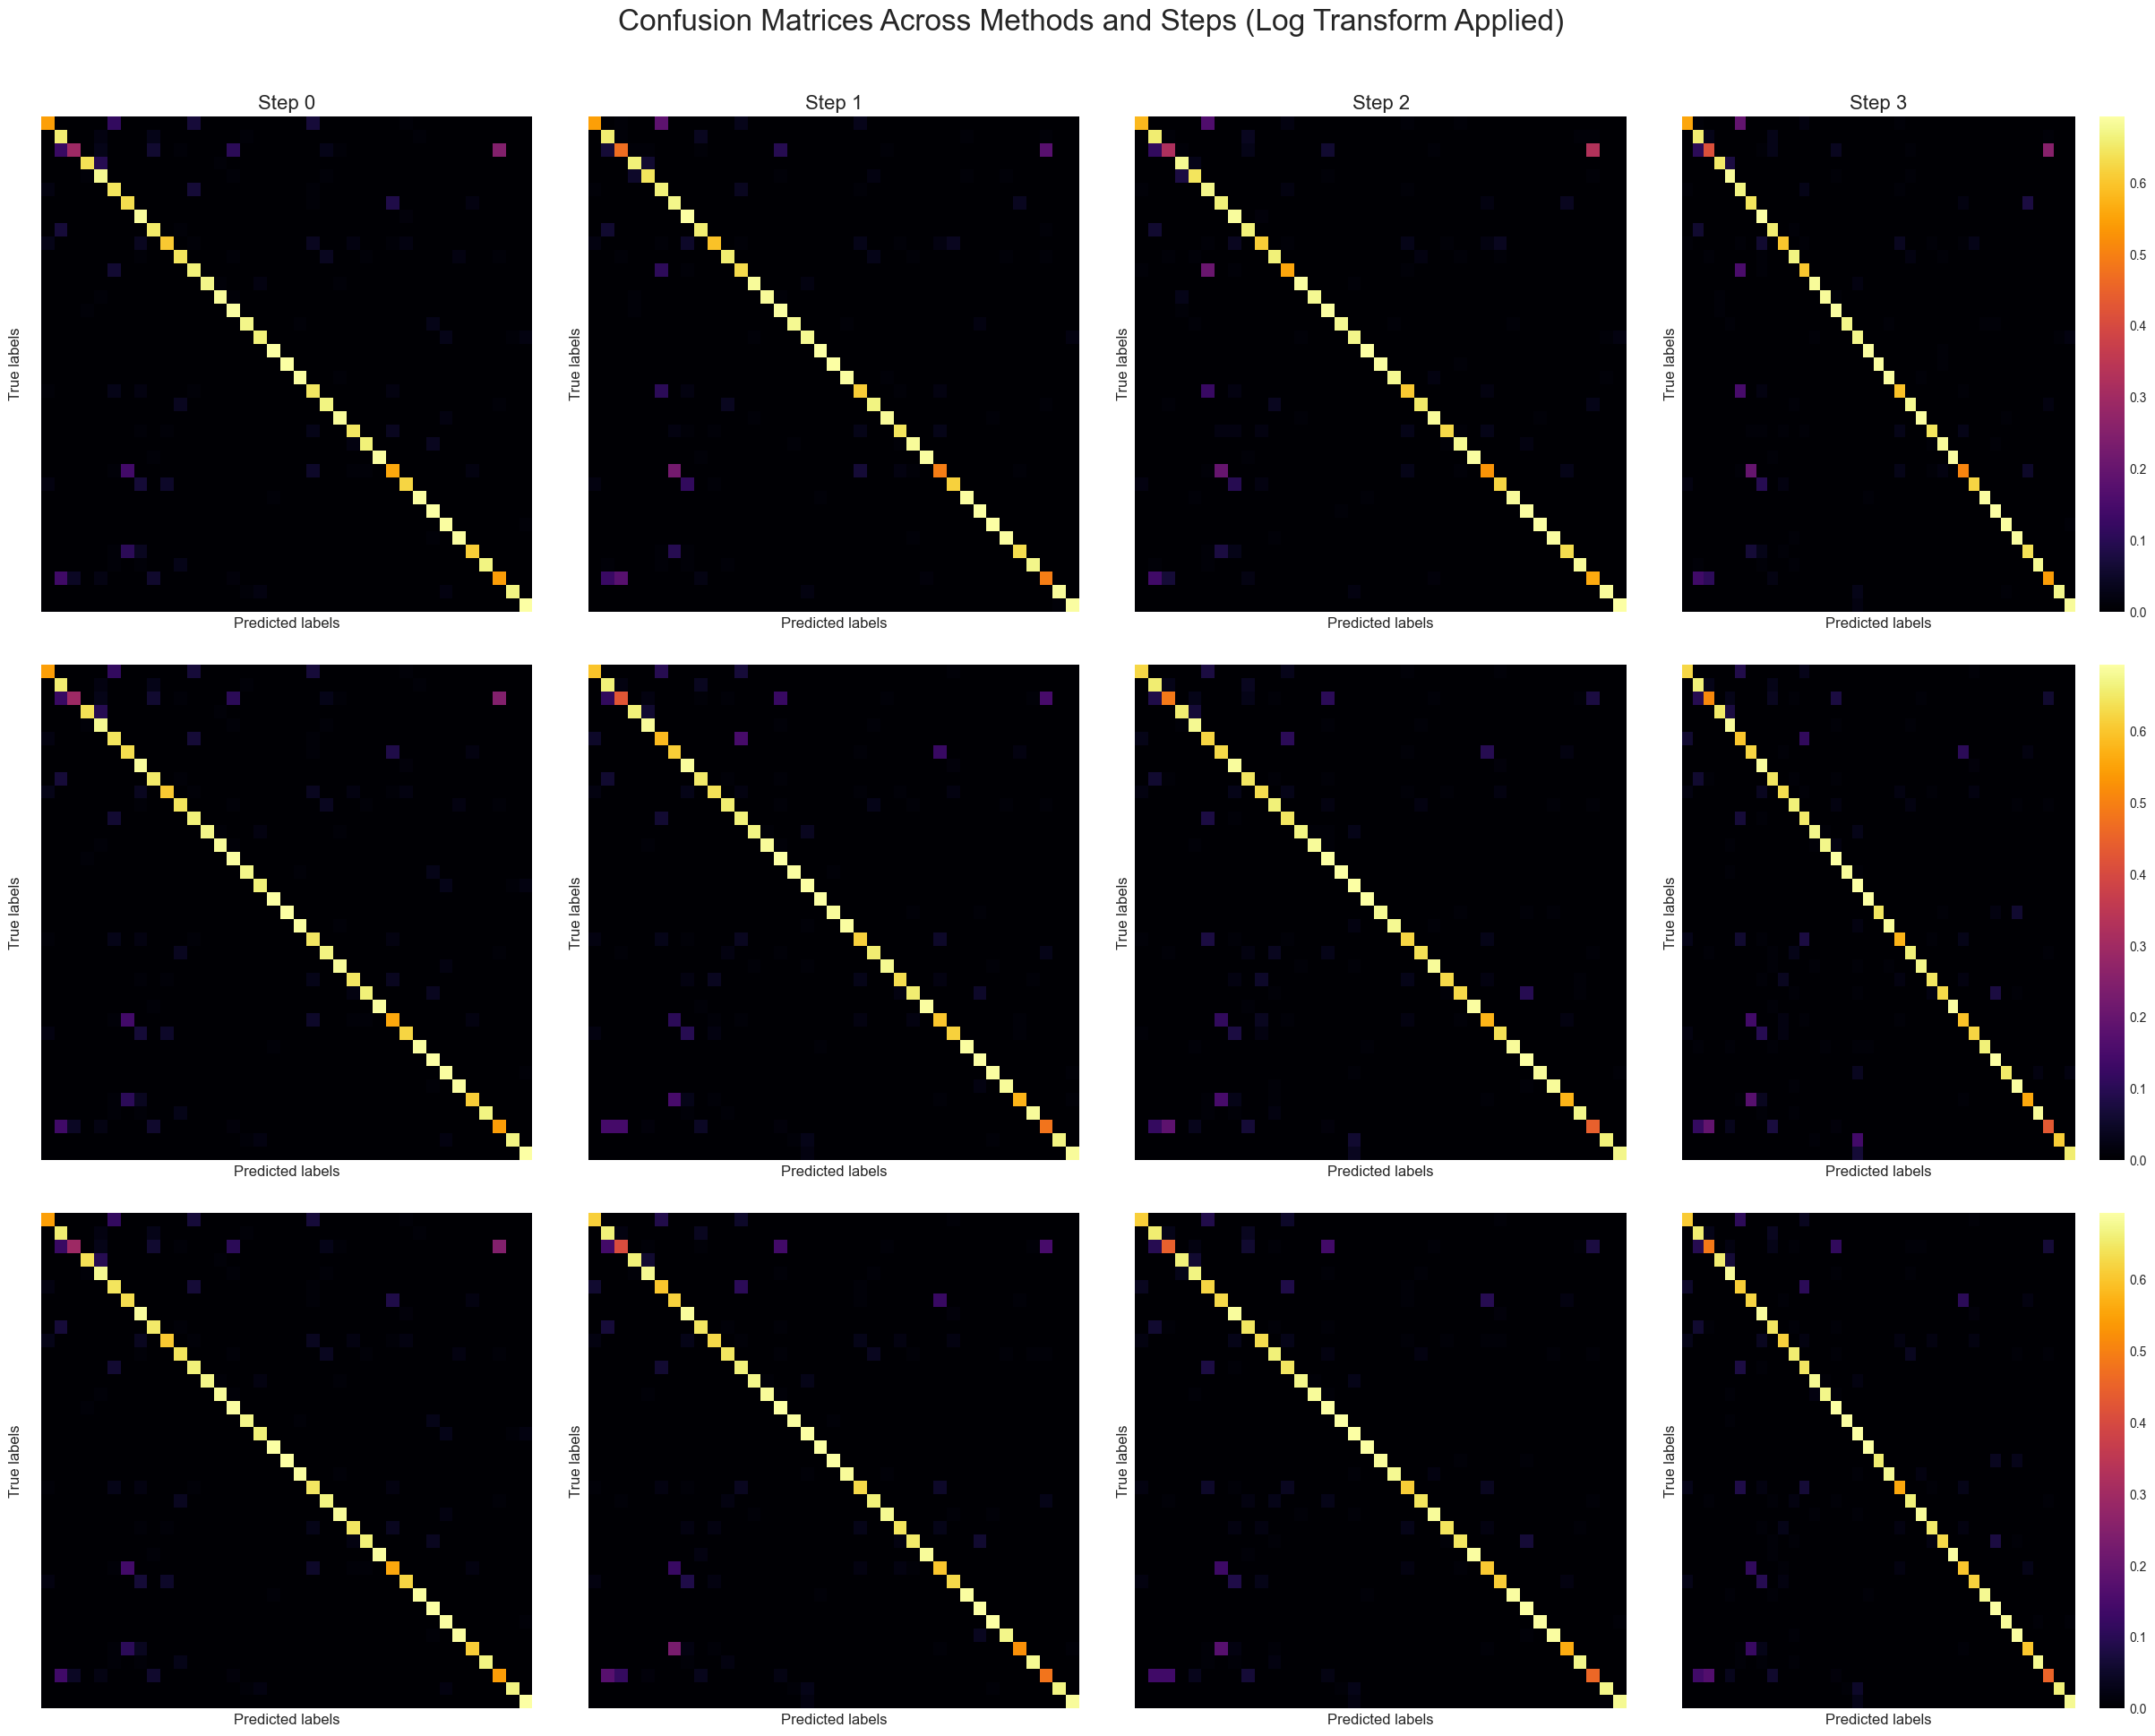

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 加载真实标签
true_labels_path = "/nvme/szh/code/tta-mr/data/pet-37/gen/test_label.npy"
true_labels = np.load(true_labels_path)

# 定义预测文件路径和方法
methods = ["contra", "Coteaching", "JoCoR"]
steps = [0, 1, 2, 3]
labels_order = list(range(37))  # 标签类别顺序（0 到 36）

# 设置绘图风格
plt.style.use("seaborn-white")

# 创建一个大画布
fig, axes = plt.subplots(len(methods), len(steps), figsize=(25, 20))

# 遍历每个方法和步骤
for method_idx, method in enumerate(methods):
    for step_idx, step in enumerate(steps):
        # 加载预测标签
        predictions_path = f"predictions_pet37/{method}_step_{step}_predictions.npy"
        predicted_labels = np.load(predictions_path)

        # 计算混淆矩阵（归一化到真实标签上）
        cm = confusion_matrix(
            true_labels, predicted_labels, labels=labels_order, normalize="true"
        )

        # 对混淆矩阵进行对数变换，使得小数值更加显著
        cm_log = np.log1p(cm)  # 使用 log(1 + x) 避免 log(0)

        # 在对应的子图上绘制混淆矩阵
        ax = axes[method_idx, step_idx]
        sns.heatmap(
            cm_log,
            annot=False,
            cmap="inferno",  # 使用高对比度的颜色图
            xticklabels=labels_order,
            yticklabels=labels_order,
            ax=ax,
            cbar=(step_idx == len(steps) - 1)  # 最后一列添加颜色条
        )

        # 设置标题、标签
        if step_idx == 0:
            ax.set_ylabel(f"{method}", fontsize=16, labelpad=15)
        if method_idx == 0:
            ax.set_title(f"Step {step}", fontsize=16)
        ax.set_xlabel("Predicted labels", fontsize=12)
        ax.set_ylabel("True labels", fontsize=12)

        # 取消 x 和 y 的刻度，以减少杂乱
        ax.set_xticks([])
        ax.set_yticks([])

# 调整整体布局
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.92)
fig.suptitle("Confusion Matrices Across Methods and Steps (Log Transform Applied)", fontsize=24)

# 显示结果
plt.show()


# ICDE:检索任务

## ICDE_Task: Cifar-100 检索

> 计算 mAP（test_acc 仅供参考）


In [ ]:
dataset_name = "cifar-100"
model_name = "cifar-wideresnet40"
noise_type = "asymmetric"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
steps: [0, 1, 2, 3]
"""
# methods = ['contra']
# methods = ['raw']
# methods = ['cotta']
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
# methods = ['raw', 'replay', 'Coteaching', 'Coteachingplus', 'JoCoR', 'cotta', 'plf', 'contra']
# methods = ['raw', 'replay', 'Coteaching', 'JoCoR', 'cotta', 'contra']

methods = ["cotta", "plf"]
# methods = ['replay', 'contra']
steps = [i for i in range(4)]
# steps = [3]
# ------------------------------------------------------------- #
"""
指定结果存储的路径
"""
results_dir = "./results_main"
# ------------------------------------------------------------- #
eva_test_acc(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    results_dir=results_dir,
)

# eva_map(dataset_name, model_name, noise_type,
#         methods=methods, steps=steps, results_dir=results_dir,
#         top_k=30)

TypeError: get_case() got an unexpected keyword argument 'balanced'

> 图片检索


In [ ]:
dataset_name = "cifar-100"
model_name = "cifar-wideresnet40"
noise_type = "asymmetric"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
steps: [0, 1, 2, 3]
"""

# methods = ['raw']
# methods = ['Coteaching']
# methods = ['JoCoR']
methods = ["contra"]

# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'contra']
# steps = [i for i in range(4)]
steps = [3]
# ------------------------------------------------------------- #

"""
检索用参数
"""
top_k = 5
query_indices = [333]
# ------------------------------------------------------------- #
# eva_retrieval(dataset_name, model_name, noise_type,
#               methods=methods, steps=steps,
#               top_k=top_k, query_indices=query_indices)

# 已经测试过一次的时候，用这个：
eva_retrieval(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    top_k=top_k,
    query_indices=query_indices,
    use_cache=True,
)

# 322-flatfish
# 333， 334


# for i in range(331, 340):
#     query_indices = [i]
#     eva_retrieval(dataset_name, model_name, noise_type,
#                 methods=methods, steps=steps,
#                 top_k=top_k, query_indices=query_indices,
#                 use_cache=True)

TypeError: get_case() got an unexpected keyword argument 'balanced'

## ICDE_Task: Pet-37 检索

> 计算 mAP（test_acc 仅供参考）


In [ ]:
dataset_name = "pet-37"
model_name = "wideresnet50"
noise_type = "asymmetric"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
steps: [0, 1, 2, 3]
"""
# methods = ["contra"]
# methods = ['raw']
# methods = ['raw', 'replay', 'Coteaching', 'Coteachingplus', 'JoCoR', 'cotta', 'plf', 'contra']
methods = ["raw", "replay", "Coteaching", "Coteachingplus", "JoCoR", "contra"]
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'contra']
steps = [i for i in range(4)]
# steps = [0]
# ------------------------------------------------------------- #
"""
指定结果存储的路径
"""
results_dir = "./results_main"
# ------------------------------------------------------------- #
# eva_test_acc(dataset_name, model_name, noise_type,
#              methods=methods, steps=steps, results_dir=results_dir)
eva_map(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    results_dir=results_dir,
)

目前测试的数据集：pet-37, case模式：nr_0.2_nt_asymmetric_balanced
Loading /nvme/sunzekun/Projects/tta-mr/data/pet-37/gen/train_data.npy
Loading /nvme/sunzekun/Projects/tta-mr/data/pet-37/gen/test_data.npy


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_0/raw/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:02<00:00,  9.68it/s]


测试mAP：0.9251547409945474


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/raw/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:03<00:00,  9.55it/s]


测试mAP：0.9148013573836509
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_2/raw/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:02<00:00,  9.

测试mAP：0.9096875952161549
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/raw/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:02<00:00,  9.

测试mAP：0.9043530954774125
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_0/replay/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:02<00:00,  9.

测试mAP：0.9251547409945474


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/replay/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:02<00:00,  9.76it/s]


测试mAP：0.9177437912543251


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_2/replay/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:03<00:00,  9.52it/s]


测试mAP：0.9152210837571858
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/replay/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.9187324545189103
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_0/Coteaching/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.9251547409945474
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/Coteaching/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:02<00:00,  9.

测试mAP：0.9278089685042727


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_2/Coteaching/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:02<00:00,  9.69it/s]


测试mAP：0.9276532534594045


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/Coteaching/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:02<00:00,  9.76it/s]


测试mAP：0.9249420219239992


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_0/Coteachingplus/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:02<00:00,  9.69it/s]


测试mAP：0.9251547409945474


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/Coteachingplus/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:03<00:00,  9.64it/s]


测试mAP：0.9285791414018745


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_2/Coteachingplus/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:02<00:00,  9.76it/s]


测试mAP：0.9288484774960427
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/Coteachingplus/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.9263703500867756


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_0/JoCoR/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:02<00:00,  9.67it/s]


测试mAP：0.9251547409945474
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/JoCoR/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.9296485916146537
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_2/JoCoR/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:02<00:00,  9.

测试mAP：0.9287602878941671
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/JoCoR/wideresnet50_worker_restore.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.9279553552415383


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_0/contra/wideresnet50_worker_restore.pth


100%|██████████| 29/29 [00:02<00:00,  9.69it/s]


测试mAP：0.9251547409945474
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_1/contra/wideresnet50_worker_tta.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  9.

测试mAP：0.9274598884404008
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_2/contra/wideresnet50_worker_tta.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  8.

测试mAP：0.9257037432665848
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/contra/wideresnet50_worker_tta.pth


/tmp/ipykernel_203777/187945098.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)
100%|██████████| 29/29 [00:03<00:00,  8.

测试mAP：0.9270099602836401


> 图片检索


目前测试的数据集：pet-37, case模式：nr_0.2_nt_asymmetric_balanced
Loading /nvme/sunzekun/Projects/tta-mr/data/pet-37/gen/train_data.npy
Loading /nvme/sunzekun/Projects/tta-mr/data/pet-37/gen/test_data.npy
Evaluating /nvme/sunzekun/Projects/tta-mr/ckpt/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/contra/wideresnet50_worker_tta.pth
读取缓存的相似度分数记录：/nvme/sunzekun/Projects/tta-mr/result_analysis/results_main/rtv_cache/pet-37/nr_0.2_nt_asymmetric_balanced/step_3/contra/top_5.npz
展示Query图片-idx-321的搜索结果


/tmp/ipykernel_203777/3385060708.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_repair_save_path)


查询图片label：3-Basset Hound


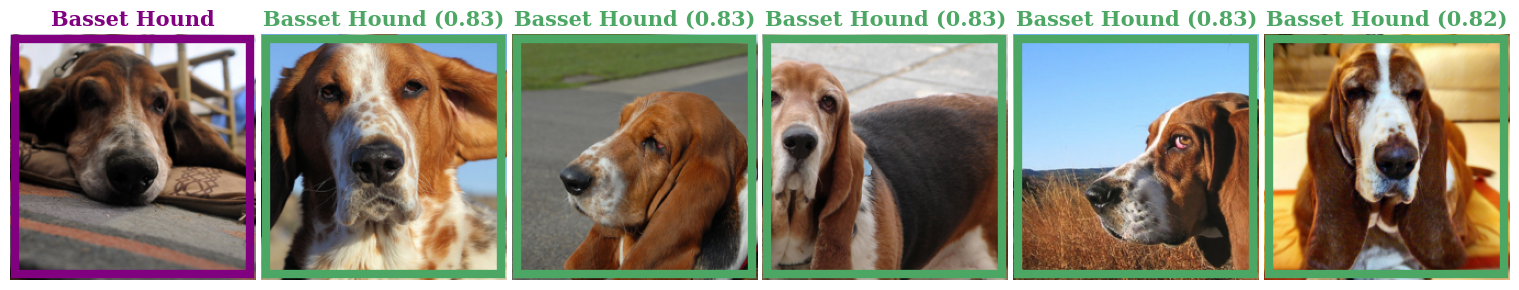

In [ ]:
dataset_name = "pet-37"
model_name = "wideresnet50"
noise_type = "asymmetric"

# ------------------------------------------------------------- #
"""
实验区：手动指定要评估的组
methods: ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
steps: [0, 1, 2, 3]
"""
methods = ["contra"]
# methods = ['raw']
# methods = ['Coteaching']
# methods = ['JoCoR']
# methods = ['cotta']
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'cotta', 'plf', 'contra']
# methods = ['raw', 'coteaching', 'coteaching_plus', 'jocor', 'contra']
# steps = [i for i in range(4)]
steps = [3]
# ------------------------------------------------------------- #
"""
检索用参数
"""
top_k = 5
# query_indices = [3102] # Shiba Inu
# query_indices = [3102]


# query_indices = [2321] # Perisian
# query_indices = [444] # 币哥
# query_indices = [303] #

query_indices = [321]

# ------------------------------------------------------------- #
# eva_retrieval(dataset_name, model_name, noise_type,
#               methods=methods, steps=steps,
#               top_k=top_k, query_indices=query_indices)

# 已经计算过一次分数的时候，用这个：
eva_retrieval(
    dataset_name,
    model_name,
    noise_type,
    methods=methods,
    steps=steps,
    top_k=top_k,
    query_indices=query_indices,
    use_cache=True,
)


# # 303、304
# for i in range(321, 330):
#     query_indices = [i]
#     eva_retrieval(dataset_name, model_name, noise_type,
#                 methods=methods, steps=steps,
#                 top_k=top_k, query_indices=query_indices,
#                 use_cache=True)